# Prep

In [ ]:
# %pip install -U spacy
# %python -m spacy download en_core_web_sm
# !python -m spacy download en_core_web_sm

In [ ]:
# %pip uninstall numpy
# %pip install numpy==1.22.4
# %pip install gensim==4.2.0
# %pip install --upgrade gensim
# !pip install gensim
# %pip install scipy==1.7.3

!pip install numpy>=1.22.4
!pip install gensim==4.2.0
!pip install --upgrade gensim

  Using cached gensim-4.2.0.tar.gz (23.2 MB)
ERROR: Operation cancelled by user


# EDA

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from google.colab import drive
drive.mount('/content/drive')

import nltk
nltk.download('stopwords')
nltk.download('punkt_tab')

# df = pd.read_csv("/content/drive/MyDrive/6. TUGAS AKHIR/0. DATASET/new_train.csv")
# df = pd.read_csv("/content/drive/MyDrive/6. TUGAS AKHIR/0. DATASET/new_train_2.csv")
# df = pd.read_csv("/content/drive/MyDrive/6. TUGAS AKHIR/0. DATASET/new_combined.csv")
df = pd.read_csv("/content/drive/MyDrive/6. TUGAS AKHIR/0. DATASET/new_all.csv")

df.info()
display(df)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9498 entries, 0 to 9497
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   posts   9497 non-null   object
 1   type    9498 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 148.5+ KB


posts  type
0     lol pretty sure I ve mistype bunch extp like a...     5
1     lol okay let break down esfp here no I m prett...     5
2     lol okay I m pretty sure mistype bunch extp li...     5
3     lol okay hear out what mistype part fun like e...     5
4     lol pretty sure mistype bunch extp nah can not...     5
...                                                 ...   ...
9493  what I say then understand your opinion apprec...    12
9494  or could find niche make r rate comic book mov...    11
9495  scenario focus on your feeling process here yo...     8
9496  nuclear since folk mention it I like new fashi...    14
9497  here short documentary life canadian many peop...    11

[9498 rows x 2 columns]

In [ ]:
# import pandas as pd

# df_combined = pd.read_csv("/content/drive/MyDrive/6. TUGAS AKHIR/0. DATASET/new_test.csv")

# df_all = pd.concat([df, df_combined], ignore_index=True)

# df_all.to_csv("/content/drive/MyDrive/6. TUGAS AKHIR/0. DATASET/new_all.csv", index=False)

# print(f"total baris: {len(df_all)}")

total baris: 9498


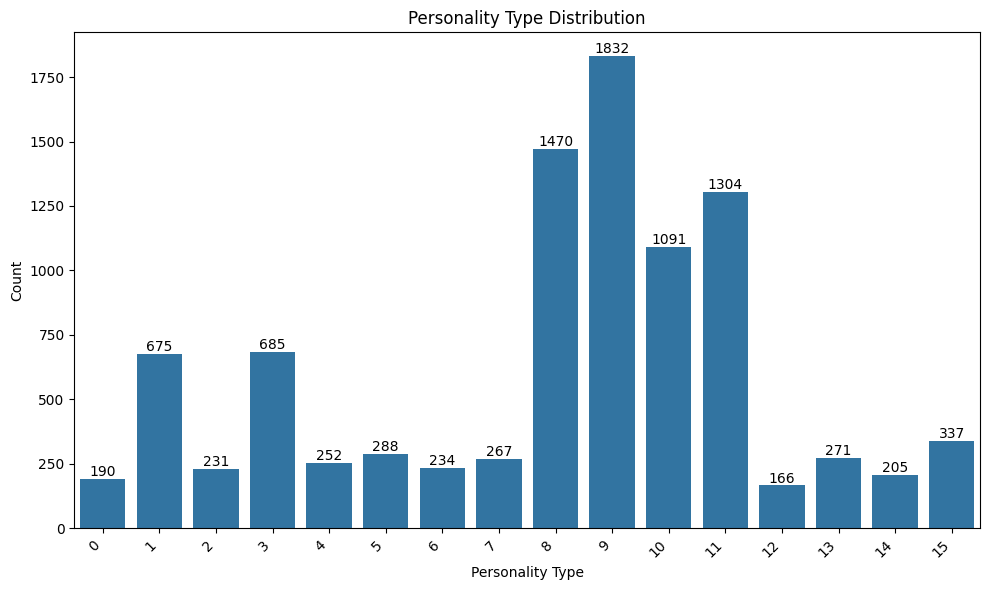

In [ ]:
# Bar graph
plt.figure(figsize=(10, 6))
type_counts = df['type'].value_counts().sort_values(ascending=False)
ax = sns.barplot(x=type_counts.index, y=type_counts.values)

plt.xlabel("Personality Type")
plt.ylabel("Count")
plt.title("Personality Type Distribution")

# Count labels on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, xytext=(0, 5), textcoords='offset points')

plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [ ]:
df = df.drop_duplicates()
df = df.dropna()

df.isnull().sum()

posts    0
type     0
dtype: int64

In [ ]:
null_data = df[df['posts'].isnull()]

print(null_data)

     posts  type
4007   NaN     9


In [ ]:
# Mengecek validitas tipe MBTI
valid_types = {'INFJ', 'INTJ', 'ENTP', 'INTP', 'ENTJ', 'INFP', 'ENFP', 'ISTJ',
               'ISFJ', 'ESTJ', 'ESFJ', 'ISTP', 'ISFP', 'ESTP', 'ESFP', 'ENFJ'}
invalid_types = set(df['type']) - valid_types
print("Invalid types:", invalid_types)

Invalid types: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}


# Trial Augmentasi

## ESTJ

### Aug

In [ ]:
import pandas as pd
import numpy as np
import requests
import json
import time
import random
from concurrent.futures import ThreadPoolExecutor, as_completed
import os
from typing import List, Dict
import re
from collections import Counter
from tqdm import tqdm

DEEPSEEK_API_KEY = "sk-e92ef99b1b90466d9d485ee74dc0ccac"
DEEPSEEK_API_URL = "https://api.deepseek.com/v1/chat/completions"
MAX_WORKERS = 10
BATCH_SIZE = 30
VARIATIONS_PER_POST = 5  # Setiap post original dapat 5 variasi

# MBTI PERSONALITY DESCRIPTIONS
MBTI_DESCRIPTIONS = {
    'INTJ': 'Architect - Strategic, independent, analytical, future-focused, prefer working alone, logical decision makers',
    'INTP': 'Thinker - Love theories and abstract concepts, flexible, curious, innovative problem solvers',
    'ENTJ': 'Commander - Natural leaders, efficient, strategic, goal-oriented, decisive',
    'ENTP': 'Debater - Innovative, enthusiastic, good at generating ideas, adaptable, enjoy intellectual challenges',
    'INFJ': 'Advocate - Empathetic, idealistic, organized, value harmony, future-oriented',
    'INFP': 'Mediator - Creative, idealistic, value authenticity, flexible, compassionate',
    'ENFJ': 'Protagonist - Charismatic leaders, empathetic, organized, people-focused, inspiring',
    'ENFP': 'Campaigner - Enthusiastic, creative, people-oriented, flexible, optimistic',
    'ISTJ': 'Logistician - Practical, fact-focused, organized, reliable, traditional, detail-oriented',
    'ISFJ': 'Protector - Caring, practical, detail-oriented, loyal, traditional, service-oriented',
    'ESTJ': 'Executive - Practical leaders, organized, fact-focused, efficient, traditional',
    'ESFJ': 'Consul - People-focused, organized, caring, traditional, service-oriented',
    'ISTP': 'Virtuoso - Practical, hands-on, flexible, independent, problem-solvers',
    'ISFP': 'Adventurer - Artistic, flexible, caring, value harmony, present-focused',
    'ESTP': 'Entrepreneur - Energetic, practical, adaptable, action-oriented, social',
    'ESFP': 'Entertainer - Enthusiastic, people-oriented, flexible, spontaneous, optimistic'
}

def load_clean_dataset(file_path: str) -> pd.DataFrame:
    """Load dataset yang sudah dibersihkan"""
    try:
        if file_path.endswith('.csv'):
            df = pd.read_csv(file_path)
        elif file_path.endswith('.json'):
            df = pd.read_json(file_path)
        elif file_path.endswith('.xlsx'):
            df = pd.read_excel(file_path)
        else:
            df = pd.read_csv(file_path)

        print(f"✅ Clean dataset loaded: {df.shape}")
        print(f"Columns: {list(df.columns)}")
        print(f"MBTI distribution:")
        distribution = df['type'].value_counts().sort_index()
        for mbti_type, count in distribution.items():
            print(f"  {mbti_type}: {count} posts")

        return df
    except Exception as e:
        print(f" Error loading dataset: {e}")
        return None

def generate_single_variation(original_post: str, mbti_type: str, variation_num: int) -> Dict:
    """Generate 1 variasi dari original post"""

    mbti_desc = MBTI_DESCRIPTIONS.get(mbti_type, "")

    # 5 jenis variasi yang berbeda
    variation_prompts = {
        1: f"""You are a {mbti_type} personality type: {mbti_desc}

Rewrite this social media post using different words while keeping the same meaning and emotional tone. Maintain the {mbti_type} personality traits in your writing style:

Original: "{original_post}"

Rewritten:""", # Parafrase

        2: f"""You are a {mbti_type} personality type: {mbti_desc}

Expand this post with more details or examples while keeping the same core message and {mbti_type} characteristics:

Original: "{original_post}"

Expanded:""", # menambah penjelasan/contoh relevan, biar postingan lebih lengkap tapi inti pesan tetap sama (tetap ngikutin karakter MBTI)

        3: f"""You are a {mbti_type} personality type: {mbti_desc}

Rewrite this post in a different tone (more casual or formal) while maintaining the same meaning and {mbti_type} traits:

Original: "{original_post}"

Different tone:""", # gaya bahasa yang beda(misal dari formal jd santai), tapi makna dan karakter MBTI konsisten

        4: f"""You are a {mbti_type} personality type: {mbti_desc}

Express the same idea from a slightly different perspective while clearly showing {mbti_type} personality characteristics:

Original: "{original_post}"

Different perspective:""", # menyampaikan ide yang sama tp dr sudut pandang/pendekatan lain, misal dari pov orang/situasi lain

        5: f"""You are a {mbti_type} personality type: {mbti_desc}

Restructure this post with different sentence patterns while keeping the same sentiment and {mbti_type} personality evident:

Original: "{original_post}"

Restructured:""" # mengubah struktur kalimat, kayak membalik susunan, buat kalimat lebih panjang/pendek
    }

    payload = {
        "model": "deepseek-chat",
        "temperature": 0.7, # parameter yang ngatur randomness (kreativitas) output. kl rendah konsisten, tinggi kreatif
        "max_tokens": 400,
        "messages": [
            {
                "role": "system",
                "content": "You are an expert at writing social media posts that reflect specific MBTI personalities. "
                "Always respond with only the requested post, no additional text or quotes."
            },
            {
                "role": "user",
                "content": variation_prompts[variation_num] # prompt 5 variasi augmentasi
            }
        ]
    }

    headers = {
        "Authorization": f"Bearer {DEEPSEEK_API_KEY}",
        "Content-Type": "application/json"
    }

    # Retry logic
    max_retries = 3
    for attempt in range(max_retries):
        try:
            response = requests.post(DEEPSEEK_API_URL, headers=headers, json=payload, timeout=30)
            response.raise_for_status()

            augmented_text = response.json()["choices"][0]["message"]["content"].strip()

            if augmented_text.startswith('"') and augmented_text.endswith('"'):
                augmented_text = augmented_text[1:-1]

            # Remove common AI response patterns
            augmented_text = augmented_text.replace("Here's the rewritten post:", "")
            augmented_text = augmented_text.replace("Rewritten:", "")
            augmented_text = augmented_text.strip()

            return {
                "success": True,
                "augmented_post": augmented_text,
                "variation_type": f"variation_{variation_num}",
                "original_post": original_post,
                "mbti_type": mbti_type
            }

        except Exception as e:
            if attempt < max_retries - 1:
                sleep_time = 2 ** attempt
                time.sleep(sleep_time)
            else:
                return {
                    "success": False,
                    "error": str(e),
                    "original_post": original_post,
                    "mbti_type": mbti_type,
                    "variation_type": f"variation_{variation_num}"
                }

def process_single_post(row_data):
    """Process 1 post original to 5 variation"""
    original_post = row_data['lemmatized_posts']
    mbti_type = row_data['type']

    variations = []

    # Generate 5 variasi
    for var_num in range(1, VARIATIONS_PER_POST + 1):
        result = generate_single_variation(original_post, mbti_type, var_num)
        if result["success"]:
            variations.append({
                'type': mbti_type,
                'posts': result['augmented_post'],
                'source': 'augmented',
                'variation_type': result['variation_type']
            })
        else:
            print(f"❌ Failed variation {var_num} for {mbti_type}: {result.get('error', 'Unknown error')}")

        # Rate limiting
        time.sleep(0.2)

    return variations

def augment_dataset_simple(df: pd.DataFrame) -> pd.DataFrame:
    """Simple augmentation - setiap post dapat 5 variasi"""

    print(f"🚀 Starting simple augmentation...")
    print(f"Original dataset: {len(df)} posts")
    print(f"Target: {len(df) * VARIATIONS_PER_POST} augmented posts")
    print(f"Expected total: {len(df) * (VARIATIONS_PER_POST + 1)} posts")

    augmented_data = []

    # Convert DataFrame to list of dicts for processing
    posts_to_process = df.to_dict('records')

    # Process in batches
    total_batches = len(posts_to_process) // BATCH_SIZE + (1 if len(posts_to_process) % BATCH_SIZE != 0 else 0)

    with tqdm(total=len(posts_to_process), desc="Processing posts") as pbar:
        for batch_num in range(total_batches):
            start_idx = batch_num * BATCH_SIZE
            end_idx = min(start_idx + BATCH_SIZE, len(posts_to_process))
            batch_posts = posts_to_process[start_idx:end_idx]

            print(f"\n Processing batch {batch_num + 1}/{total_batches} ({len(batch_posts)} posts)")

            # Process batch with threading
            batch_results = []
            with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
                future_to_post = {executor.submit(process_single_post, post): post for post in batch_posts}

                for future in as_completed(future_to_post):
                    post = future_to_post[future]
                    try:
                        variations = future.result()
                        batch_results.extend(variations)
                        pbar.update(1)

                    except Exception as exc:
                        print(f"❌ Error processing post: {exc}")
                        pbar.update(1)

            augmented_data.extend(batch_results)

            successful_variations = len(batch_results)
            expected_variations = len(batch_posts) * VARIATIONS_PER_POST
            success_rate = (successful_variations / expected_variations) * 100 if expected_variations > 0 else 0

            print(f"✅ Batch {batch_num + 1} complete: {successful_variations}/{expected_variations} variations ({success_rate:.1f}%)")

            # Sleep between batches
            if batch_num < total_batches - 1:
                time.sleep(2)

    augmented_df = pd.DataFrame(augmented_data)

    df_original = df.copy()
    df_original['source'] = 'original'
    df_original['variation_type'] = 'original'

    combined_df = pd.concat([df_original, augmented_df], ignore_index=True)

    print(f"\n✅ Augmentation complete!")
    print(f"Original posts: {len(df)}")
    print(f"Augmented posts: {len(augmented_df)}")
    print(f"Total posts: {len(combined_df)}")
    print(f"Expansion ratio: {len(combined_df) / len(df):.1f}x")

    # Show distribution
    print(f"\nFinal distribution:")
    final_dist = combined_df['type'].value_counts().sort_index()
    for mbti_type, count in final_dist.items():
        original_count = df['type'].value_counts().get(mbti_type, 0)
        augmented_count = count - original_count
        print(f"  {mbti_type}: {count} total ({original_count} original + {augmented_count} augmented)")

    return combined_df

def save_augmented_dataset(df: pd.DataFrame, output_path: str):
    """Save augmented dataset"""
    try:
        df.to_csv(output_path, index=False)
        print(f"✅ Dataset saved to: {output_path}")

        # # Auto download in Colab
        # if 'google.colab' in str(get_ipython()):
        #     files.download(output_path)

    except Exception as e:
        print(f"❌ Error saving dataset: {e}")

def main():
    """Main function"""

    # 1. Load cleaned dataset
    dataset_path = r"C:\Users\Ulima\Downloads\estj.csv"  # Ganti path ini
    print("📁 Loading cleaned dataset...")
    df = load_clean_dataset(dataset_path)

    if df is None:
        print("❌ Failed to load dataset. Please check the file path.")
        return

    # 2. Validate required columns
    required_columns = ['type', 'lemmatized_posts']
    if not all(col in df.columns for col in required_columns):
        print(f"❌ Dataset must contain columns: {required_columns}")
        print(f"Found columns: {list(df.columns)}")
        return

    # 3. Remove any rows with empty posts
    df = df.dropna(subset=['lemmatized_posts'])
    df = df[df['lemmatized_posts'].str.len() > 0]
    print(f"Dataset after removing empty posts: {df.shape}")

    # 4. Simple augmentation - 5 variations per post
    print("🔄 Starting augmentation (5 variations per post)...")
    augmented_df = augment_dataset_simple(df)

    # 5. Save results
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    output_path = f"/content/mbti_augmented_5x_{timestamp}.csv"
    save_augmented_dataset(augmented_df, output_path)

    # 6. Final statistics
    print("\n📊 FINAL STATISTICS:")
    print(f"✅ Each original post generated {VARIATIONS_PER_POST} variations")
    print(f"✅ Original: {len(df):,} posts")
    print(f"✅ Augmented: {len(augmented_df):,} posts")
    print(f"✅ Total: {len(augmented_df):,} posts")
    print(f"✅ Expansion: {len(augmented_df) / len(df):.1f}x")

if __name__ == "__main__":
    # Check API key
    if DEEPSEEK_API_KEY == "your-deepseek-api-key-here":
        print("⚠️  Please set your DeepSeek API key first!")
        print("Get your API key from: https://platform.deepseek.com/")
    else:
        main()

📁 Loading cleaned dataset...
✅ Clean dataset loaded: (39, 2)
Columns: ['type', 'lemmatized_posts']
MBTI distribution:
  ESTJ: 39 posts
Dataset after removing empty posts: (39, 2)
🔄 Starting augmentation (5 variations per post)...
🚀 Starting simple augmentation...
Original dataset: 39 posts
Target: 195 augmented posts
Expected total: 234 posts


Processing posts:   0%|          | 0/39 [00:00<?, ?it/s]


 Processing batch 1/2 (30 posts)


Processing posts:  77%|███████▋  | 30/39 [05:51<01:51, 12.39s/it]

✅ Batch 1 complete: 150/150 variations (100.0%)

 Processing batch 2/2 (9 posts)


Processing posts: 100%|██████████| 39/39 [08:16<00:00, 12.74s/it]

✅ Batch 2 complete: 45/45 variations (100.0%)

✅ Augmentation complete!
Original posts: 39
Augmented posts: 195
Total posts: 234
Expansion ratio: 6.0x

Final distribution:
  ESTJ: 234 total (39 original + 195 augmented)
✅ Dataset saved to: /content/mbti_augmented_5x_20250604_175923.csv

📊 FINAL STATISTICS:
✅ Each original post generated 5 variations
✅ Original: 39 posts
✅ Augmented: 234 posts
✅ Total: 234 posts
✅ Expansion: 6.0x


### Cleaning

In [ ]:
import shutil
import os

source_path = "/content/mbti_augmented_5x_20250604_175923.csv"
target_folder = r"C:\Users\Ulima\Downloads"

if not os.path.exists(target_folder):
    os.makedirs(target_folder)

dest_path = os.path.join(target_folder, os.path.basename(source_path))

# Pindahkan file
shutil.move(source_path, dest_path)

print(f"File moved to {dest_path}")


File moved to C:\Users\Ulima\Downloads\mbti_augmented_5x_20250604_175923.csv


In [ ]:
import pandas as pd
import re
import csv

df = pd.read_csv(r"C:\Users\Ulima\Downloads\mbti_augmented_5x_20250604_175923.csv")

def clean_and_join_sentences(text):
    if pd.isna(text):
        return ''
    # Hilangkan semua newline \n dan \r dengan spasi
    text = re.sub(r'[\r\n]+', ' ', text)
    # Hilangkan spasi berlebih
    text = re.sub(r'\s+', ' ', text).strip()
    # Pastikan titik di akhir
    if text and not text.endswith('.'):
        text += '.'
    return text


df['posts_clean'] = df['posts'].apply(clean_and_join_sentences)

print(df.loc[df['variation_type'] == 'variation_1', 'posts_clean'].iloc[0])

df.to_csv(r"C:\Users\Ulima\Downloads\joined_aug.csv", index=False, quoting=csv.QUOTE_MINIMAL)
print("Done cleaning and saving.")


"Organized and efficient leaders know the value of clear communication. Let’s focus on facts and tradition—random thoughts don’t drive progress. Stay practical, stay productive. #ESTJ #Leadership" *(Note: The original text was highly disorganized and incoherent, so the rewrite reflects ESTJ traits by delivering a structured, purposeful message instead.)*.
Done cleaning and saving.


In [ ]:
import pandas as pd

df = pd.read_csv(r"C:\Users\Ulima\Downloads\joined_aug.csv")

df = df.drop(columns=['posts'])
print(df.columns)

df.to_csv(r"C:\Users\Ulima\Downloads\aug_new.csv", index=False)

Index(['type', 'lemmatized_posts', 'source', 'variation_type', 'posts_clean'], dtype='object')


In [ ]:
import pandas as pd

df = pd.read_csv(r"C:\Users\Ulima\Downloads\aug_new.csv")

df_original = df[(df['type'] == 'ESTJ') & (df['source'] == 'original')]

df_original_39 = df_original.head(39)

df_augmented = df[(df['type'] == 'ESTJ') & (df['source'] == 'augmented')]

df_original_39.to_csv(r"C:\Users\Ulima\Downloads\estj_original.csv", index=False)
df_augmented.to_csv(r"C:\Users\Ulima\Downloads\estj_augmented.csv", index=False)

In [ ]:
import pandas as pd

estj_ori = pd.read_csv(r"C:\Users\Ulima\Downloads\estj_original.csv")
estj_aug = pd.read_csv(r"C:\Users\Ulima\Downloads\estj_augmented.csv")

def prepare_ori(df):
    if 'posts_clean' in df.columns:
        df = df.drop(columns=['posts_clean'])
    if 'source' in df.columns:
        df = df.drop(columns=['source'])
    if 'variation_type' in df.columns:
        df = df.drop(columns=['variation_type'])
    if 'lemmatized_posts' in df.columns:
        df = df.rename(columns={'lemmatized_posts': 'posts'})
    return df

def prepare_aug(df):
    if 'lemmatized_posts' in df.columns:
        df = df.drop(columns=['lemmatized_posts'])
    if 'source' in df.columns:
        df = df.drop(columns=['source'])
    if 'variation_type' in df.columns:
        df = df.drop(columns=['variation_type'])
    if 'posts_clean' in df.columns:
        df = df.rename(columns={'posts_clean': 'posts'})
    return df

estj_ori = prepare_ori(estj_ori)
estj_aug = prepare_aug(estj_aug)

print("estj_ori columns:", estj_ori.columns)
print("estj_aug columns:", estj_aug.columns)

estj_ori.to_csv(r"C:\Users\Ulima\Downloads\estj_ori_clean.csv", index=False)
estj_aug.to_csv(r"C:\Users\Ulima\Downloads\estj_aug_clean.csv", index=False)


estj_ori columns: Index(['type', 'posts'], dtype='object')
estj_aug columns: Index(['type', 'posts'], dtype='object')


In [ ]:
# %pip install tqdm

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import pandas as pd
import re
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

df = pd.read_csv(r"C:\Users\Ulima\Downloads\estj_aug_clean.csv")

def clean_text(text):
    if pd.isna(text):
        return ''

    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = ' '.join([word for word in text.split() if word.lower() not in stop_words])
    text = re.sub(r'[–—]', ' ', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    text = re.sub(r'^["\']+|["\']+$', '', text.strip())
    text = re.sub(r'[\r\n]+', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()

    if text and not text.endswith('.'):
        text += '.'

    return text

df['cleaned_posts'] = df['posts'].apply(clean_text)

df.to_csv(r"C:\Users\Ulima\Downloads\2_estj_aug_clean.csv", index=False)

display(df)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ulima\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


type                                              posts  \
0    ESTJ  "Organized and efficient leaders know the valu...   
1    ESTJ  "Let’s get organized—here’s how to handle a wi...   
2    ESTJ  Let’s keep things organized and efficient. If ...   
3    ESTJ  Let’s cut to the chase—efficiency and clarity ...   
4    ESTJ  Let’s keep things efficient and organized. If ...   
..    ...                                                ...   
190  ESTJ  "Taking on personal challenges, I enjoy portra...   
191  ESTJ  "Let me break this down with some ESTJ efficie...   
192  ESTJ  "Taking on different characters as a personal ...   
193  ESTJ  Cosplay is a great way to challenge myself by ...   
194  ESTJ  "Taking on personal challenges is something I ...   

                                         cleaned_posts  
0    organized efficient leaders know value clear c...  
1    lets get organized heres handle wild opossum e...  
2    lets keep things organized efficient youre deb...  
3    lets cut chase efficiency clarity matter youre...  
4    lets keep things efficient organized youre deb...  
..                                                 ...  
190  taking personal challenges enjoy portraying ch...  
191  let break estj efficiency personal challenge e...  
192  taking different characters personal challenge...  
193  cosplay great way challenge stepping different...  
194  taking personal challenges something enjoy esp...  

[195 rows x 3 columns]

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')

def spacy_lemmatize(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc if not token.is_punct and not token.is_space])

def limit_text_length(text, max_words=1024):
    words = text.split()
    if len(words) > max_words:
        return ' '.join(words[:max_words])
    return text

df['cleaned_posts_limited'] = df['cleaned_posts'].apply(limit_text_length)
df['lemmatized_posts'] = df['cleaned_posts_limited'].apply(spacy_lemmatize)

df.to_csv(r"C:\Users\Ulima\Downloads\estj_aug_lemma.csv", index=False)

In [ ]:
df = df.drop(columns=['posts'])
df = df.drop(columns=['cleaned_posts'])
df = df.drop(columns=['cleaned_posts_limited'])

df.to_csv(r"C:\Users\Ulima\Downloads\2_estj_aug_lemma.csv", index=False)
df

type                                   lemmatized_posts
0    ESTJ  organize efficient leader know value clear com...
1    ESTJ  let get organize here handle wild opossum enco...
2    ESTJ  let keep thing organize efficient you re debat...
3    ESTJ  let cut chase efficiency clarity matter you re...
4    ESTJ  let keep thing efficient organize you re debat...
..    ...                                                ...
190  ESTJ  take personal challenge enjoy portray characte...
191  ESTJ  let break estj efficiency personal challenge e...
192  ESTJ  take different character personal challenge al...
193  ESTJ  cosplay great way challenge step different rol...
194  ESTJ  take personal challenge something enjoy especi...

[195 rows x 2 columns]

## ESFJ ESFP

### Aug

In [ ]:
import pandas as pd
import numpy as np
import requests
import json
import time
import random
from concurrent.futures import ThreadPoolExecutor, as_completed
import os
from typing import List, Dict
import re
from collections import Counter
from tqdm import tqdm

DEEPSEEK_API_KEY = "sk-e92ef99b1b90466d9d485ee74dc0ccac"
DEEPSEEK_API_URL = "https://api.deepseek.com/v1/chat/completions"
MAX_WORKERS = 10
BATCH_SIZE = 50
VARIATIONS_PER_POST = 5  # Setiap post original dapat 5 variasi

# MBTI PERSONALITY DESCRIPTIONS
MBTI_DESCRIPTIONS = {
    'INTJ': 'Architect - Strategic, independent, analytical, future-focused, prefer working alone, logical decision makers',
    'INTP': 'Thinker - Love theories and abstract concepts, flexible, curious, innovative problem solvers',
    'ENTJ': 'Commander - Natural leaders, efficient, strategic, goal-oriented, decisive',
    'ENTP': 'Debater - Innovative, enthusiastic, good at generating ideas, adaptable, enjoy intellectual challenges',
    'INFJ': 'Advocate - Empathetic, idealistic, organized, value harmony, future-oriented',
    'INFP': 'Mediator - Creative, idealistic, value authenticity, flexible, compassionate',
    'ENFJ': 'Protagonist - Charismatic leaders, empathetic, organized, people-focused, inspiring',
    'ENFP': 'Campaigner - Enthusiastic, creative, people-oriented, flexible, optimistic',
    'ISTJ': 'Logistician - Practical, fact-focused, organized, reliable, traditional, detail-oriented',
    'ISFJ': 'Protector - Caring, practical, detail-oriented, loyal, traditional, service-oriented',
    'ESTJ': 'Executive - Practical leaders, organized, fact-focused, efficient, traditional',
    'ESFJ': 'Consul - People-focused, organized, caring, traditional, service-oriented',
    'ISTP': 'Virtuoso - Practical, hands-on, flexible, independent, problem-solvers',
    'ISFP': 'Adventurer - Artistic, flexible, caring, value harmony, present-focused',
    'ESTP': 'Entrepreneur - Energetic, practical, adaptable, action-oriented, social',
    'ESFP': 'Entertainer - Enthusiastic, people-oriented, flexible, spontaneous, optimistic'
}

def load_clean_dataset(file_path: str) -> pd.DataFrame:
    """Load dataset yang sudah dibersihkan"""
    try:
        if file_path.endswith('.csv'):
            df = pd.read_csv(file_path)
        elif file_path.endswith('.json'):
            df = pd.read_json(file_path)
        elif file_path.endswith('.xlsx'):
            df = pd.read_excel(file_path)
        else:
            df = pd.read_csv(file_path)

        print(f" Clean dataset loaded: {df.shape}")
        print(f"Columns: {list(df.columns)}")
        print(f"MBTI distribution:")
        distribution = df['type'].value_counts().sort_index()
        for mbti_type, count in distribution.items():
            print(f"  {mbti_type}: {count} posts")

        return df
    except Exception as e:
        print(f" Error loading dataset: {e}")
        return None

def generate_single_variation(original_post: str, mbti_type: str, variation_num: int) -> Dict:
    """Generate 1 variasi dari original post"""

    mbti_desc = MBTI_DESCRIPTIONS.get(mbti_type, "")

    # 5 jenis variasi yang berbeda
    variation_prompts = {
        1: f"""You are a {mbti_type} personality type: {mbti_desc}

Rewrite this social media post using different words while keeping the same meaning and emotional tone. Maintain the {mbti_type} personality traits in your writing style:

Original: "{original_post}"

Rewritten:""", # Parafrase

        2: f"""You are a {mbti_type} personality type: {mbti_desc}

Expand this post with more details or examples while keeping the same core message and {mbti_type} characteristics:

Original: "{original_post}"

Expanded:""", # menambah penjelasan/contoh relevan, biar postingan lebih lengkap tapi inti pesan tetap sama (tetap ngikutin karakter MBTI)

        3: f"""You are a {mbti_type} personality type: {mbti_desc}

Rewrite this post in a different tone (more casual or formal) while maintaining the same meaning and {mbti_type} traits:

Original: "{original_post}"

Different tone:""", # gaya bahasa yang beda(misal dari formal jd santai), tapi makna dan karakter MBTI konsisten

        4: f"""You are a {mbti_type} personality type: {mbti_desc}

Express the same idea from a slightly different perspective while clearly showing {mbti_type} personality characteristics:

Original: "{original_post}"

Different perspective:""", # menyampaikan ide yang sama tp dr sudut pandang/pendekatan lain, misal dari pov orang/situasi lain

        5: f"""You are a {mbti_type} personality type: {mbti_desc}

Restructure this post with different sentence patterns while keeping the same sentiment and {mbti_type} personality evident:

Original: "{original_post}"

Restructured:""" # mengubah struktur kalimat, kayak membalik susunan, buat kalimat lebih panjang/pendek
    }

    payload = {
        "model": "deepseek-chat",
        "temperature": 0.7, # parameter yang ngatur randomness (kreativitas) output. kl rendah konsisten, tinggi kreatif
        "max_tokens": 400,
        "messages": [
            {
                "role": "system",
                "content": "You are an expert at writing social media posts that reflect specific MBTI personalities. "
                "Always respond with only the requested post, no additional text or quotes."
            },
            {
                "role": "user",
                "content": variation_prompts[variation_num] # prompt 5 variasi augmentasi
            }
        ]
    }

    headers = {
        "Authorization": f"Bearer {DEEPSEEK_API_KEY}",
        "Content-Type": "application/json"
    }

    # Retry logic
    max_retries = 3
    for attempt in range(max_retries):
        try:
            response = requests.post(DEEPSEEK_API_URL, headers=headers, json=payload, timeout=30)
            response.raise_for_status()

            augmented_text = response.json()["choices"][0]["message"]["content"].strip()

            if augmented_text.startswith('"') and augmented_text.endswith('"'):
                augmented_text = augmented_text[1:-1]

            # Remove common AI response patterns
            augmented_text = augmented_text.replace("Here's the rewritten post:", "")
            augmented_text = augmented_text.replace("Rewritten:", "")
            augmented_text = augmented_text.strip()

            return {
                "success": True,
                "augmented_post": augmented_text,
                "variation_type": f"variation_{variation_num}",
                "original_post": original_post,
                "mbti_type": mbti_type
            }

        except Exception as e:
            if attempt < max_retries - 1:
                sleep_time = 2 ** attempt
                time.sleep(sleep_time)
            else:
                return {
                    "success": False,
                    "error": str(e),
                    "original_post": original_post,
                    "mbti_type": mbti_type,
                    "variation_type": f"variation_{variation_num}"
                }

def process_single_post(row_data):
    """Process 1 post original to 5 variation"""
    original_post = row_data['lemmatized_posts']
    mbti_type = row_data['type']

    variations = []

    # Generate 5 variasi
    for var_num in range(1, VARIATIONS_PER_POST + 1):
        result = generate_single_variation(original_post, mbti_type, var_num)
        if result["success"]:
            variations.append({
                'type': mbti_type,
                'posts': result['augmented_post'],
                'source': 'augmented',
                'variation_type': result['variation_type']
            })
        else:
            print(f" Failed variation {var_num} for {mbti_type}: {result.get('error', 'Unknown error')}")

        # Rate limiting
        time.sleep(0.2)

    return variations

def augment_dataset_simple(df: pd.DataFrame) -> pd.DataFrame:
    """Simple augmentation - setiap post dapat 5 variasi"""

    print(f" Starting simple augmentation...")
    print(f"Original dataset: {len(df)} posts")
    print(f"Target: {len(df) * VARIATIONS_PER_POST} augmented posts")
    print(f"Expected total: {len(df) * (VARIATIONS_PER_POST + 1)} posts")

    augmented_data = []

    # Convert DataFrame to list of dicts for processing
    posts_to_process = df.to_dict('records')

    # Process in batches
    total_batches = len(posts_to_process) // BATCH_SIZE + (1 if len(posts_to_process) % BATCH_SIZE != 0 else 0)

    with tqdm(total=len(posts_to_process), desc="Processing posts") as pbar:
        for batch_num in range(total_batches):
            start_idx = batch_num * BATCH_SIZE
            end_idx = min(start_idx + BATCH_SIZE, len(posts_to_process))
            batch_posts = posts_to_process[start_idx:end_idx]

            print(f"\n Processing batch {batch_num + 1}/{total_batches} ({len(batch_posts)} posts)")

            # Process batch with threading
            batch_results = []
            with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
                future_to_post = {executor.submit(process_single_post, post): post for post in batch_posts}

                for future in as_completed(future_to_post):
                    post = future_to_post[future]
                    try:
                        variations = future.result()
                        batch_results.extend(variations)
                        pbar.update(1)

                    except Exception as exc:
                        print(f" Error processing post: {exc}")
                        pbar.update(1)

            augmented_data.extend(batch_results)

            successful_variations = len(batch_results)
            expected_variations = len(batch_posts) * VARIATIONS_PER_POST
            success_rate = (successful_variations / expected_variations) * 100 if expected_variations > 0 else 0

            print(f" Batch {batch_num + 1} complete: {successful_variations}/{expected_variations} variations ({success_rate:.1f}%)")

            # Sleep between batches
            if batch_num < total_batches - 1:
                time.sleep(2)

    augmented_df = pd.DataFrame(augmented_data)

    df_original = df.copy()
    df_original['source'] = 'original'
    df_original['variation_type'] = 'original'

    combined_df = pd.concat([df_original, augmented_df], ignore_index=True)

    print(f"\n Augmentation complete")
    print(f"Original posts: {len(df)}")
    print(f"Augmented posts: {len(augmented_df)}")
    print(f"Total posts: {len(combined_df)}")
    print(f"Expansion ratio: {len(combined_df) / len(df):.1f}x")

    # distribution
    print(f"\nFinal distribution:")
    final_dist = combined_df['type'].value_counts().sort_index()
    for mbti_type, count in final_dist.items():
        original_count = df['type'].value_counts().get(mbti_type, 0)
        augmented_count = count - original_count
        print(f"  {mbti_type}: {count} total ({original_count} original + {augmented_count} augmented)")

    return combined_df

def save_augmented_dataset(df: pd.DataFrame, output_path: str):
    """Save augmented dataset"""
    try:
        df.to_csv(output_path, index=False)
        print(f" Dataset saved to: {output_path}")

    except Exception as e:
        print(f" Error saving dataset: {e}")

def main():
    """Main function"""

    # 1. Load cleaned dataset
    dataset_path = r"C:\Users\Ulima\Downloads\esfp_esfj.csv"
    print(" Loading cleaned dataset...")
    df = load_clean_dataset(dataset_path)

    if df is None:
        print(" Failed to load dataset. Please check the file path.")
        return

    # 2. Validate required columns
    required_columns = ['type', 'lemmatized_posts']
    if not all(col in df.columns for col in required_columns):
        print(f" Dataset must contain columns: {required_columns}")
        print(f"Found columns: {list(df.columns)}")
        return

    # 3. Remove any rows with empty posts
    df = df.dropna(subset=['lemmatized_posts'])
    df = df[df['lemmatized_posts'].str.len() > 0]
    print(f"Dataset after removing empty posts: {df.shape}")

    # 4. Simple augmentation - 5 variations per post
    print(" Starting augmentation (5 variations per post)...")
    augmented_df = augment_dataset_simple(df)

    # 5. Save results
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    output_path = r"C:\Users\Ulima\Downloads\esfp_esfj_{timestamp}.csv"
    save_augmented_dataset(augmented_df, output_path)

    print("\n FINAL STATISTICS:")
    print(f" Each original post generated {VARIATIONS_PER_POST} variations")
    print(f" Original: {len(df):,} posts")
    print(f" Augmented: {len(augmented_df):,} posts")
    print(f" Total: {len(augmented_df):,} posts")
    print(f" Expansion: {len(augmented_df) / len(df):.1f}x")

if __name__ == "__main__":
    # Check API key
    if DEEPSEEK_API_KEY == "your-deepseek-api-key-here":
        print("⚠️  Please set your DeepSeek API key first!")
        print("Get your API key from: https://platform.deepseek.com/")
    else:
        main()

 Loading cleaned dataset...
 Clean dataset loaded: (90, 2)
Columns: ['type', 'lemmatized_posts']
MBTI distribution:
  ESFJ: 42 posts
  ESFP: 48 posts
Dataset after removing empty posts: (90, 2)
 Starting augmentation (5 variations per post)...
 Starting simple augmentation...
Original dataset: 90 posts
Target: 450 augmented posts
Expected total: 540 posts


Processing posts:   0%|          | 0/90 [00:00<?, ?it/s]


 Processing batch 1/2 (50 posts)


Processing posts:  56%|█████▌    | 50/90 [09:44<11:38, 17.46s/it] 

 Batch 1 complete: 250/250 variations (100.0%)

 Processing batch 2/2 (40 posts)


Processing posts: 100%|██████████| 90/90 [18:45<00:00, 12.51s/it]

 Batch 2 complete: 200/200 variations (100.0%)

 Augmentation complete
Original posts: 90
Augmented posts: 450
Total posts: 540
Expansion ratio: 6.0x

Final distribution:
  ESFJ: 252 total (42 original + 210 augmented)
  ESFP: 288 total (48 original + 240 augmented)
 Dataset saved to: C:\Users\Ulima\Downloads\esfp_esfj_{timestamp}.csv

 FINAL STATISTICS:
 Each original post generated 5 variations
 Original: 90 posts
 Augmented: 540 posts
 Total: 540 posts
 Expansion: 6.0x


### Cleaning

In [ ]:
import pandas as pd
import re
import csv

df = pd.read_csv(r"C:\Users\Ulima\Downloads\esfp_esfj_aug.csv")

def clean_and_join_sentences(text):
    if pd.isna(text):
        return ''
    # Hilangkan semua newline \n dan \r dengan spasi
    text = re.sub(r'[\r\n]+', ' ', text)
    # Hilangkan spasi berlebih
    text = re.sub(r'\s+', ' ', text).strip()
    # Pastikan titik di akhir
    if text and not text.endswith('.'):
        text += '.'
    return text


df['posts_clean'] = df['posts'].apply(clean_and_join_sentences)

print(df.loc[df['variation_type'] == 'variation_1', 'posts_clean'].iloc[0])

df.to_csv(r"C:\Users\Ulima\Downloads\joined_aug.csv", index=False, quoting=csv.QUOTE_MINIMAL)
print("Done cleaning and saving.")


Hey everyone! 🌟 I’ve noticed our ESFJ forums seem a bit quiet lately, and I’d love to change that! Feel free to ask me anything—I’m happy to help. 😊 Fun fact: My sister is an INFJ, and I lovingly tease her for being so analytical—it’s like she’s in detective mode 24/7! People sometimes question if I’m really an extrovert, but I just love connecting with others. Sure, I can be a little overly friendly sometimes, but that’s just my ESFJ heart showing! 💖 I’m all about planning and staying organized (hello, combatting procrastination!), but I also believe in going with the flow. Life’s too short not to enjoy the little things, like my love for German Shepherds or jamming to Fatboy Slim. 🎶 Speaking of which—what’s your favorite type of music? Let’s chat and keep this forum lively! I’m here to listen, share stories, and maybe even brainstorm some fun ideas together. After all, what’s better than a community that feels like home? 🏡 High fives and good vibes to all! ✋ Let’s make this space as 

In [ ]:
import pandas as pd

df = pd.read_csv(r"C:\Users\Ulima\Downloads\joined_aug.csv")

df = df.drop(columns=['posts'])
print(df.columns)

df.to_csv(r"C:\Users\Ulima\Downloads\aug_new.csv", index=False)

Index(['type', 'lemmatized_posts', 'source', 'variation_type', 'posts_clean'], dtype='object')


In [ ]:
import pandas as pd

df = pd.read_csv(r"C:\Users\Ulima\Downloads\aug_new.csv")

df_esfj_augmented = df[(df['type'] == 'ESFJ') & (df['source'] == 'augmented')]

df_esfp_augmented = df[(df['type'] == 'ESFP') & (df['source'] == 'augmented')]

df_esfj_augmented.to_csv(r"C:\Users\Ulima\Downloads\esfj_aug.csv", index=False)
df_esfp_augmented.to_csv(r"C:\Users\Ulima\Downloads\esfp_aug.csv", index=False)

In [ ]:
import pandas as pd

def prepare_aug(df):
    if 'lemmatized_posts' in df.columns:
        df = df.drop(columns=['lemmatized_posts'])
    if 'source' in df.columns:
        df = df.drop(columns=['source'])
    if 'variation_type' in df.columns:
        df = df.drop(columns=['variation_type'])
    if 'posts_clean' in df.columns:
        df = df.rename(columns={'posts_clean': 'posts'})
    return df

df_esfj_augmented = prepare_aug(df_esfj_augmented)
df_esfp_augmented = prepare_aug(df_esfp_augmented)

print("esfj aug columns:", df_esfj_augmented.columns)
print("esfp aug columns:", df_esfp_augmented.columns)

df_esfj_augmented.to_csv(r"C:\Users\Ulima\Downloads\esfj_aug_2.csv", index=False)
df_esfp_augmented.to_csv(r"C:\Users\Ulima\Downloads\esfp_aug_2.csv", index=False)


esfj aug columns: Index(['type', 'posts'], dtype='object')
esfp aug columns: Index(['type', 'posts'], dtype='object')


In [ ]:
import pandas as pd
import re
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

df = pd.read_csv(r"C:\Users\Ulima\Downloads\esfj_aug_2.csv")

def clean_text(text):
    if pd.isna(text):
        return ''

    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = ' '.join([word for word in text.split() if word.lower() not in stop_words])
    text = re.sub(r'[–—]', ' ', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    text = re.sub(r'^["\']+|["\']+$', '', text.strip())
    text = re.sub(r'[\r\n]+', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()

    if text and not text.endswith('.'):
        text += '.'

    return text

df['cleaned_posts'] = df['posts'].apply(clean_text)

df.to_csv(r"C:\Users\Ulima\Downloads\esfj_clean.csv", index=False)

display(df)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ulima\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


type                                              posts  \
0    ESFJ  Hey everyone! 🌟 I’ve noticed our ESFJ forums s...   
1    ESFJ  "Hey everyone! 👋 As an ESFJ, I’ve noticed our ...   
2    ESFJ  "Hey everyone! I noticed the ESFJ forum seems ...   
3    ESFJ  "Hey everyone! 💛 I noticed our ESFJ forum seem...   
4    ESFJ  Hey everyone! I’ve noticed the ESFJ forums see...   
..    ...                                                ...   
205  ESFJ  "Don’t worry, I’ll keep a safe distance when d...   
206  ESFJ  "Don’t worry, I’ll be right behind you—just le...   
207  ESFJ  "Hey everyone! 😊 As an ESFJ, I just wanted to ...   
208  ESFJ  "Don’t worry, I’ll be right behind you—safety ...   
209  ESFJ  Don’t worry, I’ll be right behind you! At the ...   

                                         cleaned_posts  
0    hey everyone ive noticed esfj forums seem bit ...  
1    hey everyone esfj ive noticed forums seem pret...  
2    hey everyone noticed esfj forum seems pretty q...  
3    hey everyone noticed esfj forum seems little q...  
4    hey everyone ive noticed esfj forums seem pret...  
..                                                 ...  
205  dont worry ill keep safe distance driving safe...  
206  dont worry ill right behind you just let chang...  
207  hey everyone esfj wanted share thoughts caring...  
208  dont worry ill right behind you safety first a...  
209  dont worry ill right behind you least ill chan...  

[210 rows x 3 columns]

In [ ]:
import pandas as pd
import re
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

df = pd.read_csv(r"C:\Users\Ulima\Downloads\esfp_aug_2.csv")

def clean_text(text):
    if pd.isna(text):
        return ''

    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = ' '.join([word for word in text.split() if word.lower() not in stop_words])
    text = re.sub(r'[–—]', ' ', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    text = re.sub(r'^["\']+|["\']+$', '', text.strip())
    text = re.sub(r'[\r\n]+', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()

    if text and not text.endswith('.'):
        text += '.'

    return text

df['cleaned_posts'] = df['posts'].apply(clean_text)

df.to_csv(r"C:\Users\Ulima\Downloads\esfp_clean.csv", index=False)

display(df)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ulima\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


type                                              posts  \
0    ESFP  LOL pretty sure I’ve mistyped a bunch as EXTP—...   
1    ESFP  "LOL okay let’s break this down—ESFP here, and...   
2    ESFP  Lol okay but I’m *pretty* sure I mistyped a bu...   
3    ESFP  "LOL okay but hear me out—what if mistyping is...   
4    ESFP  LOL pretty sure I mistyped a bunch as EXTP but...   
..    ...                                                ...   
235  ESFP  OMG this description fits me PERFECTLY! 😂 Been...   
236  ESFP  "OMG this social description fits me SO perfec...   
237  ESFP  "OMG, this social description fits me PERFECTL...   
238  ESFP  "OMG this description is SO me!! 😆 Like, final...   
239  ESFP  "OMG this social description fits me PERFECTLY...   

                                         cleaned_posts  
0    lol pretty sure ive mistyped bunch extp like a...  
1    lol okay lets break down esfp here no im prett...  
2    lol okay im pretty sure mistyped bunch extp li...  
3    lol okay hear out what mistyping part fun like...  
4    lol pretty sure mistyped bunch extp nah cant s...  
..                                                 ...  
235  omg description fits perfectly type reassuring...  
236  omg social description fits perfectly almost s...  
237  omg social description fits perfectly like bes...  
238  omg description me like finally someone gets i...  
239  omg social description fits perfectly like bes...  

[240 rows x 3 columns]

### Lemma

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')

df = pd.read_csv(r"C:\Users\Ulima\Downloads\esfj_clean.csv")

def spacy_lemmatize(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc if not token.is_punct and not token.is_space])

def limit_text_length(text, max_words=1024):
    words = text.split()
    if len(words) > max_words:
        return ' '.join(words[:max_words])
    return text

df['cleaned_posts_limited'] = df['cleaned_posts'].apply(limit_text_length)
df['lemmatized_posts'] = df['cleaned_posts_limited'].apply(spacy_lemmatize)

df.to_csv(r"C:\Users\Ulima\Downloads\esfj_lemma.csv", index=False)

In [ ]:
df = df.drop(columns=['posts'])
df = df.drop(columns=['cleaned_posts'])
df = df.drop(columns=['cleaned_posts_limited'])

df.to_csv(r"C:\Users\Ulima\Downloads\2_esfj_lemma.csv", index=False)
df

type                                   lemmatized_posts
0    ESFJ  hey everyone I ve notice esfj forum seem bit q...
1    ESFJ  hey everyone esfj I ve notice forum seem prett...
2    ESFJ  hey everyone notice esfj forum seem pretty qui...
3    ESFJ  hey everyone notice esfj forum seem little qui...
4    ESFJ  hey everyone I ve notice esfj forum seem prett...
..    ...                                                ...
205  ESFJ  do not worry ill keep safe distance drive safe...
206  ESFJ  do not worry ill right behind you just let cha...
207  ESFJ  hey everyone esfj want share thought care peop...
208  ESFJ  do not worry ill right behind you safety first...
209  ESFJ  do not worry ill right behind you least ill ch...

[210 rows x 2 columns]

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')

df = pd.read_csv(r"C:\Users\Ulima\Downloads\esfp_clean.csv")

def spacy_lemmatize(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc if not token.is_punct and not token.is_space])

def limit_text_length(text, max_words=1024):
    words = text.split()
    if len(words) > max_words:
        return ' '.join(words[:max_words])
    return text

df['cleaned_posts_limited'] = df['cleaned_posts'].apply(limit_text_length)
df['lemmatized_posts'] = df['cleaned_posts_limited'].apply(spacy_lemmatize)

df.to_csv(r"C:\Users\Ulima\Downloads\esfp_lemma.csv", index=False)

In [ ]:
df = df.drop(columns=['posts'])
df = df.drop(columns=['cleaned_posts'])
df = df.drop(columns=['cleaned_posts_limited'])

df.to_csv(r"C:\Users\Ulima\Downloads\2_esfp_lemma.csv", index=False)
df

type                                   lemmatized_posts
0    ESFP  lol pretty sure I ve mistype bunch extp like a...
1    ESFP  lol okay let break down esfp here no I m prett...
2    ESFP  lol okay I m pretty sure mistype bunch extp li...
3    ESFP  lol okay hear out what mistype part fun like e...
4    ESFP  lol pretty sure mistype bunch extp nah can not...
..    ...                                                ...
235  ESFP  omg description fit perfectly type reassure se...
236  ESFP  omg social description fit perfectly almost sc...
237  ESFP  omg social description fit perfectly like good...
238  ESFP  omg description I like finally someone get it ...
239  ESFP  omg social description fit perfectly like good...

[240 rows x 2 columns]

In [ ]:
import pandas as pd

df_esfp = pd.read_csv(r"C:\Users\Ulima\Downloads\2_esfp_lemma.csv")
df_esfj = pd.read_csv(r"C:\Users\Ulima\Downloads\2_esfj_lemma.csv")
df_estj = pd.read_csv(r"C:\Users\Ulima\Downloads\ESTJ Aug\2_estj_aug_lemma.csv")

df_all = pd.concat([df_esfp, df_esfj, df_estj], ignore_index=True)

df_all.to_csv(r"C:\Users\Ulima\Downloads\combined_augmented.csv", index=False)

print(f"total baris: {len(df_all)}")

total baris: 645


## ESTP

### Aug

In [ ]:
import pandas as pd
import numpy as np
import requests
import json
import time
import random
from concurrent.futures import ThreadPoolExecutor, as_completed
import os
from typing import List, Dict
import re
from collections import Counter
from tqdm import tqdm

DEEPSEEK_API_KEY = "sk-e92ef99b1b90466d9d485ee74dc0ccac"
DEEPSEEK_API_URL = "https://api.deepseek.com/v1/chat/completions"
MAX_WORKERS = 10
BATCH_SIZE = 50
VARIATIONS_PER_POST = 2  # Setiap post original dapat 2 variasi

# MBTI PERSONALITY DESCRIPTIONS
MBTI_DESCRIPTIONS = {
    'INTJ': 'Architect - Strategic, independent, analytical, future-focused, prefer working alone, logical decision makers',
    'INTP': 'Thinker - Love theories and abstract concepts, flexible, curious, innovative problem solvers',
    'ENTJ': 'Commander - Natural leaders, efficient, strategic, goal-oriented, decisive',
    'ENTP': 'Debater - Innovative, enthusiastic, good at generating ideas, adaptable, enjoy intellectual challenges',
    'INFJ': 'Advocate - Empathetic, idealistic, organized, value harmony, future-oriented',
    'INFP': 'Mediator - Creative, idealistic, value authenticity, flexible, compassionate',
    'ENFJ': 'Protagonist - Charismatic leaders, empathetic, organized, people-focused, inspiring',
    'ENFP': 'Campaigner - Enthusiastic, creative, people-oriented, flexible, optimistic',
    'ISTJ': 'Logistician - Practical, fact-focused, organized, reliable, traditional, detail-oriented',
    'ISFJ': 'Protector - Caring, practical, detail-oriented, loyal, traditional, service-oriented',
    'ESTJ': 'Executive - Practical leaders, organized, fact-focused, efficient, traditional',
    'ESFJ': 'Consul - People-focused, organized, caring, traditional, service-oriented',
    'ISTP': 'Virtuoso - Practical, hands-on, flexible, independent, problem-solvers',
    'ISFP': 'Adventurer - Artistic, flexible, caring, value harmony, present-focused',
    'ESTP': 'Entrepreneur - Energetic, practical, adaptable, action-oriented, social',
    'ESFP': 'Entertainer - Enthusiastic, people-oriented, flexible, spontaneous, optimistic'
}

def load_clean_dataset(file_path: str) -> pd.DataFrame:
    """Load dataset yang sudah dibersihkan"""
    try:
        if file_path.endswith('.csv'):
            df = pd.read_csv(file_path)
        elif file_path.endswith('.json'):
            df = pd.read_json(file_path)
        elif file_path.endswith('.xlsx'):
            df = pd.read_excel(file_path)
        else:
            df = pd.read_csv(file_path)

        print(f" Clean dataset loaded: {df.shape}")
        print(f"Columns: {list(df.columns)}")
        print(f"MBTI distribution:")
        distribution = df['type'].value_counts().sort_index()
        for mbti_type, count in distribution.items():
            print(f"  {mbti_type}: {count} posts")

        return df
    except Exception as e:
        print(f" Error loading dataset: {e}")
        return None

def generate_single_variation(original_post: str, mbti_type: str, variation_num: int) -> Dict:
    """Generate 1 variasi dari original post"""

    mbti_desc = MBTI_DESCRIPTIONS.get(mbti_type, "")

    # 5 jenis variasi yang berbeda
    variation_prompts = {
        1: f"""You are a {mbti_type} personality type: {mbti_desc}

Rewrite this social media post using different words while keeping the same meaning and emotional tone. Maintain the {mbti_type} personality traits in your writing style:

Original: "{original_post}"

Rewritten:""", # Parafrase

        2: f"""You are a {mbti_type} personality type: {mbti_desc}

Expand this post with more details or examples while keeping the same core message and {mbti_type} characteristics:

Original: "{original_post}"

Expanded:""", # menambah penjelasan/contoh relevan, biar postingan lebih lengkap tapi inti pesan tetap sama (tetap ngikutin karakter MBTI)

        3: f"""You are a {mbti_type} personality type: {mbti_desc}

Rewrite this post in a different tone (more casual or formal) while maintaining the same meaning and {mbti_type} traits:

Original: "{original_post}"

Different tone:""", # gaya bahasa yang beda(misal dari formal jd santai), tapi makna dan karakter MBTI konsisten

        4: f"""You are a {mbti_type} personality type: {mbti_desc}

Express the same idea from a slightly different perspective while clearly showing {mbti_type} personality characteristics:

Original: "{original_post}"

Different perspective:""", # menyampaikan ide yang sama tp dr sudut pandang/pendekatan lain, misal dari pov orang/situasi lain

        5: f"""You are a {mbti_type} personality type: {mbti_desc}

Restructure this post with different sentence patterns while keeping the same sentiment and {mbti_type} personality evident:

Original: "{original_post}"

Restructured:""" # mengubah struktur kalimat, kayak membalik susunan, buat kalimat lebih panjang/pendek
    }

    payload = {
        "model": "deepseek-chat",
        "temperature": 0.7, # parameter yang ngatur randomness (kreativitas) output. kl rendah konsisten, tinggi kreatif
        "max_tokens": 400,
        "messages": [
            {
                "role": "system",
                "content": "You are an expert at writing social media posts that reflect specific MBTI personalities. "
                "Always respond with only the requested post, no additional text or quotes."
            },
            {
                "role": "user",
                "content": variation_prompts[variation_num] # prompt 5 variasi augmentasi
            }
        ]
    }

    headers = {
        "Authorization": f"Bearer {DEEPSEEK_API_KEY}",
        "Content-Type": "application/json"
    }

    # Retry logic
    max_retries = 3
    for attempt in range(max_retries):
        try:
            response = requests.post(DEEPSEEK_API_URL, headers=headers, json=payload, timeout=30)
            response.raise_for_status()

            augmented_text = response.json()["choices"][0]["message"]["content"].strip()

            if augmented_text.startswith('"') and augmented_text.endswith('"'):
                augmented_text = augmented_text[1:-1]

            # Remove common AI response patterns
            augmented_text = augmented_text.replace("Here's the rewritten post:", "")
            augmented_text = augmented_text.replace("Rewritten:", "")
            augmented_text = augmented_text.strip()

            return {
                "success": True,
                "augmented_post": augmented_text,
                "variation_type": f"variation_{variation_num}",
                "original_post": original_post,
                "mbti_type": mbti_type
            }

        except Exception as e:
            if attempt < max_retries - 1:
                sleep_time = 2 ** attempt
                time.sleep(sleep_time)
            else:
                return {
                    "success": False,
                    "error": str(e),
                    "original_post": original_post,
                    "mbti_type": mbti_type,
                    "variation_type": f"variation_{variation_num}"
                }

def process_single_post(row_data):
    """Process 1 post original to 2 variation"""
    original_post = row_data['lemmatized_posts']
    mbti_type = row_data['type']

    variations = []

    # Generate hanya 2 variasi (parafrase dan expanded)
    for var_num in range(1, VARIATIONS_PER_POST + 1):
        result = generate_single_variation(original_post, mbti_type, var_num)
        if result["success"]:
            variations.append({
                'type': mbti_type,
                'posts': result['augmented_post'],
                'source': 'augmented',
                'variation_type': result['variation_type']
            })
        else:
            print(f" Failed variation {var_num} for {mbti_type}: {result.get('error', 'Unknown error')}")

        # Rate limiting
        time.sleep(0.2)

    return variations

def augment_dataset_simple(df: pd.DataFrame) -> pd.DataFrame:
    """Simple augmentation - setiap post dapat 5 variasi"""

    print(f" Starting simple augmentation...")
    print(f"Original dataset: {len(df)} posts")
    print(f"Target: {len(df) * VARIATIONS_PER_POST} augmented posts")
    print(f"Expected total: {len(df) * (VARIATIONS_PER_POST + 1)} posts")

    augmented_data = []

    # Convert DataFrame to list of dicts for processing
    posts_to_process = df.to_dict('records')

    # Process in batches
    total_batches = len(posts_to_process) // BATCH_SIZE + (1 if len(posts_to_process) % BATCH_SIZE != 0 else 0)

    with tqdm(total=len(posts_to_process), desc="Processing posts") as pbar:
        for batch_num in range(total_batches):
            start_idx = batch_num * BATCH_SIZE
            end_idx = min(start_idx + BATCH_SIZE, len(posts_to_process))
            batch_posts = posts_to_process[start_idx:end_idx]

            print(f"\n Processing batch {batch_num + 1}/{total_batches} ({len(batch_posts)} posts)")

            # Process batch with threading
            batch_results = []
            with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
                future_to_post = {executor.submit(process_single_post, post): post for post in batch_posts}

                for future in as_completed(future_to_post):
                    post = future_to_post[future]
                    try:
                        variations = future.result()
                        batch_results.extend(variations)
                        pbar.update(1)

                    except Exception as exc:
                        print(f" Error processing post: {exc}")
                        pbar.update(1)

            augmented_data.extend(batch_results)

            successful_variations = len(batch_results)
            expected_variations = len(batch_posts) * VARIATIONS_PER_POST
            success_rate = (successful_variations / expected_variations) * 100 if expected_variations > 0 else 0

            print(f" Batch {batch_num + 1} complete: {successful_variations}/{expected_variations} variations ({success_rate:.1f}%)")

            # Sleep between batches
            if batch_num < total_batches - 1:
                time.sleep(2)

    augmented_df = pd.DataFrame(augmented_data)

    df_original = df.copy()
    df_original['source'] = 'original'
    df_original['variation_type'] = 'original'

    combined_df = pd.concat([df_original, augmented_df], ignore_index=True)

    print(f"\n Augmentation complete")
    print(f"Original posts: {len(df)}")
    print(f"Augmented posts: {len(augmented_df)}")
    print(f"Total posts: {len(combined_df)}")
    print(f"Expansion ratio: {len(combined_df) / len(df):.1f}x")

    # distribution
    print(f"\nFinal distribution:")
    final_dist = combined_df['type'].value_counts().sort_index()
    for mbti_type, count in final_dist.items():
        original_count = df['type'].value_counts().get(mbti_type, 0)
        augmented_count = count - original_count
        print(f"  {mbti_type}: {count} total ({original_count} original + {augmented_count} augmented)")

    return combined_df

def save_augmented_dataset(df: pd.DataFrame, output_path: str):
    """Save augmented dataset"""
    try:
        df.to_csv(output_path, index=False)
        print(f" Dataset saved to: {output_path}")

    except Exception as e:
        print(f" Error saving dataset: {e}")

def main():
    """Main function"""

    # 1. Load cleaned dataset
    dataset_path = r"C:\Users\Ulima\Downloads\estp.csv"
    print(" Loading cleaned dataset...")
    df = load_clean_dataset(dataset_path)

    if df is None:
        print(" Failed to load dataset. Please check the file path.")
        return

    # 2. Validate required columns
    required_columns = ['type', 'lemmatized_posts']
    if not all(col in df.columns for col in required_columns):
        print(f" Dataset must contain columns: {required_columns}")
        print(f"Found columns: {list(df.columns)}")
        return

    # 3. Remove any rows with empty posts
    df = df.dropna(subset=['lemmatized_posts'])
    df = df[df['lemmatized_posts'].str.len() > 0]
    print(f"Dataset after removing empty posts: {df.shape}")

    # 4. Simple augmentation - 5 variations per post
    print(" Starting augmentation (5 variations per post)...")
    augmented_df = augment_dataset_simple(df)

    # 5. Save results
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    output_path = r"C:\Users\Ulima\Downloads\estp_{timestamp}.csv"
    save_augmented_dataset(augmented_df, output_path)

    print("\n FINAL STATISTICS:")
    print(f" Each original post generated {VARIATIONS_PER_POST} variations")
    print(f" Original: {len(df):,} posts")
    print(f" Augmented: {len(augmented_df):,} posts")
    print(f" Total: {len(augmented_df):,} posts")
    print(f" Expansion: {len(augmented_df) / len(df):.1f}x")

if __name__ == "__main__":
    # Check API key
    if DEEPSEEK_API_KEY == "your-deepseek-api-key-here":
        print(" Please set your DeepSeek API key first!")
        print("Get your API key from: https://platform.deepseek.com/")
    else:
        main()

 Loading cleaned dataset...
 Clean dataset loaded: (89, 2)
Columns: ['type', 'lemmatized_posts']
MBTI distribution:
  ESTP: 89 posts
Dataset after removing empty posts: (89, 2)
 Starting augmentation (5 variations per post)...
 Starting simple augmentation...
Original dataset: 89 posts
Target: 178 augmented posts
Expected total: 267 posts


Processing posts:   0%|          | 0/89 [00:00<?, ?it/s]


 Processing batch 1/2 (50 posts)


Processing posts:  56%|█████▌    | 50/89 [04:26<05:00,  7.70s/it] 

 Batch 1 complete: 100/100 variations (100.0%)

 Processing batch 2/2 (39 posts)


Processing posts: 100%|██████████| 89/89 [08:21<00:00,  5.64s/it]

 Batch 2 complete: 78/78 variations (100.0%)

 Augmentation complete
Original posts: 89
Augmented posts: 178
Total posts: 267
Expansion ratio: 3.0x

Final distribution:
  ESTP: 267 total (89 original + 178 augmented)
 Dataset saved to: C:\Users\Ulima\Downloads\estp_{timestamp}.csv

 FINAL STATISTICS:
 Each original post generated 2 variations
 Original: 89 posts
 Augmented: 267 posts
 Total: 267 posts
 Expansion: 3.0x


### Cleansing

In [ ]:
import pandas as pd
import re
import csv

df = pd.read_csv(r"C:\Users\Ulima\Downloads\estp_aug.csv")

def clean_and_join_sentences(text):
    if pd.isna(text):
        return ''
    # Hilangkan semua newline \n dan \r dengan spasi
    text = re.sub(r'[\r\n]+', ' ', text)
    # Hilangkan spasi berlebih
    text = re.sub(r'\s+', ' ', text).strip()
    # Pastikan titik di akhir
    if text and not text.endswith('.'):
        text += '.'
    return text


df['posts_clean'] = df['posts'].apply(clean_and_join_sentences)

print(df.loc[df['variation_type'] == 'variation_1', 'posts_clean'].iloc[0])

df.to_csv(r"C:\Users\Ulima\Downloads\joined_aug.csv", index=False, quoting=csv.QUOTE_MINIMAL)
print("Done cleaning and saving.")


Yo, Splinter Cell Blacklist on Xbox is fire! ESTPs usually vibe with it—if you hate it, maybe work on yourself lol. I trust my gut and keep it real, even if it comes off sarcastic. I’m all about action—music, writing, intense workouts, hands-on stuff. Smooth operator? You know it. Direct and social, that’s me. This thread’s done. INTJs can stay mad 😂 Crazy energy? Yeah, I own it. Always pushing limits—physically, mentally. Love a challenge, love the chaos. High tolerance for wildness? Absolutely. Marine mindset—no quitting, even when it hurts. Get in the zone, get it done. Single? Rare for an ESTP, but I’m out here slaying life my way. Play euphonium to channel the rage—try it, bet you can’t handle it like me 😤 Hilarious, unpredictable, zero filter—that’s the ESTP life. ENFPs? Fun, but keep it moving. Art? Abstract works—quick glance, move on. Thread’s dead. ESTP out ✌️.
Done cleaning and saving.


In [ ]:
import pandas as pd

df = pd.read_csv(r"C:\Users\Ulima\Downloads\joined_aug.csv")

df = df.drop(columns=['posts'])
print(df.columns)

df.to_csv(r"C:\Users\Ulima\Downloads\aug_new.csv", index=False)

Index(['type', 'lemmatized_posts', 'source', 'variation_type', 'posts_clean'], dtype='object')


In [ ]:
import pandas as pd

df = pd.read_csv(r"C:\Users\Ulima\Downloads\aug_new.csv")

df_estp = df[(df['type'] == 'ESTP') & (df['source'] == 'augmented')]

df_estp.to_csv(r"C:\Users\Ulima\Downloads\estp_aug_2.csv", index=False)

In [ ]:
import pandas as pd

df = pd.read_csv(r"C:\Users\Ulima\Downloads\estp_aug_2.csv")

def prepare_aug(df):
    if 'lemmatized_posts' in df.columns:
        df = df.drop(columns=['lemmatized_posts'])
    if 'source' in df.columns:
        df = df.drop(columns=['source'])
    if 'variation_type' in df.columns:
        df = df.drop(columns=['variation_type'])
    if 'posts_clean' in df.columns:
        df = df.rename(columns={'posts_clean': 'posts'})
    return df

df_estp = prepare_aug(df_estp)

print("estp aug columns:", df_estp.columns)

df_estp.to_csv(r"C:\Users\Ulima\Downloads\estp_aug_3.csv", index=False)


estp aug columns: Index(['type', 'posts'], dtype='object')


In [ ]:
import pandas as pd
import re
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

df = pd.read_csv(r"C:\Users\Ulima\Downloads\estp_aug_3.csv")

def clean_text(text):
    if pd.isna(text):
        return ''

    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = ' '.join([word for word in text.split() if word.lower() not in stop_words])
    text = re.sub(r'[–—]', ' ', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    text = re.sub(r'^["\']+|["\']+$', '', text.strip())
    text = re.sub(r'[\r\n]+', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()

    if text and not text.endswith('.'):
        text += '.'

    return text

df['cleaned_posts'] = df['posts'].apply(clean_text)

df.to_csv(r"C:\Users\Ulima\Downloads\estp_clean.csv", index=False)

display(df)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ulima\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


type                                              posts  \
0    ESTP  Yo, Splinter Cell Blacklist on Xbox is fire! E...   
1    ESTP  "Yo, just finished Splinter Cell Blacklist on ...   
2    ESTP  Last night got me thinking—moved to SC a year ...   
3    ESTP  "Last night got me thinking—I moved to South C...   
4    ESTP  Great read, dude! Spot on with the fix—totally...   
..    ...                                                ...   
173  ESTP  "HAHA okay let me break this down ESTP-style –...   
174  ESTP  Ryan ISTP, Seth INFP, Marissa ISFP, Summer ESF...   
175  ESTP  "Alright, let’s break this down with some ESTP...   
176  ESTP  "Feeling guilty? Nah. If someone throws shade ...   
177  ESTP  "Man, it’s wild how people love to judge other...   

                                         cleaned_posts  
0    yo splinter cell blacklist xbox fire estps usu...  
1    yo finished splinter cell blacklist xbox class...  
2    last night got thinking moved sc year ago left...  
3    last night got thinking i moved south carolina...  
4    great read dude spot fix totally vibing theory...  
..                                                 ...  
173  haha okay let break estpstyle quick practical ...  
174  ryan istp seth infp marissa isfp summer esfp t...  
175  alright lets break estp energy no fluff straig...  
176  feeling guilty nah someone throws shade cant t...  
177  man its wild people love judge others theyve g...  

[178 rows x 3 columns]

### Lemma

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')

df = pd.read_csv(r"C:\Users\Ulima\Downloads\estp_clean.csv")

def spacy_lemmatize(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc if not token.is_punct and not token.is_space])

def limit_text_length(text, max_words=1024):
    words = text.split()
    if len(words) > max_words:
        return ' '.join(words[:max_words])
    return text

df['cleaned_posts_limited'] = df['cleaned_posts'].apply(limit_text_length)
df['lemmatized_posts'] = df['cleaned_posts_limited'].apply(spacy_lemmatize)

df.to_csv(r"C:\Users\Ulima\Downloads\estp_lemma.csv", index=False)

In [ ]:
df = df.drop(columns=['posts'])
df = df.drop(columns=['cleaned_posts'])
df = df.drop(columns=['cleaned_posts_limited'])

df.to_csv(r"C:\Users\Ulima\Downloads\2_estp_lemma.csv", index=False)
df

type                                   lemmatized_posts
0    ESTP  yo splinter cell blacklist xbox fire estps usu...
1    ESTP  yo finish splinter cell blacklist xbox classic...
2    ESTP  last night get thinking move sc year ago leave...
3    ESTP  last night get think I move south carolina tam...
4    ESTP  great read dude spot fix totally vibe theory m...
..    ...                                                ...
173  ESTP  haha okay let break estpstyle quick practical ...
174  ESTP  ryan istp seth infp marissa isfp summer esfp t...
175  ESTP  alright let break estp energy no fluff straigh...
176  ESTP  feel guilty nah someone throw shade can not ta...
177  ESTP  man its wild people love judge other they ve g...

[178 rows x 2 columns]

In [ ]:
import pandas as pd

df_combined = pd.read_csv(r"C:\Users\Ulima\Downloads\combined_augmented.csv")
df_estp = pd.read_csv(r"C:\Users\Ulima\Downloads\2_estp_lemma.csv")

df_all = pd.concat([df_combined, df_estp], ignore_index=True)

df_all.to_csv(r"C:\Users\Ulima\Downloads\all_combined.csv", index=False)

print(f"total baris: {len(df_all)}")

total baris: 823


In [ ]:
import pandas as pd

df = pd.read_csv(r"C:\Users\Ulima\Downloads\new_lemmatized.csv")
df_combined = pd.read_csv(r"C:\Users\Ulima\Downloads\all_combined.csv")

df_all = pd.concat([df, df_combined], ignore_index=True)

df_all.to_csv(r"C:\Users\Ulima\Downloads\new_dataset.csv", index=False)

print(f"total baris: {len(df_all)}")

total baris: 9498


# Pre-processing Data

## Text Cleansing

In [ ]:
# Text Cleansing
import re
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def clean_text(text):
    parts = text.split('|||')

    cleaned_parts = []
    for p in parts:
        p = re.sub(r'http\S+|www\S+|https\S+', '', p)  # Hapus URL
        p = ' '.join([word for word in p.split() if word not in stop_words])  # Hapus stopwords
        p = re.sub(r'[^a-zA-Z\s]', '', p)              # Hapus karakter non-huruf
        p = p.lower()
        cleaned_parts.append(p.strip())

    return ' '.join(cleaned_parts)

df['cleaned_posts'] = df['posts'].apply(clean_text)

df.to_csv('/content/drive/MyDrive/6. TUGAS AKHIR/0. DATASET/1_cleaned.csv', index=False)
display(df)

type                                              posts  \
0     INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...   
1     ENTP  'I'm finding the lack of me in these posts ver...   
2     INTP  'Good one  _____   https://www.youtube.com/wat...   
3     INTJ  'Dear INTP,   I enjoyed our conversation the o...   
4     ENTJ  'You're fired.|||That's another silly misconce...   
...    ...                                                ...   
8670  ISFP  'https://www.youtube.com/watch?v=t8edHB_h908||...   
8671  ENFP  'So...if this thread already exists someplace ...   
8672  INTP  'So many questions when i do these things.  I ...   
8673  INFP  'I am very conflicted right now when it comes ...   
8674  INFP  'It has been too long since I have been on per...   

                                          cleaned_posts  
0       enfp intj moments sportscenter top ten plays...  
1     im finding lack posts alarming sex boring posi...  
2     good one of course i say i know thats blessing...  
3     dear intp i enjoyed conversation day esoteric ...  
4     youre fired thats another silly misconception ...  
...                                                 ...  
8670   ixfp i always think cats fi doms reason espec...  
8671  soif thread already exists someplace else whic...  
8672  so many questions things i would take purple p...  
8673  i conflicted right comes wanting children i ho...  
8674  it long since i personalitycafe  although seem...  

[8675 rows x 3 columns]

In [ ]:
# # Text Cleansing
# import re
# from nltk.corpus import stopwords

# stop_words = set(stopwords.words('english'))
# def clean_text(text):
#     text = re.sub(r'http\S+|www\S+|https\S+', '', text) # Remove URL

#     text = re.sub(r'[^a-zA-Z\s]', '', text) # Remove special characters and numbers

#     text = text.replace('|||', ' ') # Remove delimiter '|||'

#     text = re.sub(r'[^\w\s]', '', text) # Remove punctuations

#     text = ' '.join([word for word in text.split() if word.lower() not in stop_words]) # Remove stopwords

#     text = text.lower() # Lowercasing

#     text = ' '.join(text.split())# Remove extra whitespaces
#     return text

# df['cleaned_posts'] = df['posts'].apply(clean_text)

# display(df)
# df.to_csv('/content/drive/MyDrive/6. TUGAS AKHIR/0. DATASET/cleaned_text_mbti.csv', index=False)

## Lemmatization

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')

def spacy_lemmatize(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc if not token.is_punct and not token.is_space])

def limit_text_length(text, max_words=1024):
    words = text.split()
    if len(words) > max_words:
        return ' '.join(words[:max_words])
    return text

df['cleaned_posts_limited'] = df['cleaned_posts'].apply(limit_text_length)
df['lemmatized_posts'] = df['cleaned_posts_limited'].apply(spacy_lemmatize)

df.to_csv('/content/drive/MyDrive/6. TUGAS AKHIR/0. DATASET/lemmatized_spacy.csv', index=False)

In [ ]:
# import nltk
# nltk.download('averaged_perceptron_tagger_eng')
# nltk.download('tagsets')

# from nltk import pos_tag, word_tokenize
# from nltk.corpus import wordnet
# from nltk.stem import WordNetLemmatizer

# lemmatizer = WordNetLemmatizer()

# # tag POS dari NLTK ke WordNet
# def get_wordnet_pos(tag):
#     if tag.startswith('J'):
#         return wordnet.ADJ
#     elif tag.startswith('V'):
#         return wordnet.VERB
#     elif tag.startswith('N'):
#         return wordnet.NOUN
#     elif tag.startswith('R'):
#         return wordnet.ADV
#     else:
#         return wordnet.NOUN  # fallback default

# # Fungsi lemmatization per baris (dengan POS tagging)
# def lemmatize_text_pos(text):
#     tokens = word_tokenize(text)
#     pos_tags = pos_tag(tokens)
#     lemmatized_tokens = [
#         lemmatizer.lemmatize(token, get_wordnet_pos(pos))
#         for token, pos in pos_tags
#     ]
#     return ' '.join(lemmatized_tokens)

# df['lemmatized_posts'] = df['cleaned_posts'].apply(lemmatize_text_pos)

# df.to_csv('/content/drive/MyDrive/6. TUGAS AKHIR/0. DATASET/2_lemmatized.csv', index=False)

In [ ]:
# # Lemmatization
# import nltk
# nltk.download('wordnet')
# from nltk.stem import WordNetLemmatizer

# lemmatizer = WordNetLemmatizer()

# def lemmatize_text(text):
#   tokens = nltk.word_tokenize(text)
#   lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
#   return " ".join(lemmatized_tokens)

# df['lemmatized_posts'] = df['cleaned_posts'].apply(lemmatize_text)
# display(df)

In [ ]:
df = df.drop(columns=['posts'])
df = df.drop(columns=['cleaned_posts'])
df = df.drop(columns=['cleaned_posts_limited'])

# df.to_csv('/content/drive/MyDrive/6. TUGAS AKHIR/0. DATASET/6_lemmatized.csv', index=False)
df.to_csv('/content/drive/MyDrive/6. TUGAS AKHIR/0. DATASET/new_lemmatized.csv', index=False)

df

type                                   lemmatized_posts
0     INFJ  enfp intj moments sportscenter top ten play pr...
1     ENTP  I m find lack post alarm sex boring position o...
2     INTP  good one of course I say I know that s blessin...
3     INTJ  dear intp I enjoy conversation day esoteric ga...
4     ENTJ  you re fire that s another silly misconception...
...    ...                                                ...
8670  ISFP  ixfp I always think cat fi dom reason especial...
8671  ENFP  soif thread already exist someplace else which...
8672  INTP  so many question thing I would take purple pil...
8673  INFP  I conflict right come want child I honestly ma...
8674  INFP  it long since I personalitycafe although seem ...

[8675 rows x 2 columns]

In [ ]:
# # Lemmatization
# import nltk
# nltk.download('wordnet')
# from nltk.stem import WordNetLemmatizer

# lemmatizer = WordNetLemmatizer()

# def lemmatize_tokens(tokens):
#     lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
#     return lemmatized_tokens

# df['lemmatized_posts'] = df['cleaned_posts'].apply(lemmatize_tokens)
# display(df)

# df.to_csv('/content/drive/MyDrive/6. TUGAS AKHIR/0. DATASET/lemmatized_text_mbti.csv', index=False)


## Label Encoding

In [ ]:
# Label Encoding
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

label_encoder.fit(df['type'])

df['encoded_type'] = label_encoder.transform(df['type'])

print(df[['type','encoded_type']])
display(df)

      type  encoded_type
0     INFJ             8
1     ENTP             3
2     INTP            11
3     INTJ            10
4     ENTJ             2
...    ...           ...
9493  ESTP             7
9494  ESTP             7
9495  ESTP             7
9496  ESTP             7
9497  ESTP             7

[9497 rows x 2 columns]


type                                   lemmatized_posts  encoded_type
0     INFJ  enfp intj moments sportscenter top ten play pr...             8
1     ENTP  I m find lack post alarm sex boring position o...             3
2     INTP  good one of course I say I know that s blessin...            11
3     INTJ  dear intp I enjoy conversation day esoteric ga...            10
4     ENTJ  you re fire that s another silly misconception...             2
...    ...                                                ...           ...
9493  ESTP  haha okay let break estpstyle quick practical ...             7
9494  ESTP  ryan istp seth infp marissa isfp summer esfp t...             7
9495  ESTP  alright let break estp energy no fluff straigh...             7
9496  ESTP  feel guilty nah someone throw shade can not ta...             7
9497  ESTP  man its wild people love judge other they ve g...             7

[9497 rows x 3 columns]

In [ ]:
# import pandas as pd
# from sklearn.preprocessing import LabelEncoder

# # Pemetaan manual
# label_mapping = {
#     'ESFJ': 4,
#     'ESFP': 5,
#     'ESTJ': 6,
#     'ESTP': 7
# }

# df['encoded_type'] = df['type'].map(label_mapping)
# df

type                                   lemmatized_posts  encoded_type
0    ESFP  lol pretty sure I ve mistype bunch extp like a...             5
1    ESFP  lol okay let break down esfp here no I m prett...             5
2    ESFP  lol okay I m pretty sure mistype bunch extp li...             5
3    ESFP  lol okay hear out what mistype part fun like e...             5
4    ESFP  lol pretty sure mistype bunch extp nah can not...             5
..    ...                                                ...           ...
818  ESTP  haha okay let break estpstyle quick practical ...             7
819  ESTP  ryan istp seth infp marissa isfp summer esfp t...             7
820  ESTP  alright let break estp energy no fluff straigh...             7
821  ESTP  feel guilty nah someone throw shade can not ta...             7
822  ESTP  man its wild people love judge other they ve g...             7

[823 rows x 3 columns]

In [ ]:
# df = df.drop(columns=['type'])
# df = df.drop(columns=['Unnamed: 0'])

In [ ]:
# df.rename(columns={'encoded_type': 'type'}, inplace=True)
# df.rename(columns={'lemmatized_posts': 'posts'}, inplace=True)

df

posts  type
0    lol pretty sure I ve mistype bunch extp like a...     5
1    lol okay let break down esfp here no I m prett...     5
2    lol okay I m pretty sure mistype bunch extp li...     5
3    lol okay hear out what mistype part fun like e...     5
4    lol pretty sure mistype bunch extp nah can not...     5
..                                                 ...   ...
818  haha okay let break estpstyle quick practical ...     7
819  ryan istp seth infp marissa isfp summer esfp t...     7
820  alright let break estp energy no fluff straigh...     7
821  feel guilty nah someone throw shade can not ta...     7
822  man its wild people love judge other they ve g...     7

[823 rows x 2 columns]

In [ ]:
# df.to_csv("/content/drive/MyDrive/6. TUGAS AKHIR/0. DATASET/new_combined.csv", index=False)

In [ ]:
label_encoder = LabelEncoder()
label_encoder.fit(df['type'])
unique_types = label_encoder.classes_

encoded_mapping = pd.DataFrame({
    'encoded_type': range(len(unique_types)),
    'type': unique_types
})

filtered_mapping = encoded_mapping[encoded_mapping['encoded_type'] <= 15]

filtered_mapping

encoded_type  type
0             0  ESFJ
1             1  ESFP
2             2  ESTJ
3             3  ESTP

## Splitting Data

In [ ]:
# df = pd.read_csv(r"C:\Users\admin\Downloads\all_combined.csv")
df

type                                   lemmatized_posts
0    ESFP  lol pretty sure I ve mistype bunch extp like a...
1    ESFP  lol okay let break down esfp here no I m prett...
2    ESFP  lol okay I m pretty sure mistype bunch extp li...
3    ESFP  lol okay hear out what mistype part fun like e...
4    ESFP  lol pretty sure mistype bunch extp nah can not...
..    ...                                                ...
818  ESTP  haha okay let break estpstyle quick practical ...
819  ESTP  ryan istp seth infp marissa isfp summer esfp t...
820  ESTP  alright let break estp energy no fluff straigh...
821  ESTP  feel guilty nah someone throw shade can not ta...
822  ESTP  man its wild people love judge other they ve g...

[823 rows x 2 columns]

In [ ]:
# Train Test Split
from sklearn.model_selection import train_test_split

X = df['lemmatized_posts']
y = df['encoded_type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train vs Test: ({X_train.shape[0]}, {X_test.shape[0]})")

train_df = pd.DataFrame({'posts': X_train, 'type': y_train})
test_df = pd.DataFrame({'posts': X_test, 'type': y_test})

train_df.to_csv(r"C:\Users\admin\Downloads\train.csv", index=False)
test_df.to_csv(r"C:\Users\admin\Downloads\test.csv", index=False)

Train vs Test: (7597, 1900)


In [ ]:
# Train Test Split
from sklearn.model_selection import train_test_split

X = df['lemmatized_posts']
y = df['encoded_type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train vs Test: ({X_train.shape[0]}, {X_test.shape[0]})")

train_df = pd.DataFrame({'posts': X_train, 'type': y_train})
test_df = pd.DataFrame({'posts': X_test, 'type': y_test})

train_df.to_csv(r"C:\Users\admin\Downloads\aug_train.csv", index=False)
test_df.to_csv(r"C:\Users\admin\Downloads\aug_test.csv", index=False)

Train vs Test: (658, 165)


In [ ]:
import pandas as pd

train_df1 = pd.read_csv(r"C:\Users\admin\Downloads\aug_train.csv")
train_df2 = pd.read_csv(r"C:\Users\admin\Downloads\new_train.csv")
test_df1 = pd.read_csv(r"C:\Users\admin\Downloads\aug_test.csv")
test_df2 = pd.read_csv(r"C:\Users\admin\Downloads\new_test.csv")

train_combined = pd.concat([train_df1, train_df2], ignore_index=True)
train_combined.to_csv(r"C:\Users\admin\Downloads\combined_train.csv", index=False)

print("File training data berhasil digabungkan.")

test_combined = pd.concat([test_df1, test_df2], ignore_index=True)
test_combined.to_csv(r"C:\Users\admin\Downloads\combined_test.csv", index=False)

print("File testing data berhasil digabungkan.")

File training data berhasil digabungkan.
File testing data berhasil digabungkan.


In [ ]:
train_personality_distribution = train_combined['type'].value_counts()

test_personality_distribution = test_combined['type'].value_counts()

print("Distribusi kepribadian pada data training:")
print(train_personality_distribution)

print("\nDistribusi kepribadian pada data testing:")
print(test_personality_distribution)


Distribusi kepribadian pada data training:
type
9     1462
8     1182
11    1011
10     898
1      550
3      550
15     270
5      233
7      220
13     218
4      198
6      188
2      187
14     161
0      149
12     121
Name: count, dtype: int64

Distribusi kepribadian pada data testing:
type
9     370
11    293
8     288
10    193
3     135
1     125
15     67
5      55
4      54
13     53
7      47
6      46
12     45
2      44
14     44
0      41
Name: count, dtype: int64


## Tokenization

In [ ]:
# Tokenisasi DF
from nltk.tokenize import word_tokenize

def tokenize_posts(text):
  if isinstance(text, str):
    return word_tokenize(text)
  else:
    # Handle non-string values
    return []

df['token_posts'] = df['posts'].apply(tokenize_posts)
df

posts  type  \
0     lol pretty sure I ve mistype bunch extp like a...     5   
1     lol okay let break down esfp here no I m prett...     5   
2     lol okay I m pretty sure mistype bunch extp li...     5   
3     lol okay hear out what mistype part fun like e...     5   
4     lol pretty sure mistype bunch extp nah can not...     5   
...                                                 ...   ...   
9493  what I say then understand your opinion apprec...    12   
9494  or could find niche make r rate comic book mov...    11   
9495  scenario focus on your feeling process here yo...     8   
9496  nuclear since folk mention it I like new fashi...    14   
9497  here short documentary life canadian many peop...    11   

                                            token_posts  
0     [lol, pretty, sure, I, ve, mistype, bunch, ext...  
1     [lol, okay, let, break, down, esfp, here, no, ...  
2     [lol, okay, I, m, pretty, sure, mistype, bunch...  
3     [lol, okay, hear, out, what, mistype, part, fu...  
4     [lol, pretty, sure, mistype, bunch, extp, nah,...  
...                                                 ...  
9493  [what, I, say, then, understand, your, opinion...  
9494  [or, could, find, niche, make, r, rate, comic,...  
9495  [scenario, focus, on, your, feeling, process, ...  
9496  [nuclear, since, folk, mention, it, I, like, n...  
9497  [here, short, documentary, life, canadian, man...  

[9497 rows x 3 columns]

In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/6. TUGAS AKHIR/0. DATASET/new_train_2.csv")
test_df = pd.read_csv("/content/drive/MyDrive/6. TUGAS AKHIR/0. DATASET/new_test.csv")

In [ ]:
# Tokenisasi Dataset Train Test
from nltk.tokenize import word_tokenize

def tokenize_posts(text):
  if isinstance(text, str):
    return word_tokenize(text)
  else:
    # Handle non-string values
    return []

train_df['token_posts'] = train_df['posts'].apply(tokenize_posts)
test_df['token_posts'] = test_df['posts'].apply(tokenize_posts)

train_df.to_csv('/content/drive/MyDrive/6. TUGAS AKHIR/0. DATASET/new_train_token.csv', index=False)
test_df.to_csv('/content/drive/MyDrive/6. TUGAS AKHIR/0. DATASET/5_test_token.csv', index=False)

train_df

posts  type  \
0     lol pretty sure I ve mistype bunch extp like a...     5   
1     lol okay let break down esfp here no I m prett...     5   
2     lol okay I m pretty sure mistype bunch extp li...     5   
3     lol okay hear out what mistype part fun like e...     5   
4     lol pretty sure mistype bunch extp nah can not...     5   
...                                                 ...   ...   
7758  I cat chihuahuapug mix its really hard say I p...     9   
7759  ever since I remember I sufferedlive anxiety n...     9   
7760  I ve know couple infj guy seem be for lack wel...     8   
7761  even loner get lonely I feel like hard both it...     9   
7762  before read response thread I would ve say yes...    10   

                                            token_posts  
0     [lol, pretty, sure, I, ve, mistype, bunch, ext...  
1     [lol, okay, let, break, down, esfp, here, no, ...  
2     [lol, okay, I, m, pretty, sure, mistype, bunch...  
3     [lol, okay, hear, out, what, mistype, part, fu...  
4     [lol, pretty, sure, mistype, bunch, extp, nah,...  
...                                                 ...  
7758  [I, cat, chihuahuapug, mix, its, really, hard,...  
7759  [ever, since, I, remember, I, sufferedlive, an...  
7760  [I, ve, know, couple, infj, guy, seem, be, for...  
7761  [even, loner, get, lonely, I, feel, like, hard...  
7762  [before, read, response, thread, I, would, ve,...  

[7763 rows x 3 columns]

In [ ]:
test_df

posts  type  \
0     this when I lie avoid unreasonable response so...    11   
1     I say zero flexibility little time date go aro...    10   
2     this write bias something I m sure could even ...    11   
3     hauhuhauh you might right muhicz I m wonder st...     1   
4     her parent kind go college good job people wan...     2   
...                                                 ...   ...   
1730  what I say then understand your opinion apprec...    12   
1731  or could find niche make r rate comic book mov...    11   
1732  scenario focus on your feeling process here yo...     8   
1733  nuclear since folk mention it I like new fashi...    14   
1734  here short documentary life canadian many peop...    11   

                                            token_posts  
0     [this, when, I, lie, avoid, unreasonable, resp...  
1     [I, say, zero, flexibility, little, time, date...  
2     [this, write, bias, something, I, m, sure, cou...  
3     [hauhuhauh, you, might, right, muhicz, I, m, w...  
4     [her, parent, kind, go, college, good, job, pe...  
...                                                 ...  
1730  [what, I, say, then, understand, your, opinion...  
1731  [or, could, find, niche, make, r, rate, comic,...  
1732  [scenario, focus, on, your, feeling, process, ...  
1733  [nuclear, since, folk, mention, it, I, like, n...  
1734  [here, short, documentary, life, canadian, man...  

[1735 rows x 3 columns]

# Ekstraksi

## Word2Vec

### Training Model

In [ ]:
import scipy
print(scipy.__version__)

1.15.3


In [ ]:
import gensim
print(gensim.__version__)
import numpy as np
print(np.__version__)

4.3.3
1.26.4


In [ ]:
df

posts  type  \
0     lol pretty sure I ve mistype bunch extp like a...     5   
1     lol okay let break down esfp here no I m prett...     5   
2     lol okay I m pretty sure mistype bunch extp li...     5   
3     lol okay hear out what mistype part fun like e...     5   
4     lol pretty sure mistype bunch extp nah can not...     5   
...                                                 ...   ...   
9493  what I say then understand your opinion apprec...    12   
9494  or could find niche make r rate comic book mov...    11   
9495  scenario focus on your feeling process here yo...     8   
9496  nuclear since folk mention it I like new fashi...    14   
9497  here short documentary life canadian many peop...    11   

                                            token_posts  
0     [lol, pretty, sure, I, ve, mistype, bunch, ext...  
1     [lol, okay, let, break, down, esfp, here, no, ...  
2     [lol, okay, I, m, pretty, sure, mistype, bunch...  
3     [lol, okay, hear, out, what, mistype, part, fu...  
4     [lol, pretty, sure, mistype, bunch, extp, nah,...  
...                                                 ...  
9493  [what, I, say, then, understand, your, opinion...  
9494  [or, could, find, niche, make, r, rate, comic,...  
9495  [scenario, focus, on, your, feeling, process, ...  
9496  [nuclear, since, folk, mention, it, I, like, n...  
9497  [here, short, documentary, life, canadian, man...  

[9497 rows x 3 columns]

In [ ]:
# Word2VEC
import gensim

model = gensim.models.Word2Vec(
    sentences=df['token_posts'],
    vector_size=100,  # Jumlah dimensi yang mewakili kata
    window=3,         # Banyak kata di sekitar kata target yang dipertimbangkan saat training untuk menentukan konteks
    min_count=1,      # Minimum kemunculan kata dalam DF
    workers=5,         # Core CPU
    sg=1
)

model.save("/content/drive/MyDrive/6. TUGAS AKHIR/1. MODEL/word2vec_aug.model")

In [ ]:
# # Word2VEC
# import gensim

# model = gensim.models.Word2Vec(
#     sentences=df['tokenized_posts'],
#     vector_size=100,  # Jumlah dimensi yang mewakili kata
#     window=5,         # Banyak kata di sekitar kata target yang dipertimbangkan saat training untuk menentukan konteks
#     min_count=1,      # Minimum kemunculan kata dalam DF
#     workers=4         # Core CPU
# )

# model.save("/content/drive/MyDrive/6. TUGAS AKHIR/0. DATASET/new_word2vec.model")

In [ ]:
word2vec_model = gensim.models.Word2Vec.load("/content/drive/MyDrive/6. TUGAS AKHIR/0. DATASET/word2vec_aug.model")

similar_words = word2vec_model.wv.most_similar("sport", topn=5)
print(similar_words)

[('basketball', 0.841800332069397), ('football', 0.8387767672538757), ('competition', 0.8342930674552917), ('tennis', 0.8084657192230225), ('baseball', 0.8053823113441467)]


In [ ]:
import gensim

# Load model
word2vec_model = gensim.models.Word2Vec.load("/content/drive/MyDrive/6. TUGAS AKHIR/0. DATASET/word2vec_aug.model")

words = word2vec_model.wv.index_to_key
print(words[:10])

['I', 'm', 'like', 'think', 'get', 'people', 'it', 'not', 'know', 'you']


### Load & Convert

In [ ]:
# Konversi isi postingan menjadi vektor
# (menggabungkan vektor kata dalam posts untuk dapat representasi numerik & menghasilkan vektor tunggal)
import pandas as pd

train_df = pd.read_csv('/content/drive/MyDrive/6. TUGAS AKHIR/0. DATASET/new_train_token.csv')
test_df = pd.read_csv('/content/drive/MyDrive/6. TUGAS AKHIR/0. DATASET/5_test_token.csv')

word2vec_model = gensim.models.Word2Vec.load("/content/drive/MyDrive/6. TUGAS AKHIR/0. DATASET/word2vec_aug.model")

def document_vector(doc, model):
    doc_vector = np.zeros(model.vector_size)
    word_count = 0
    for word in doc:
        if word in model.wv:
            doc_vector += model.wv[word]
            word_count += 1
    if word_count > 0:
        doc_vector /= word_count
    return doc_vector

# Konversi data training dan testing menjadi vektor
X_train_vectors = np.array([document_vector(doc, word2vec_model) for doc in train_df['token_posts']])
X_test_vectors = np.array([document_vector(doc, word2vec_model) for doc in test_df['token_posts']])
y_train = train_df['type']
y_test = test_df['type']

In [ ]:
pd.DataFrame(X_train_vectors).to_csv(r"C:\Users\admin\Downloads\X_train_vectors.csv", index=False)
pd.DataFrame(X_test_vectors).to_csv(r"C:\Users\admin\Downloads\X_test_vectors.csv", index=False)
# pd.DataFrame(y_train).to_csv('/content/drive/MyDrive/6. TUGAS AKHIR/0. DATASET/y_train_vectors.csv', index=False)
# pd.DataFrame(y_test).to_csv('/content/drive/MyDrive/6. TUGAS AKHIR/0. DATASET/y_test_vectors.csv', index=False)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_vectors)
X_test_scaled = scaler.transform(X_test_vectors)

### Visualization

#### Data Train

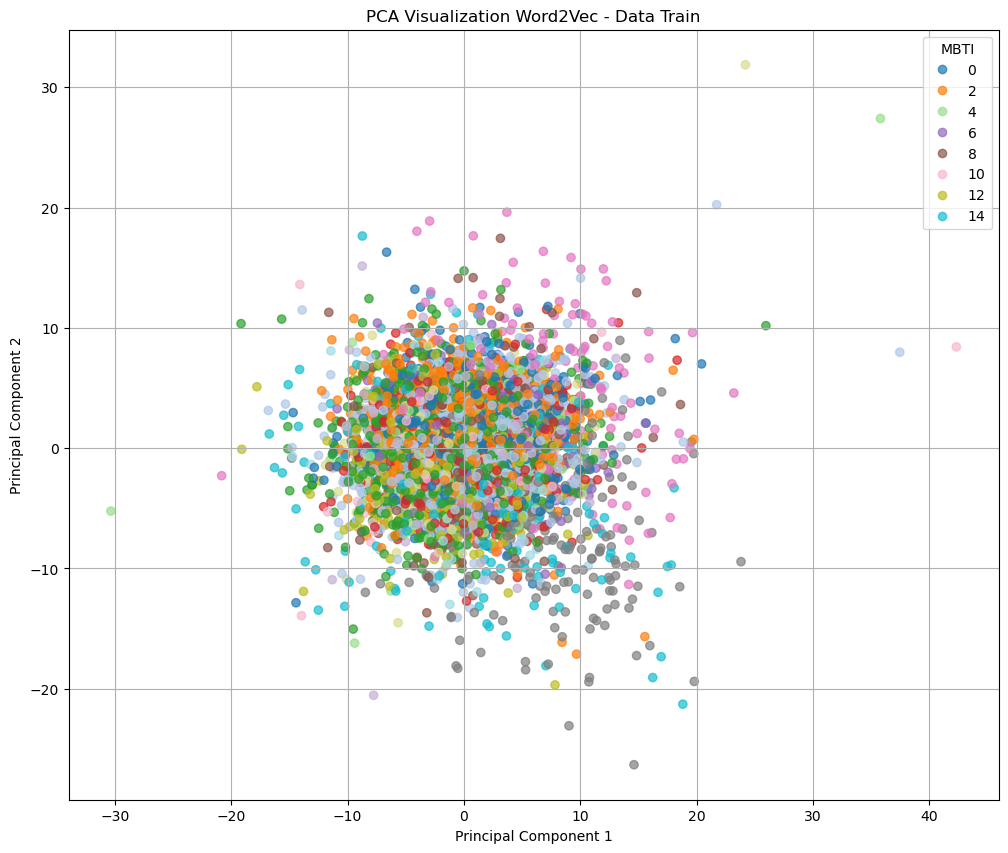

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

# Lakukan PCA dari vektor hasil Word2Vec (yang sudah di-scale)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

# Masukkan ke DataFrame dan tambahkan label MBTI
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['MBTI'] = y_train.values

# Visualisasikan
plt.figure(figsize=(12, 10))
scatter = plt.scatter(df_pca['PC1'], df_pca['PC2'], c=pd.factorize(df_pca['MBTI'])[0], cmap='tab20', alpha=0.7)
plt.legend(*scatter.legend_elements(), title="MBTI")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Visualization Word2Vec - Data Train")
plt.grid(True)
plt.show()


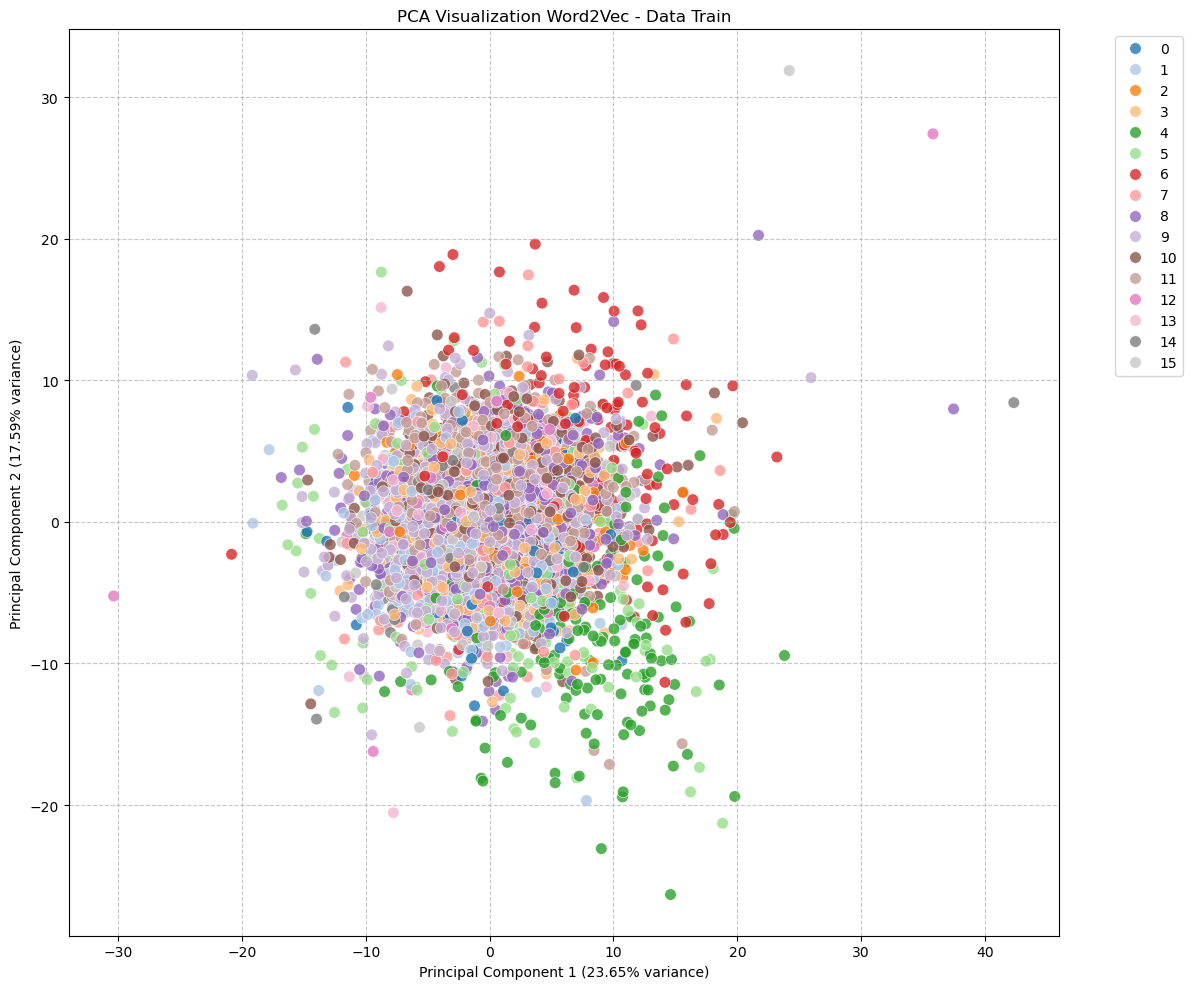

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

# Lakukan PCA dari vektor hasil Word2Vec (yang sudah di-scale)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['MBTI'] = y_train.values

plt.figure(figsize=(12, 10))
sns.scatterplot(
    data=df_pca,
    x='PC1', y='PC2',
    hue='MBTI',
    palette='tab20',
    alpha=0.8,
    s=70,
    edgecolor='white',
    linewidth=0.5,
)

plt.title("PCA Visualization Word2Vec - Data Train")
plt.xlabel(f"Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%} variance)")
plt.ylabel(f"Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%} variance)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

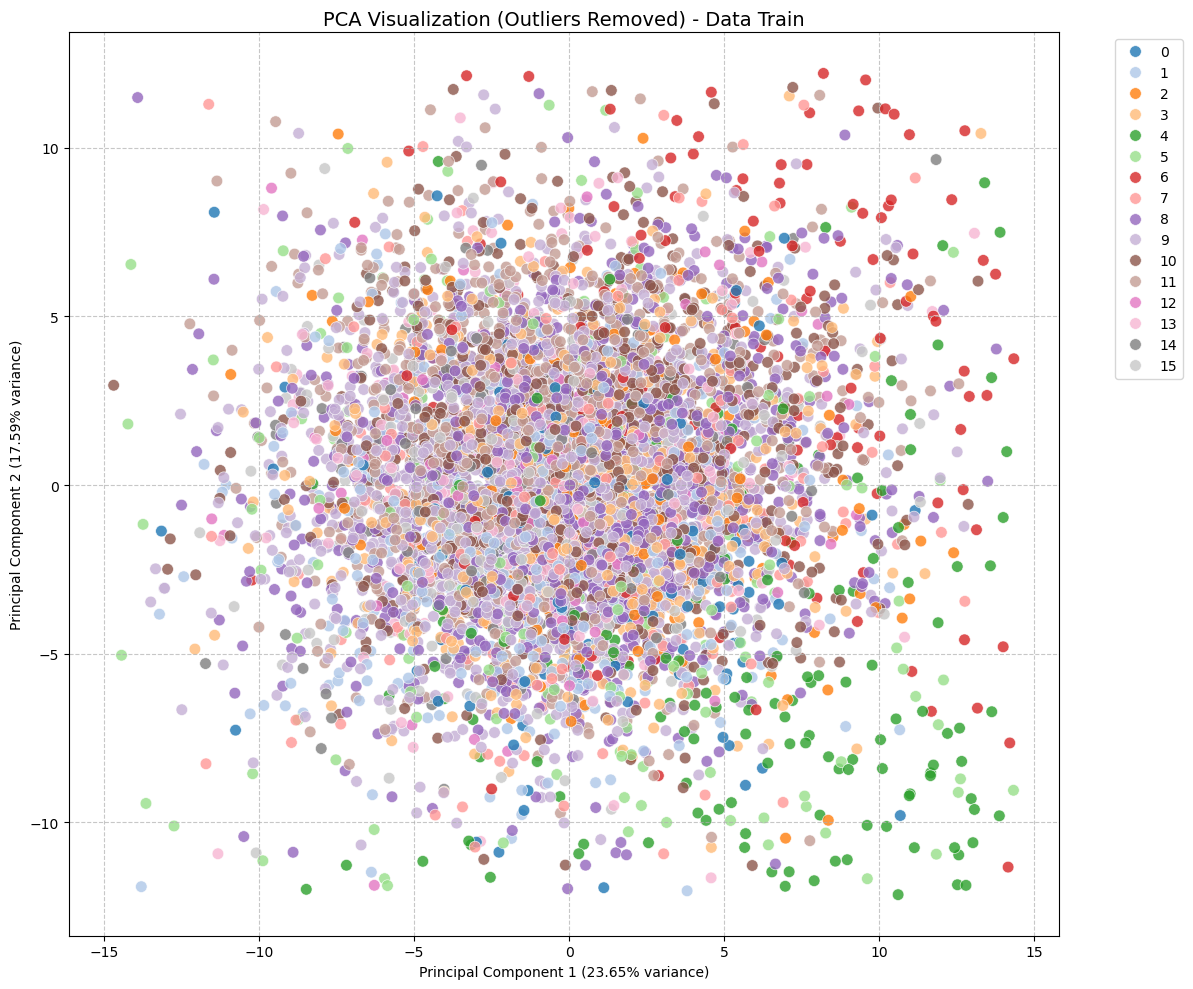

AttributeError: 'NoneType' object has no attribute 'split'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

# PCA no outlier dgn metode IQR
def remove_outliers_iqr(df, cols, factor=1.5):
    df_clean = df.copy()
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    return df_clean

# Visualisasi PCA dengan dan tanpa outlier
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['MBTI'] = y_train.values

df_pca_clean = remove_outliers_iqr(df_pca, ['PC1', 'PC2'], factor=2.0)

# Plot tanpa outlier
plt.figure(figsize=(12, 10))
plt.title("PCA Visualization (Outliers Removed) - Data Train", fontsize=14)

sns.scatterplot(
    data=df_pca_clean,
    x='PC1', y='PC2',
    hue='MBTI',
    palette='tab20',
    alpha=0.8,
    s=70,
    edgecolor='white',
    linewidth=0.5
)
plt.xlabel(f"Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%} variance)")
plt.ylabel(f"Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%} variance)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# VISUALISASI t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_train_scaled)
df_tsne = pd.DataFrame(X_tsne, columns=['t-SNE1', 't-SNE2'])
df_tsne['MBTI'] = y_train.values

plt.figure(figsize=(12, 10))
plt.title("t-SNE Visualization - Data Train", fontsize=14)
sns.scatterplot(
    data=df_tsne,
    x='t-SNE1', y='t-SNE2',
    hue='MBTI',
    palette='tab20',
    alpha=0.8,
    s=70,
    edgecolor='white',
    linewidth=0.5
)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# FACETGRID from seaborn
mbti_types = ['ENFJ', 'ENFP', 'ENTJ', 'ENTP', 'ESFJ', 'ESFP', 'ESTJ', 'ESTP',
              'INFJ', 'INFP', 'INTJ', 'INTP', 'ISFJ', 'ISFP', 'ISTJ', 'ISTP']

mbti_types.sort()

# Pemetaan dari nilai encoder numerik ke label type MBTI
mbti_mapping = {i: f"MBTI Type {i}: {mbti}" for i, mbti in enumerate(mbti_types)}

df_pca_clean_plot = df_pca_clean.copy()
df_pca_clean_plot['MBTI_Label'] = df_pca_clean_plot['MBTI'].map(mbti_mapping)

# FacetGrid
g = sns.FacetGrid(df_pca_clean_plot, col="MBTI_Label",
                  col_wrap=4, height=3,
                  sharex=False, sharey=False)
g.map_dataframe(sns.scatterplot, x="PC1", y="PC2")
g.set_titles("{col_name}")
g.fig.suptitle("PCA by Type - Data Train", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

#### Data Test

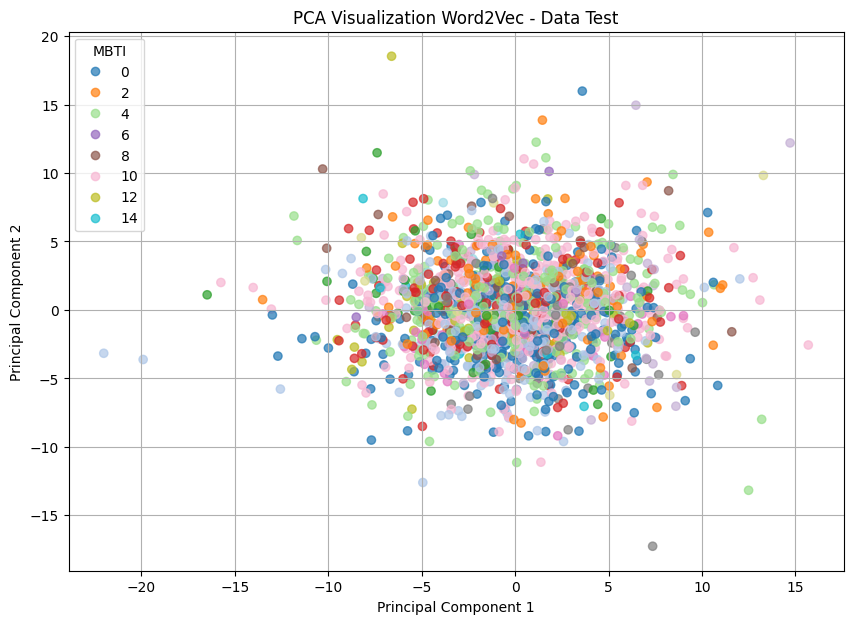

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

# Lakukan PCA dari vektor hasil Word2Vec (yang sudah di-scale)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test_scaled)

# Masukkan ke DataFrame dan tambahkan label MBTI
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['MBTI'] = y_test.values

# Visualisasikan
plt.figure(figsize=(10, 7))
scatter = plt.scatter(df_pca['PC1'], df_pca['PC2'], c=pd.factorize(df_pca['MBTI'])[0], cmap='tab20', alpha=0.7)
plt.legend(*scatter.legend_elements(), title="MBTI")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Visualization Word2Vec - Data Test")

plt.grid(True)
plt.show()

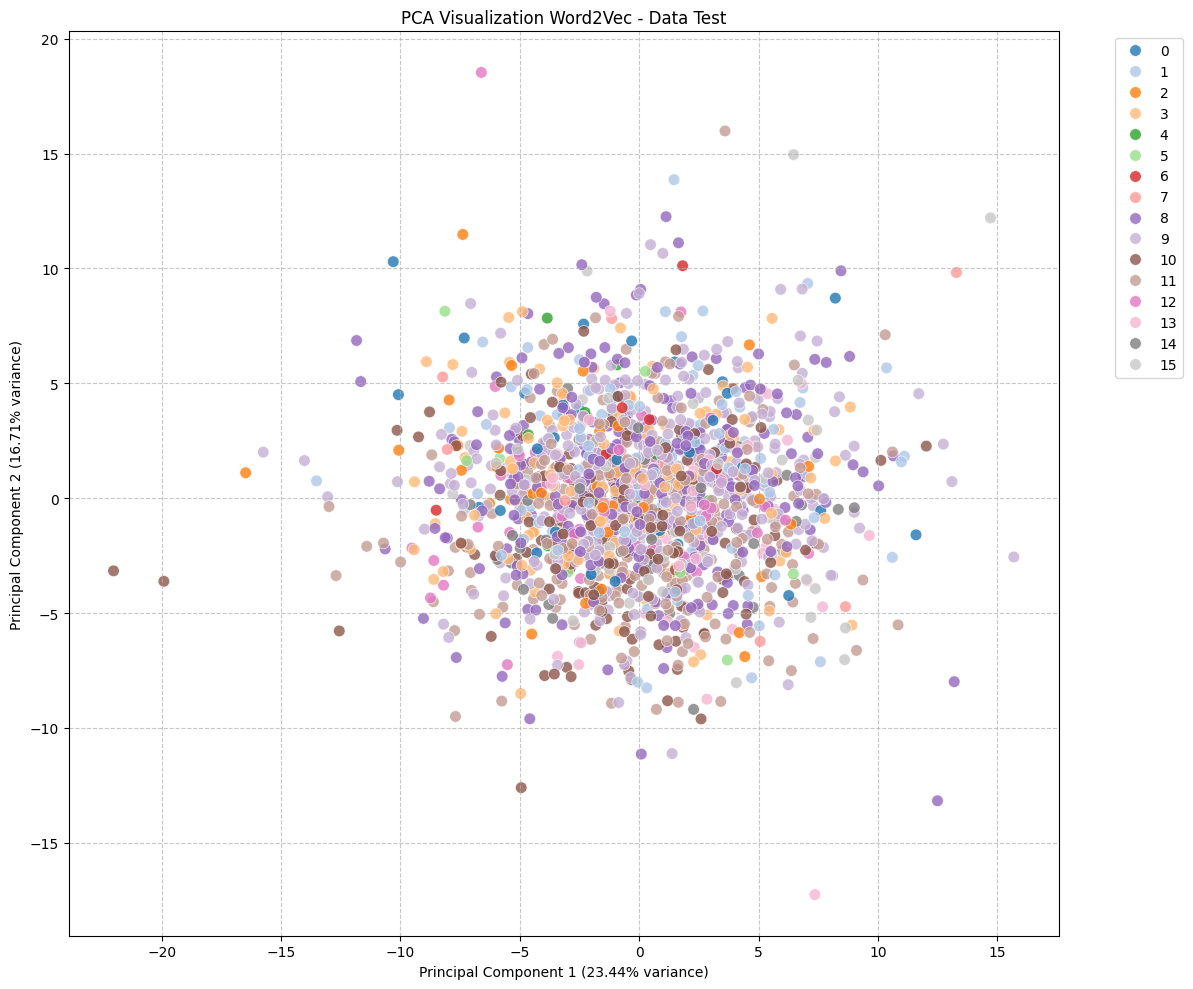

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

# Lakukan PCA dari vektor hasil Word2Vec (yang sudah di-scale)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test_scaled)

df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['MBTI'] = y_test.values

plt.figure(figsize=(12, 10))
sns.scatterplot(
    data=df_pca,
    x='PC1', y='PC2',
    hue='MBTI',
    palette='tab20',
    alpha=0.8,
    s=70,
    edgecolor='white',
    linewidth=0.5,
)

plt.title("PCA Visualization Word2Vec - Data Test")
plt.xlabel(f"Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%} variance)")
plt.ylabel(f"Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%} variance)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

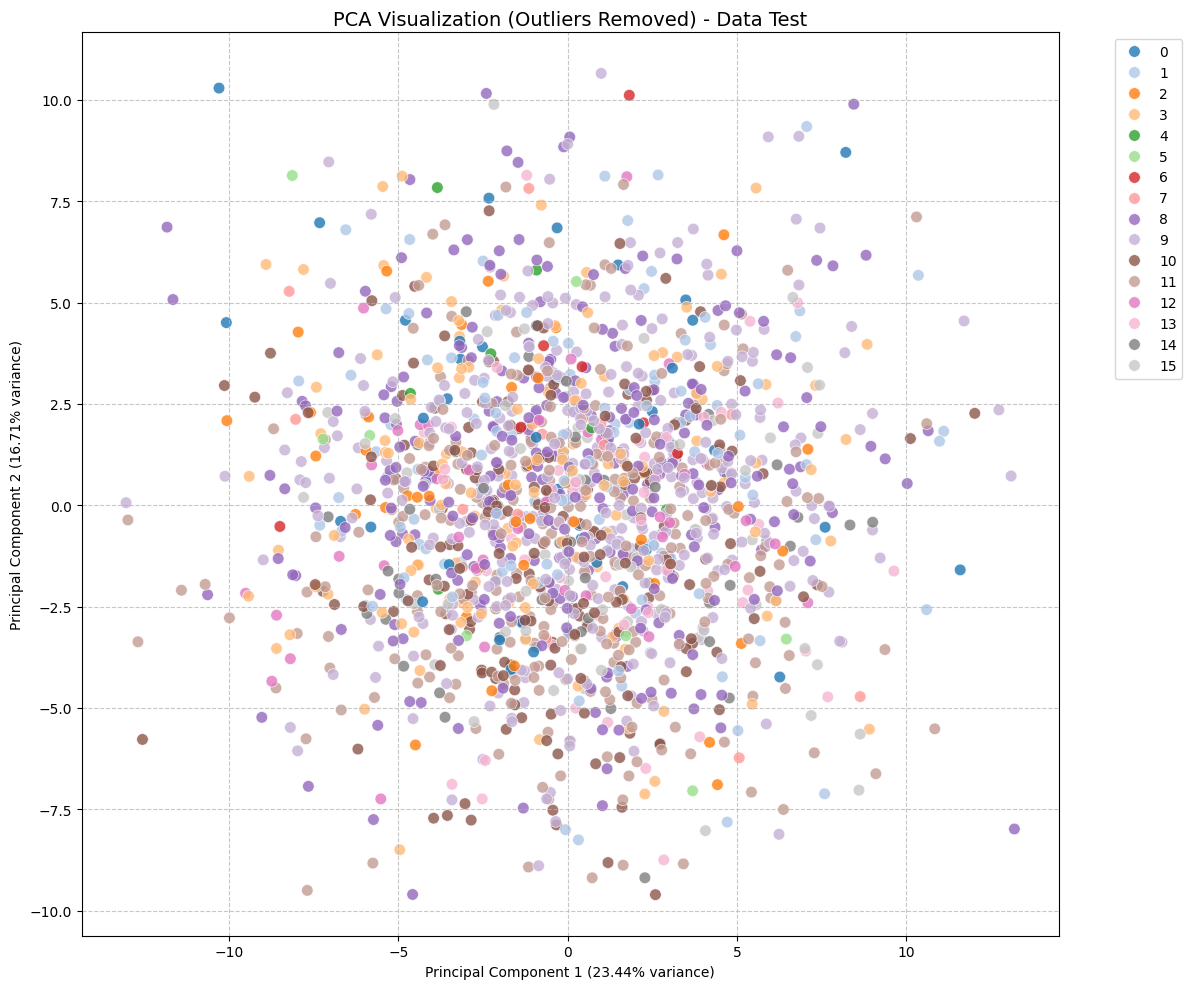

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


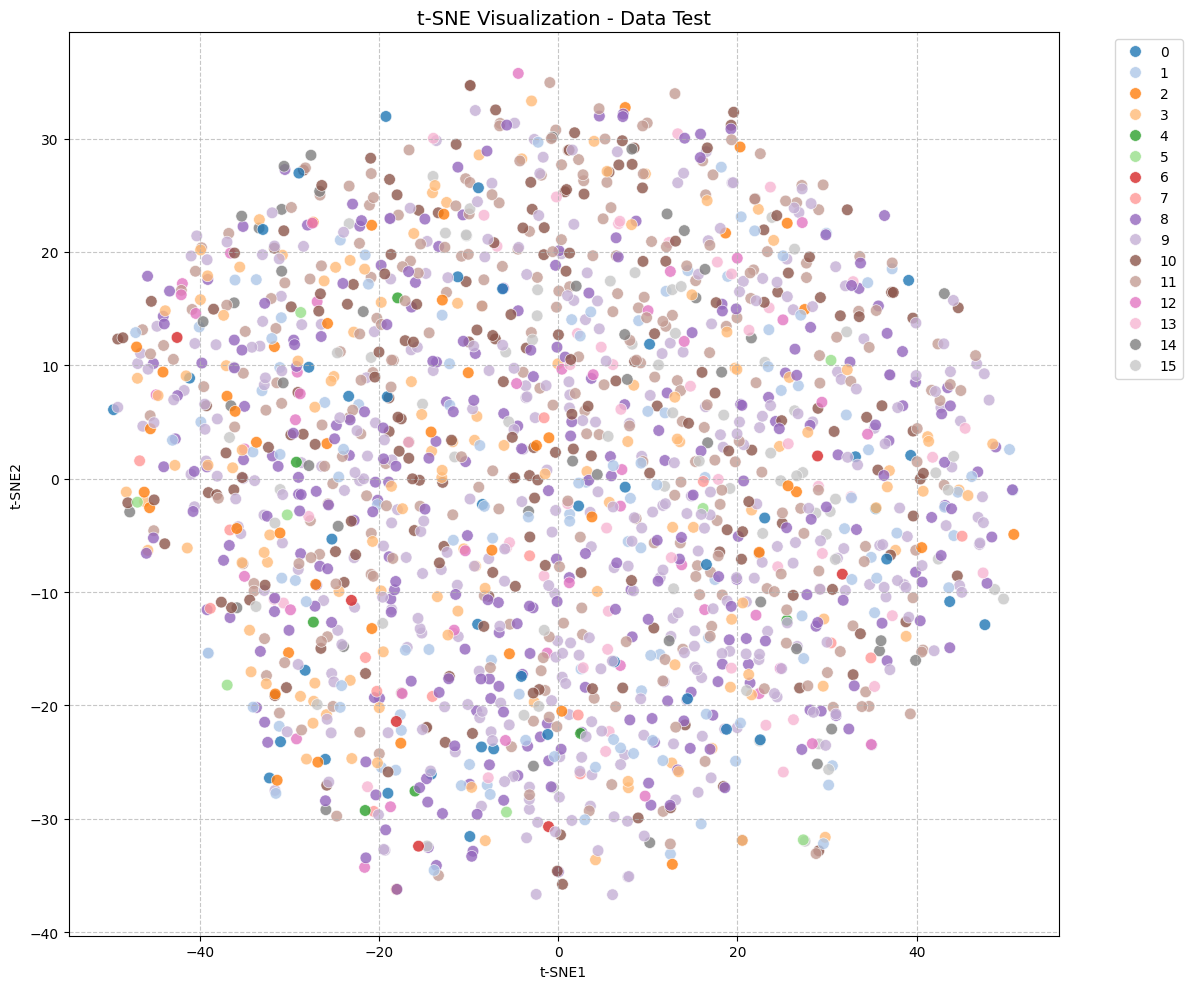

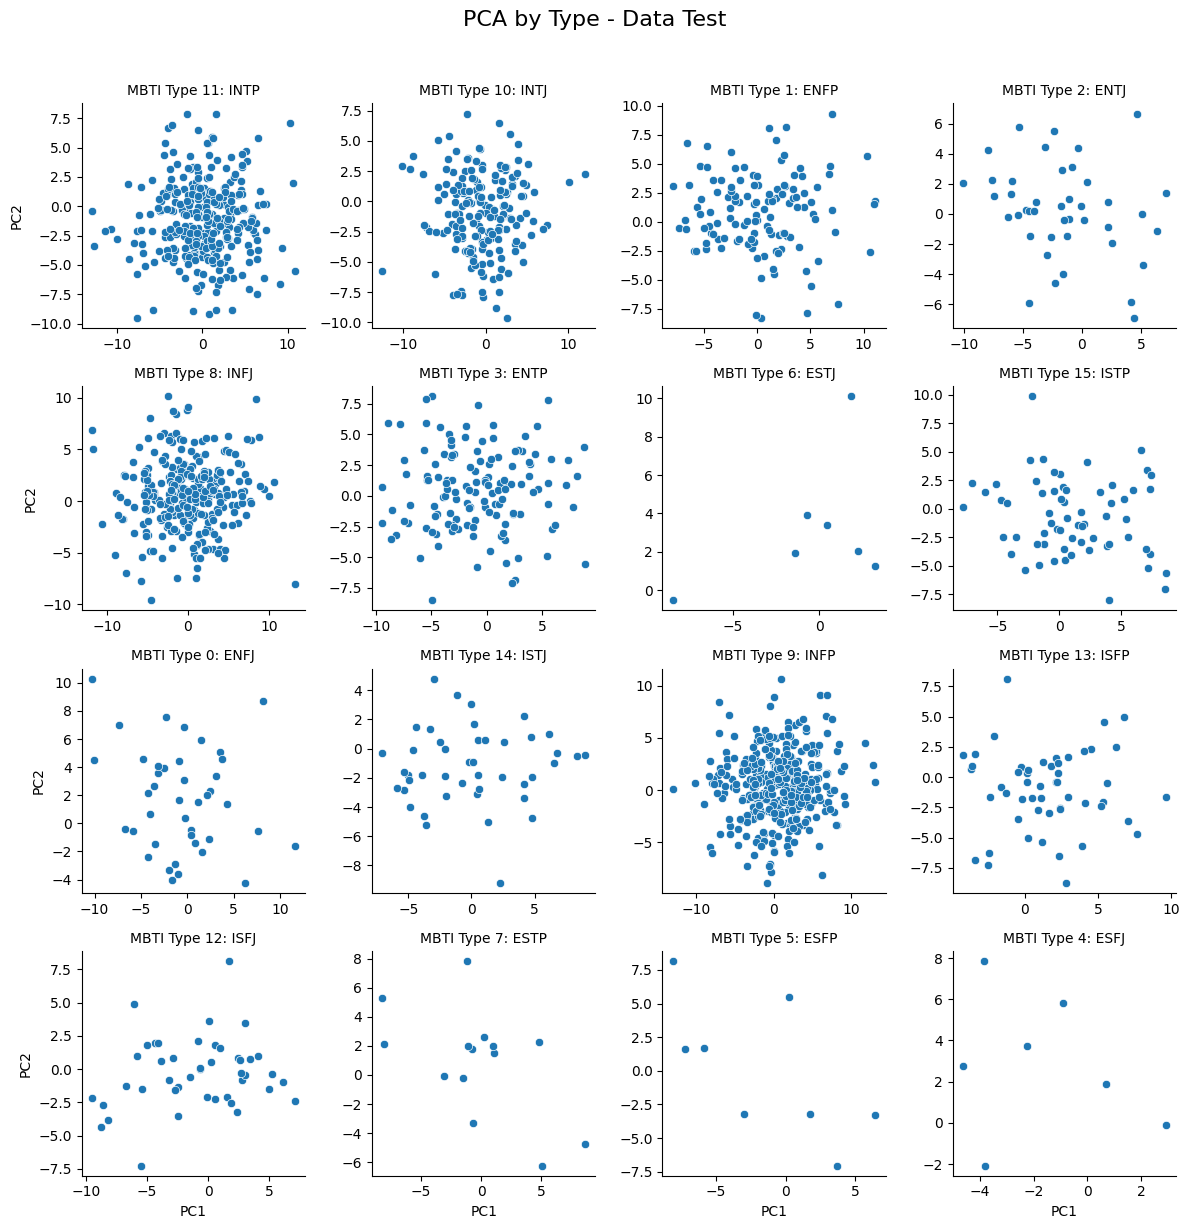

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

# PCA no outlier dgn metode IQR
def remove_outliers_iqr(df, cols, factor=1.5):
    df_clean = df.copy()
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    return df_clean

# Visualisasi PCA dengan dan tanpa outlier
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test_scaled)
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['MBTI'] = y_test.values

df_pca_clean = remove_outliers_iqr(df_pca, ['PC1', 'PC2'], factor=2.0)

# Plot tanpa outlier
plt.figure(figsize=(12, 10))
plt.title("PCA Visualization (Outliers Removed) - Data Test", fontsize=14)

sns.scatterplot(
    data=df_pca_clean,
    x='PC1', y='PC2',
    hue='MBTI',
    palette='tab20',
    alpha=0.8,
    s=70,
    edgecolor='white',
    linewidth=0.5
)
plt.xlabel(f"Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%} variance)")
plt.ylabel(f"Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%} variance)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# VISUALISASI t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_test_scaled)
df_tsne = pd.DataFrame(X_tsne, columns=['t-SNE1', 't-SNE2'])
df_tsne['MBTI'] = y_test.values

plt.figure(figsize=(12, 10))
plt.title("t-SNE Visualization - Data Test", fontsize=14)
sns.scatterplot(
    data=df_tsne,
    x='t-SNE1', y='t-SNE2',
    hue='MBTI',
    palette='tab20',
    alpha=0.8,
    s=70,
    edgecolor='white',
    linewidth=0.5
)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# FACETGRID from seaborn
mbti_types = ['ENFJ', 'ENFP', 'ENTJ', 'ENTP', 'ESFJ', 'ESFP', 'ESTJ', 'ESTP',
              'INFJ', 'INFP', 'INTJ', 'INTP', 'ISFJ', 'ISFP', 'ISTJ', 'ISTP']

mbti_types.sort()

# Pemetaan dari nilai encoder numerik ke label type MBTI
mbti_mapping = {i: f"MBTI Type {i}: {mbti}" for i, mbti in enumerate(mbti_types)}

df_pca_clean_plot = df_pca_clean.copy()
df_pca_clean_plot['MBTI_Label'] = df_pca_clean_plot['MBTI'].map(mbti_mapping)

# FacetGrid
g = sns.FacetGrid(df_pca_clean_plot, col="MBTI_Label",
                  col_wrap=4, height=3,
                  sharex=False, sharey=False)
g.map_dataframe(sns.scatterplot, x="PC1", y="PC2")
g.set_titles("{col_name}")
g.fig.suptitle("PCA by Type - Data Test", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

## TF-IDF

In [ ]:
# TF-IDF (Term Frequency-Inverse Document Frequency)
from sklearn.feature_extraction.text import TfidfVectorizer
import ast
import joblib

train_df = pd.read_csv('/content/drive/MyDrive/6. TUGAS AKHIR/0. DATASET/new_train_token.csv')
test_df = pd.read_csv('/content/drive/MyDrive/6. TUGAS AKHIR/0. DATASET/5_test_token.csv')

# Convert string token list ke list
train_df['token_posts'] = train_df['token_posts'].apply(ast.literal_eval)
test_df['token_posts'] = test_df['token_posts'].apply(ast.literal_eval)

train_texts = train_df['token_posts'].apply(lambda x: ' '.join(x))
test_texts = test_df['token_posts'].apply(lambda x: ' '.join(x))

# Buat dan fit vectorizer
vectorizer = TfidfVectorizer(min_df=3, max_df=0.75)
X_train_tfidf = vectorizer.fit_transform(train_texts)
X_test_tfidf = vectorizer.transform(test_texts)

y_train = train_df['type']
y_test = test_df['type']

# PERBAIKAN: Simpan instance vectorizer yang sudah di-fit, bukan class-nya
joblib.dump(vectorizer, '/content/drive/MyDrive/6. TUGAS AKHIR/1. MODEL/tfidf_vectorizer.pkl')

print(f"Train shape: {X_train_tfidf.shape}")
print(f"Test shape: {X_test_tfidf.shape}")
print("Vectorizer saved successfully!")

Train shape: (7763, 30065)
Test shape: (1735, 30065)
Vectorizer saved successfully!


In [ ]:
# import joblib
# joblib.dump(TfidfVectorizer, '/content/drive/MyDrive/6. TUGAS AKHIR/1. MODEL/tfidf_vectorizer.pkl')

['/content/drive/MyDrive/6. TUGAS AKHIR/1. MODEL/tfidf_vectorizer.pkl']

In [ ]:
print(X_train_tfidf.shape)  # (jumlah dokumen, jumlah fitur/term)
print(X_test_tfidf.shape)  # (jumlah dokumen, jumlah fitur/term)

(7763, 30065)
(1735, 30065)


In [ ]:
import pandas as pd

feature_names = vectorizer.get_feature_names_out()
tfidf_train = pd.DataFrame(X_train_tfidf.toarray(), columns=feature_names)
tfidf_test = pd.DataFrame(X_test_tfidf.toarray(), columns=feature_names)

tfidf_train.to_csv(r"C:\Users\admin\Downloads\X_train_tfidf.csv", index=False)
tfidf_test.to_csv(r"C:\Users\admin\Downloads\X_test_tfidf.csv", index=False)
# y_train.to_csv(r"C:\Users\admin\Downloads\y_train_tfidf.csv", index=False)
# y_test.to_csv(r"C:\Users\admin\Downloads\y_test_tfidf.csv", index=False)

tfidf_train

aa  aaa  aaaaaaaaah  aaaaaand  aaaaall  aaaaand  aaaah  aaaand  aaadd  \
0     0.0  0.0         0.0       0.0      0.0      0.0    0.0     0.0    0.0   
1     0.0  0.0         0.0       0.0      0.0      0.0    0.0     0.0    0.0   
2     0.0  0.0         0.0       0.0      0.0      0.0    0.0     0.0    0.0   
3     0.0  0.0         0.0       0.0      0.0      0.0    0.0     0.0    0.0   
4     0.0  0.0         0.0       0.0      0.0      0.0    0.0     0.0    0.0   
...   ...  ...         ...       ...      ...      ...    ...     ...    ...   
7592  0.0  0.0         0.0       0.0      0.0      0.0    0.0     0.0    0.0   
7593  0.0  0.0         0.0       0.0      0.0      0.0    0.0     0.0    0.0   
7594  0.0  0.0         0.0       0.0      0.0      0.0    0.0     0.0    0.0   
7595  0.0  0.0         0.0       0.0      0.0      0.0    0.0     0.0    0.0   
7596  0.0  0.0         0.0       0.0      0.0      0.0    0.0     0.0    0.0   

      aaah  ...   zu  zucchini  zuckerberg  zuflex  zuko  zulban  zumba  \
0      0.0  ...  0.0       0.0         0.0     0.0   0.0     0.0    0.0   
1      0.0  ...  0.0       0.0         0.0     0.0   0.0     0.0    0.0   
2      0.0  ...  0.0       0.0         0.0     0.0   0.0     0.0    0.0   
3      0.0  ...  0.0       0.0         0.0     0.0   0.0     0.0    0.0   
4      0.0  ...  0.0       0.0         0.0     0.0   0.0     0.0    0.0   
...    ...  ...  ...       ...         ...     ...   ...     ...    ...   
7592   0.0  ...  0.0       0.0         0.0     0.0   0.0     0.0    0.0   
7593   0.0  ...  0.0       0.0         0.0     0.0   0.0     0.0    0.0   
7594   0.0  ...  0.0       0.0         0.0     0.0   0.0     0.0    0.0   
7595   0.0  ...  0.0       0.0         0.0     0.0   0.0     0.0    0.0   
7596   0.0  ...  0.0       0.0         0.0     0.0   0.0     0.0    0.0   

      zylinder  zynthaxx  zzz  
0          0.0       0.0  0.0  
1          0.0       0.0  0.0  
2          0.0       0.0  0.0  
3          0.0       0.0  0.0  
4          0.0       0.0  0.0  
...        ...       ...  ...  
7592       0.0       0.0  0.0  
7593       0.0       0.0  0.0  
7594       0.0       0.0  0.0  
7595       0.0       0.0  0.0  
7596       0.0       0.0  0.0  

[7597 rows x 29874 columns]

In [ ]:
# Mendapatkan daftar semua kata dalam vocabulary
feature_names = vectorizer.get_feature_names_out()

# Indeks dokumen yang ingin dianalisis dari dataset test
test_doc_index = 878  # Ganti dengan indeks yang diinginkan

# Pastikan indeks valid
if test_doc_index >= X_test_tfidf.shape[0]:
    print(f"Indeks {test_doc_index} melebihi jumlah dokumen dalam dataset test ({X_test_tfidf.shape[0]})")
    print("Gunakan indeks yang lebih kecil")
    # Tampilkan indeks maksimum yang tersedia
    print(f"Indeks maksimum yang tersedia: {X_test_tfidf.shape[0] - 1}")
    exit()

# Ambil vektor TF-IDF untuk dokumen test yang dipilih
doc_vector = X_test_tfidf[test_doc_index].toarray()[0]
kepribadian = y_test.iloc[test_doc_index]

# Dapatkan kata-kata dan nilai TF-IDF mereka dalam dokumen ini
word_tfidf_pairs = [(feature_names[i], value) for i, value in enumerate(doc_vector) if value > 0]

# Urutkan berdasarkan nilai TF-IDF tertinggi
word_tfidf_pairs.sort(key=lambda x: x[1], reverse=True)

# Tampilkan informasi
print(f"Analisis dokumen test ke-{test_doc_index}")
print(f"Tipe kepribadian: {kepribadian}")
print(f"Jumlah kata unik dengan nilai TF-IDF > 0: {len(word_tfidf_pairs)}")

# Tampilkan teks asli dari dokumen
print(f"\nTeks asli: {test_texts.iloc[test_doc_index][:150]}...")

print("\nTop 20 kata dengan nilai TF-IDF tertinggi:")
for word, tfidf in word_tfidf_pairs[:20]:
    print(f"Kata: '{word}', TF-IDF: {tfidf}")

# Cari kata dengan nilai TF-IDF spesifik
target_value = 0.46333773079527013
epsilon = 0.0001  # Toleransi untuk perbandingan float

print("\nMencari kata dengan nilai TF-IDF mendekati", target_value)
found = False
for word, tfidf in word_tfidf_pairs:
    if abs(tfidf - target_value) < epsilon:
        print(f"Kata: '{word}', TF-IDF: {tfidf}")
        found = True

if not found:
    print("Tidak ditemukan kata dengan nilai TF-IDF yang mendekati target")

    # Cari nilai yang paling mendekati
    closest_word = min(word_tfidf_pairs, key=lambda x: abs(x[1] - target_value))
    print(f"Kata dengan nilai TF-IDF terdekat: '{closest_word[0]}', nilai: {closest_word[1]}")

# Tampilkan semua nilai spesifik yang disebutkan dalam prompt awal
specific_values = [0.03034002474541748, 0.03259977278164968, 0.027501179138305177,
                  0.06244882588349817, 0.02023302097898542, 0.05591637400958513,
                  0.05600979289305252, 0.04187568068061377, 0.020044392283720913,
                  0.1425659737805497, 0.08441241795844778, 0.04467079794727708,
                  0.1631791446795548, 0.46333773079527013]

print("\nMencari nilai TF-IDF spesifik dari prompt:")
for target in specific_values:
    closest_word = min(word_tfidf_pairs, key=lambda x: abs(x[1] - target))
    diff = abs(closest_word[1] - target)
    if diff < 0.001:  # Lebih dekat dari 0.001
        print(f"Nilai {target}: Kata '{closest_word[0]}' dengan nilai {closest_word[1]}")
    else:
        print(f"Nilai {target}: Tidak ditemukan kata yang mendekati (terdekat: '{closest_word[0]}' dengan nilai {closest_word[1]}, selisih {diff})")

Analisis dokumen test ke-878
Tipe kepribadian: 8
Jumlah kata unik dengan nilai TF-IDF > 0: 228

Teks asli: enfp intj moments sportscenter top ten play prank what lifechange experience life on repeat today may perc experience immerse you the last thing infj ...

Top 20 kata dengan nilai TF-IDF tertinggi:
Kata: 'ban', TF-IDF: 0.4349919903693863
Kata: 'backyard', TF-IDF: 0.16712511740868036
Kata: 'moderation', TF-IDF: 0.16404729519301414
Kata: 'sim', TF-IDF: 0.1551748739107438
Kata: 'artist', TF-IDF: 0.1460134820129529
Kata: 'diary', TF-IDF: 0.14205194411153071
Kata: 'game', TF-IDF: 0.1199726794514309
Kata: 'signature', TF-IDF: 0.11610674918311292
Kata: 'dunce', TF-IDF: 0.1157338102834661
Kata: 'moments', TF-IDF: 0.1157338102834661
Kata: 'workin', TF-IDF: 0.11268078533318698
Kata: 'beetle', TF-IDF: 0.10807721006771007
Kata: 'lifechange', TF-IDF: 0.10319722363489127
Kata: 'marshmellow', TF-IDF: 0.10189320048367569
Kata: 'grumble', TF-IDF: 0.10070272061839193
Kata: 'roach', TF-IDF: 0.099607

In [ ]:
# Mendapatkan daftar semua kata dalam vocabulary
feature_names = vectorizer.get_feature_names_out()

# Fungsi untuk menganalisis kalimat baru
def analyze_sentence(sentence, vectorizer, feature_names):
    # Transform kalimat menjadi vektor TF-IDF
    sentence_vector = vectorizer.transform([sentence]).toarray()[0]

    # Dapatkan kata-kata dan nilai TF-IDF mereka dalam kalimat ini
    word_tfidf_pairs = [(feature_names[i], value) for i, value in enumerate(sentence_vector) if value > 0]

    # Urutkan berdasarkan nilai TF-IDF tertinggi
    word_tfidf_pairs.sort(key=lambda x: x[1], reverse=True)

    return word_tfidf_pairs

# Kalimat yang ingin dianalisis
# Anda bisa menggunakan kalimat dari contoh awal
# sample_sentence = "enfp intj moments sportscenter top ten play prank what lifechange experience life on repeat today may perc experience immerse you the last thing infj friend post facebook commit"

# Atau memilih kalimat dari dataset
sample_index = 878  # Ganti dengan indeks yang diinginkan
sample_sentence = test_texts.iloc[sample_index]

print(f"Menganalisis kalimat: \n{sample_sentence}\n")

# Analisis kalimat
word_tfidf_pairs = analyze_sentence(sample_sentence, vectorizer, feature_names)

print(f"Jumlah kata dengan nilai TF-IDF > 0: {len(word_tfidf_pairs)}")

# Tampilkan semua kata beserta nilai TF-IDF mereka
print("\nDaftar kata dengan nilai TF-IDF:")
for word, tfidf in word_tfidf_pairs:
    print(f"Kata: '{word}', TF-IDF: {tfidf}")

# Jika ingin cek nilai spesifik
target_values = [0.03034002474541748, 0.03259977278164968, 0.027501179138305177,
               0.06244882588349817, 0.02023302097898542, 0.05591637400958513,
               0.05600979289305252, 0.04187568068061377, 0.020044392283720913,
               0.1425659737805497, 0.08441241795844778, 0.04467079794727708,
               0.1631791446795548]

print("\nMencari nilai TF-IDF spesifik dari prompt:")
for target in target_values:
    epsilon = 0.0001  # Toleransi untuk perbandingan float
    found = False
    for word, tfidf in word_tfidf_pairs:
        if abs(tfidf - target) < epsilon:
            print(f"Nilai {target}: Kata '{word}'")
            found = True
            break

    if not found:
        # Cari yang paling mendekati
        if word_tfidf_pairs:
            closest_word = min(word_tfidf_pairs, key=lambda x: abs(x[1] - target))
            diff = abs(closest_word[1] - target)
            print(f"Nilai {target}: Tidak ditemukan (terdekat: '{closest_word[0]}' dengan nilai {closest_word[1]}, selisih {diff})")
        else:
            print(f"Nilai {target}: Tidak ditemukan kata dengan TF-IDF > 0 dalam kalimat ini")

Menganalisis kalimat: 
enfp intj moments sportscenter top ten play prank what lifechange experience life on repeat today may perc experience immerse you the last thing infj friend post facebook commit suicide next day rest peace hello enfj sorry hear distress its natural relationship perfection time every moment existence try figure hard time time growth as welcome stuff game set match prozac wellbrutin least thirty minute move leg and I mean move sit desk chair weed moderation maybe try edible healthy alternative basically come three item determine type or whichever type want do would likely use give type cognitive function whatnot leave by all thing moderation sim indeed video game good one that note good one somewhat subjective I completely promote death give sim dear enfp what favorite video game grow now current favorite video game cool it appear late sad there s someone everyone wait I think confidence good thing I cherish time solitude bc revel within inner world whereas time wo

### Visualization

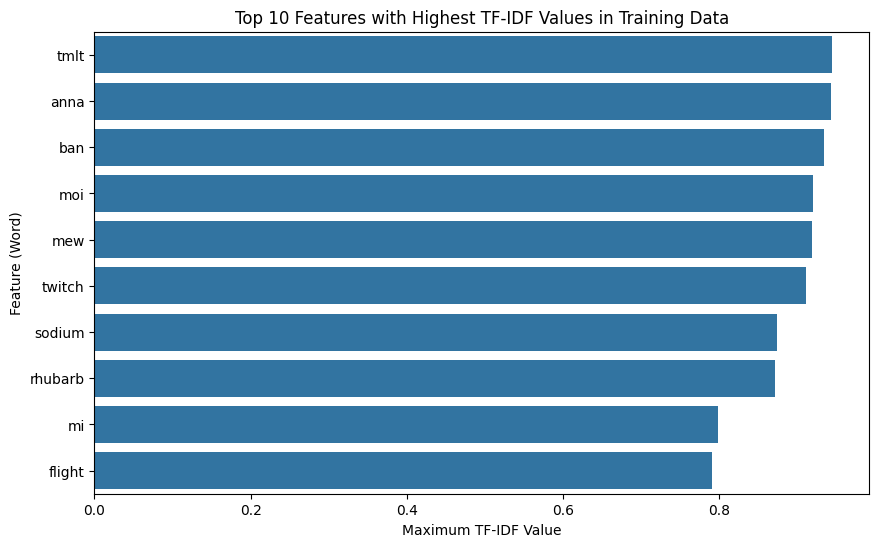

In [ ]:
# visualisasi nilai tertinggi untuk data train tf-idf

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

tfidf_train = pd.read_csv('/content/drive/MyDrive/6. TUGAS AKHIR/0. DATASET/X_train_tfidf.csv')

# Find the maximum TF-IDF value for each feature (column)
max_tfidf_values = tfidf_train.max()

# Sort the features by their maximum TF-IDF values in descending order
sorted_max_tfidf = max_tfidf_values.sort_values(ascending=False)

# top N features (e.g., top 10)
top_n = 10
top_features = sorted_max_tfidf.head(top_n)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index)
plt.xlabel("Maximum TF-IDF Value")
plt.ylabel("Feature (Word)")
plt.title(f"Top {top_n} Features with Highest TF-IDF Values in Training Data")
plt.show()


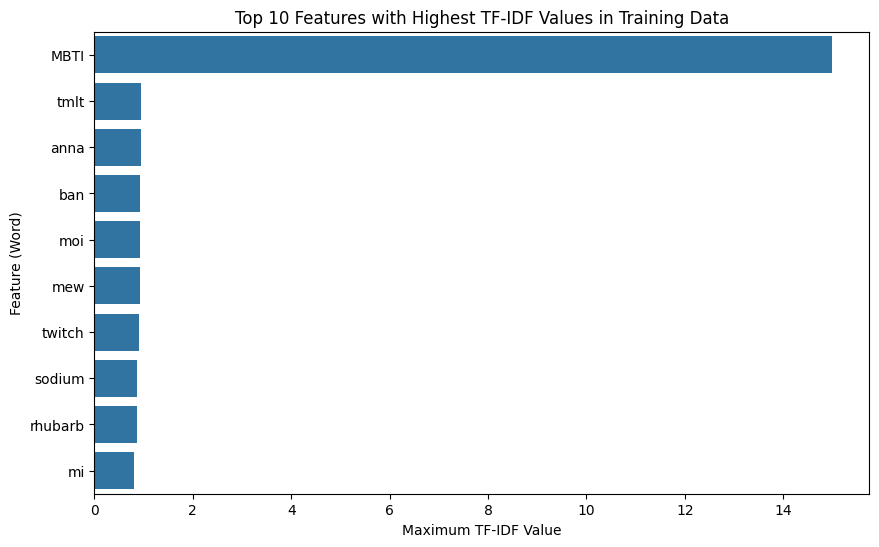

In [ ]:
# visualisasi nilai tertinggi untuk data train tf-idf

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

tfidf_test = pd.read_csv('/content/drive/MyDrive/6. TUGAS AKHIR/0. DATASET/X_test_tfidf.csv')

# Find the maximum TF-IDF value for each feature (column)
max_tfidf_values = tfidf_train.max()

# Sort the features by their maximum TF-IDF values in descending order
sorted_max_tfidf = max_tfidf_values.sort_values(ascending=False)

# top N features (e.g., top 10)
top_n = 10
top_features = sorted_max_tfidf.head(top_n)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index)
plt.xlabel("Maximum TF-IDF Value")
plt.ylabel("Feature (Word)")
plt.title(f"Top {top_n} Features with Highest TF-IDF Values in Training Data")
plt.show()


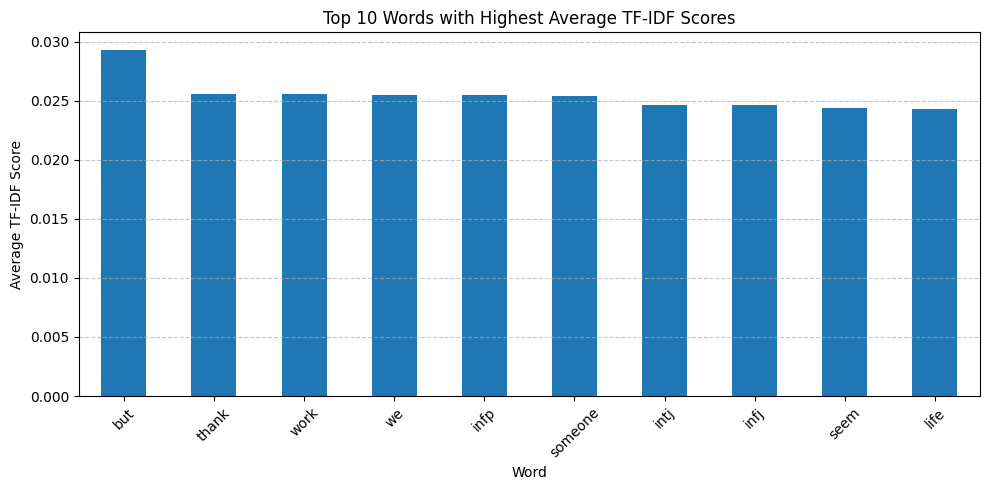

In [ ]:
import matplotlib.pyplot as plt

mean_scores = tfidf_train.mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 5))
mean_scores.plot(kind='bar')
plt.title("Top 10 Words with Highest Average TF-IDF Scores")
plt.ylabel("Average TF-IDF Score")
plt.xlabel("Word")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


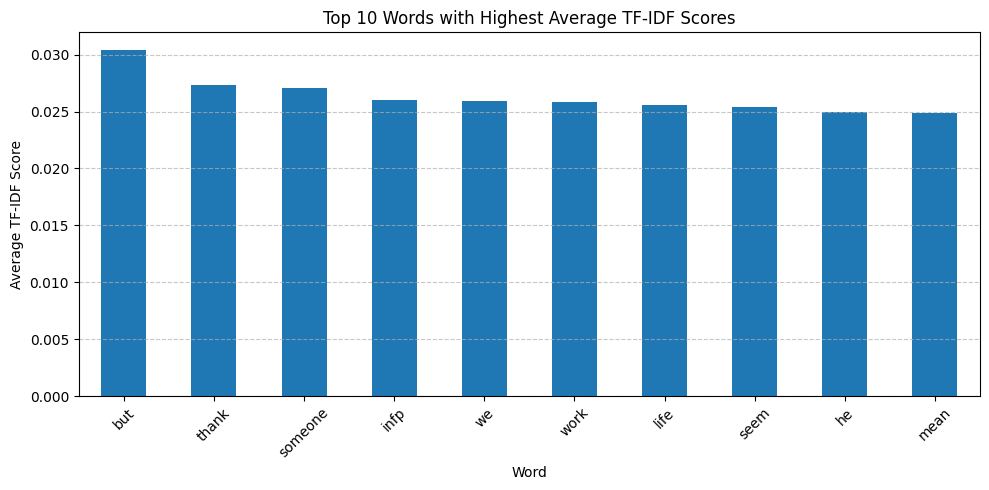

In [ ]:
import matplotlib.pyplot as plt

mean_scores = tfidf_test.mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 5))
mean_scores.plot(kind='bar')
plt.title("Top 10 Words with Highest Average TF-IDF Scores")
plt.ylabel("Average TF-IDF Score")
plt.xlabel("Word")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


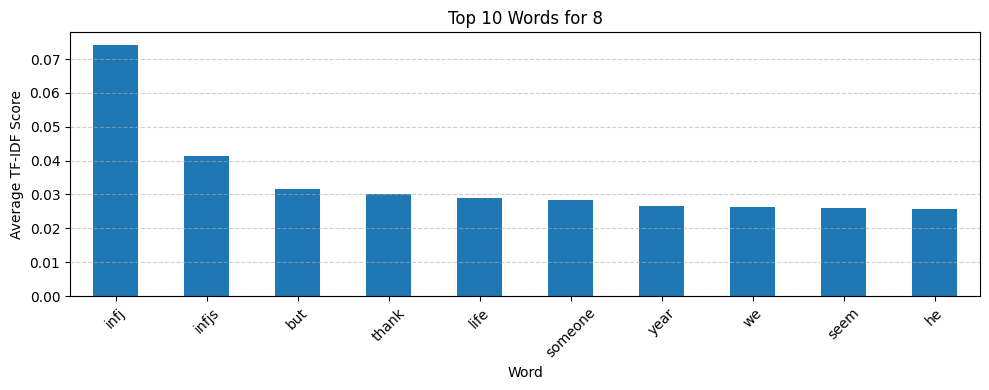

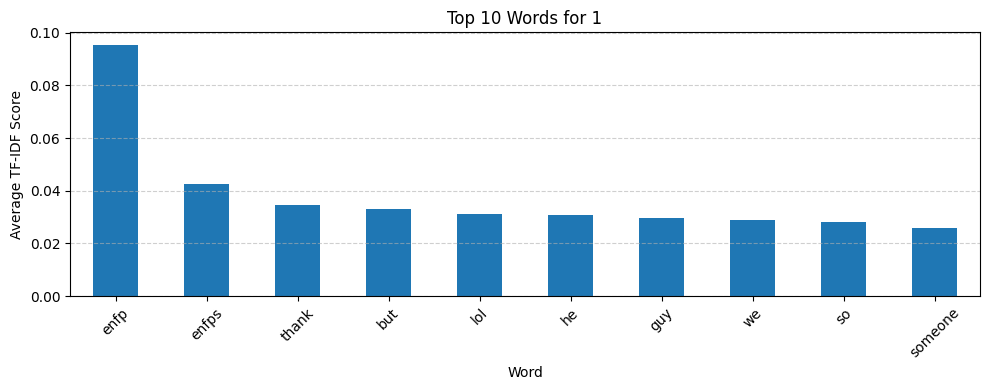

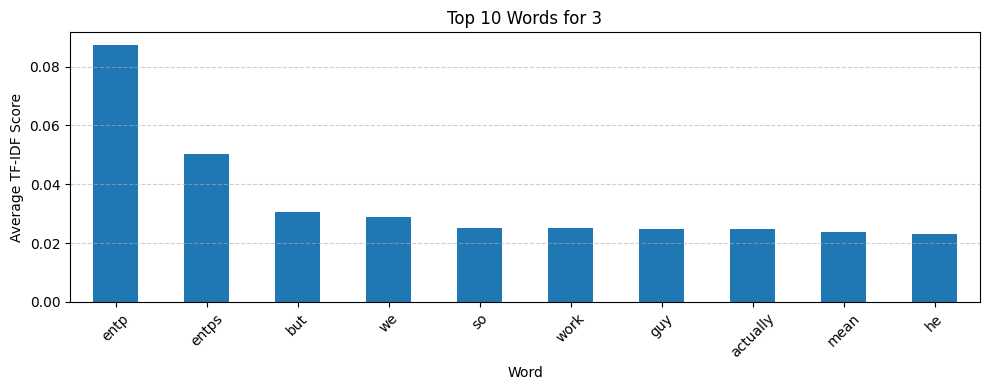

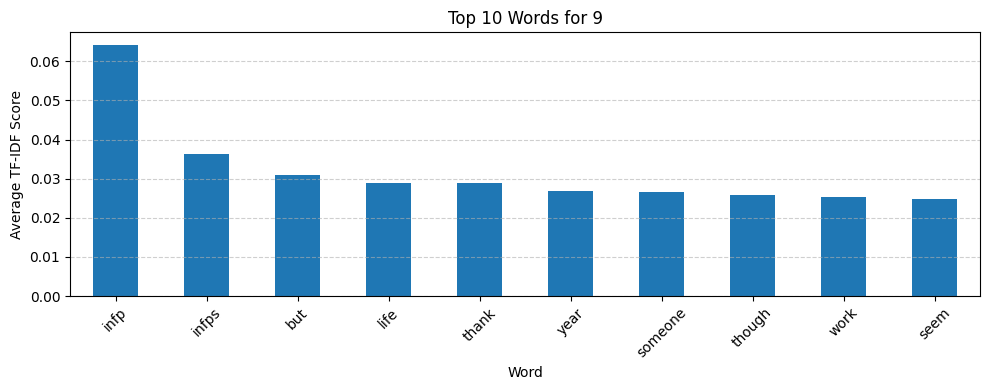

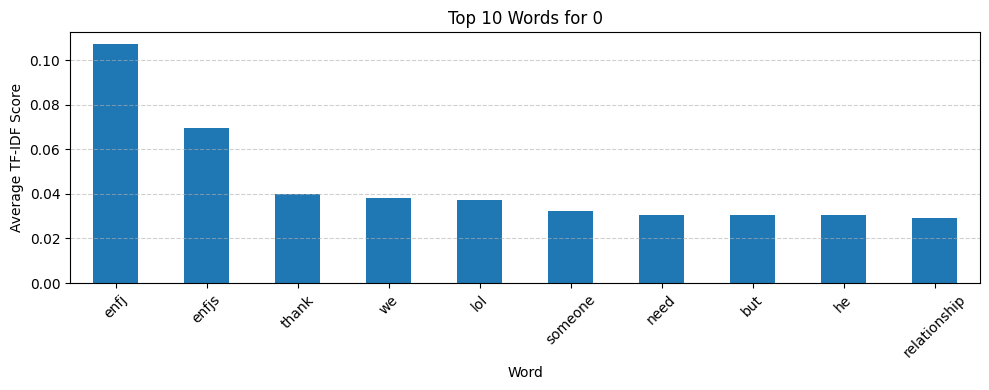

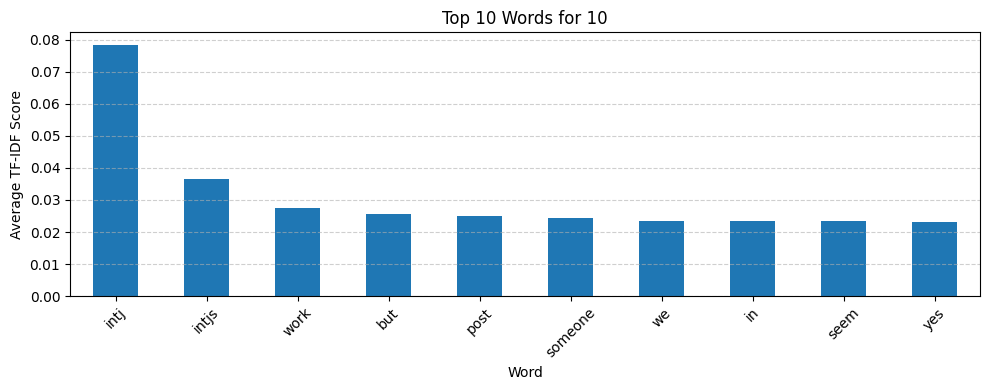

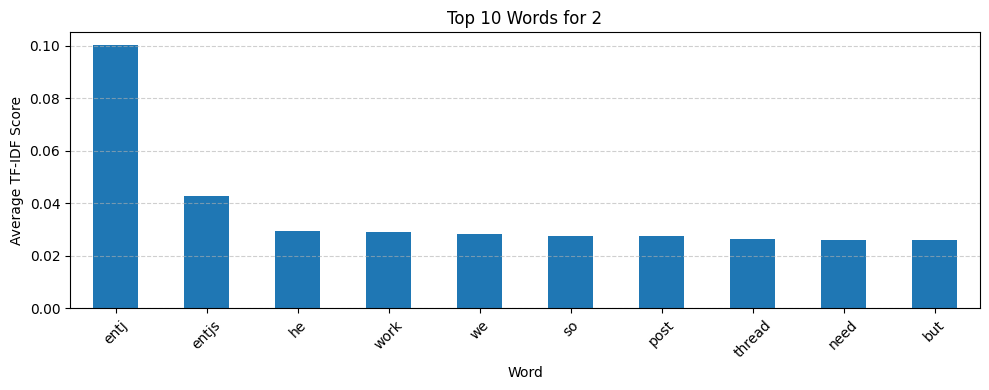

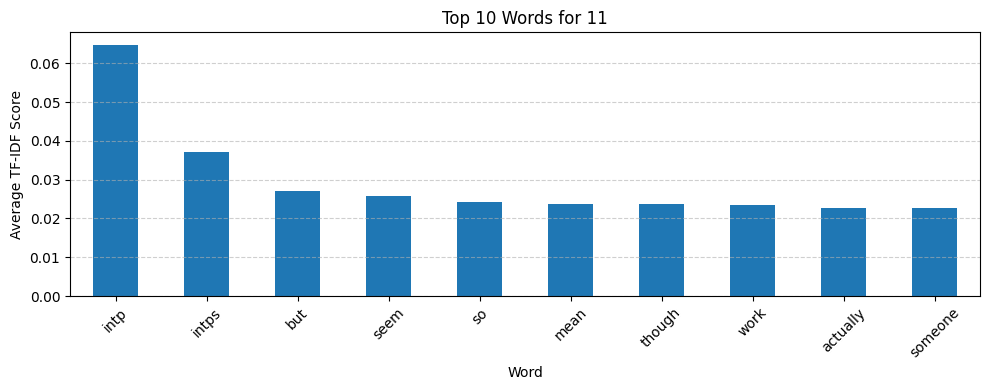

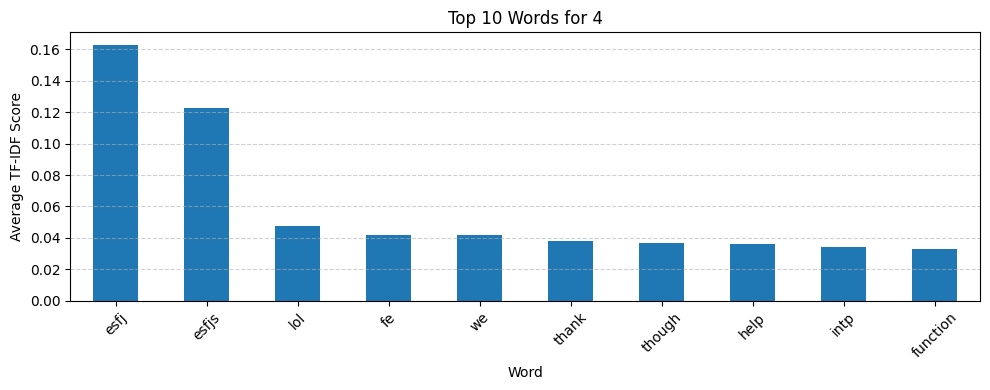

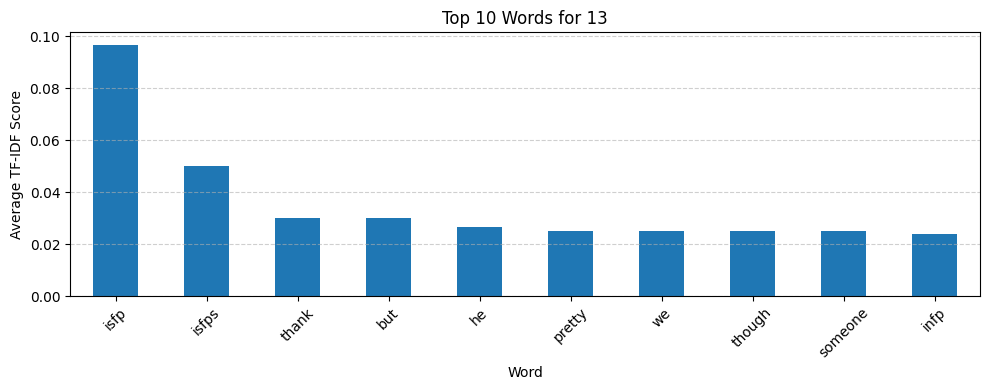

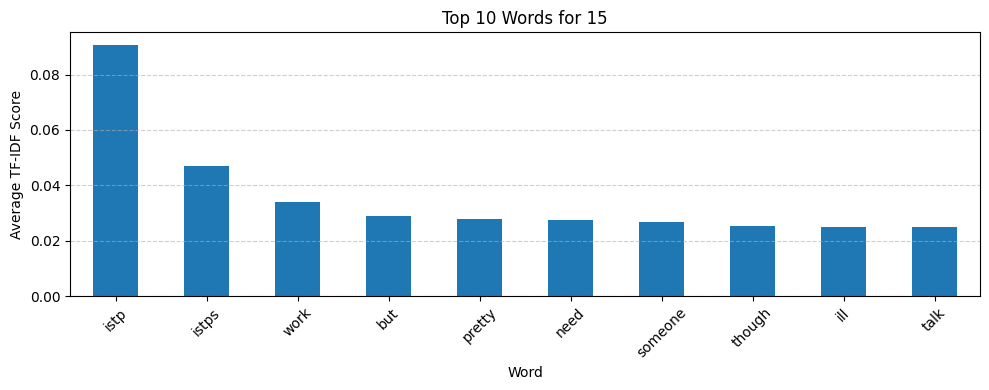

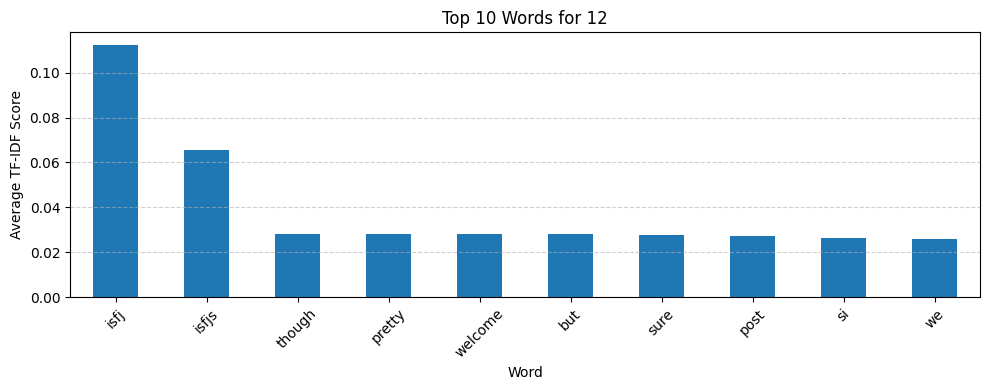

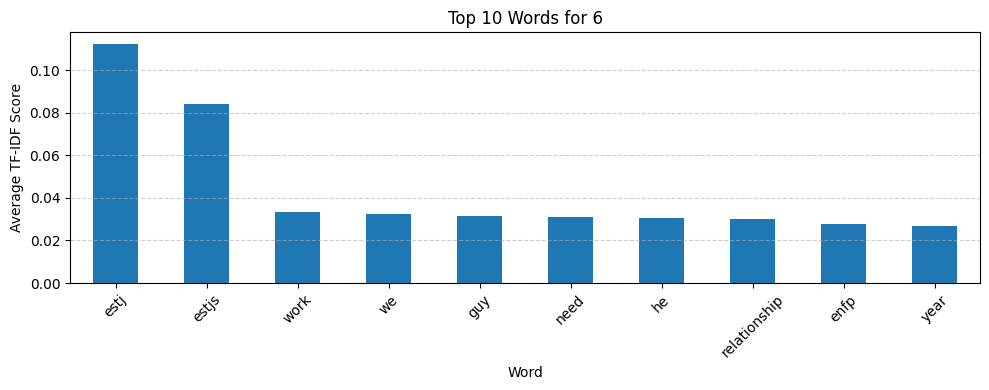

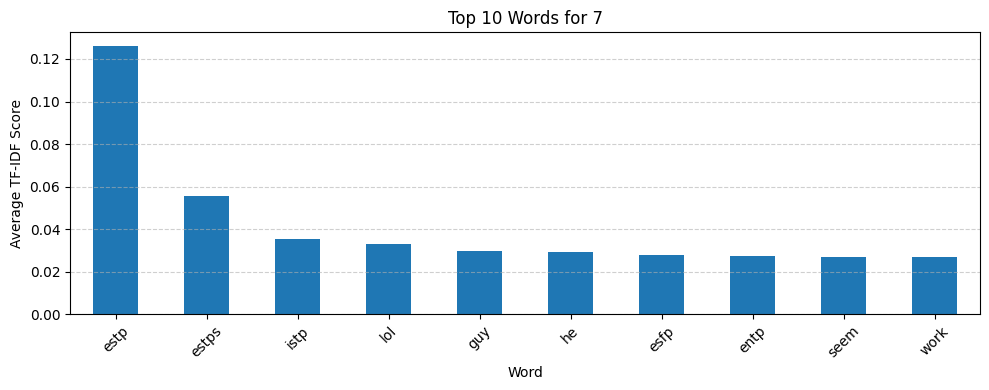

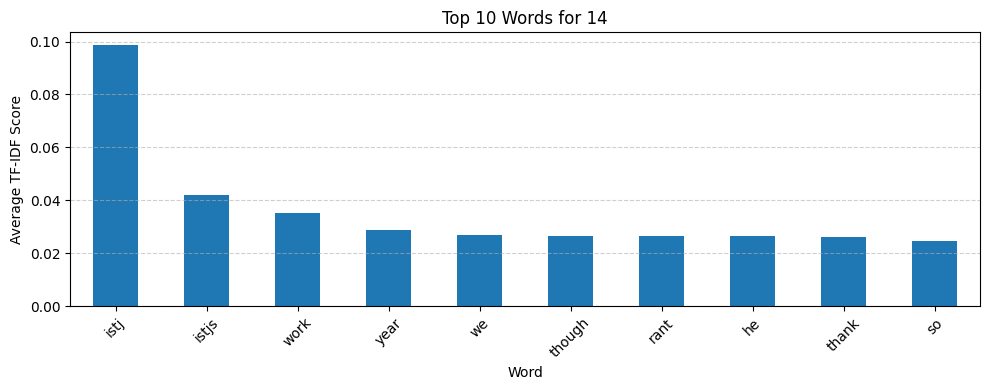

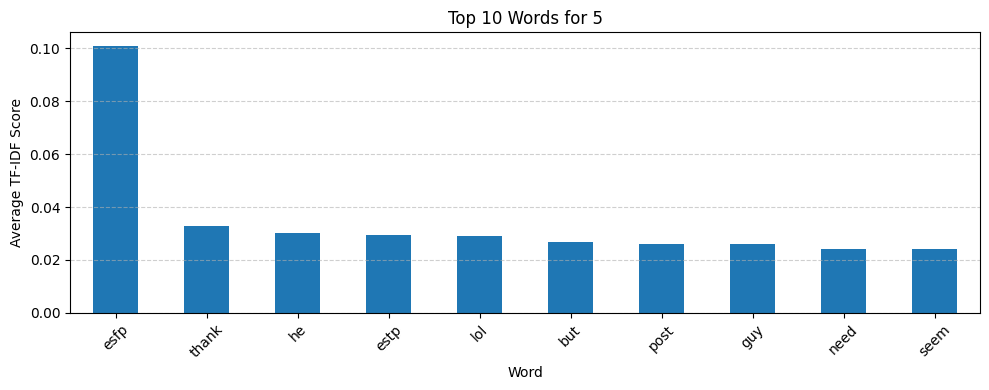

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load data
tfidf_train = pd.read_csv('/content/drive/MyDrive/6. TUGAS AKHIR/0. DATASET/X_train_tfidf.csv')
y_train = pd.read_csv('/content/drive/MyDrive/6. TUGAS AKHIR/0. DATASET/y_train_tfidf.csv')

# Gabungkan TF-IDF dan label
tfidf_train['MBTI'] = y_train['type']

# 2. Loop untuk setiap tipe MBTI
unique_types =tfidf_train['MBTI'].unique()

for mbti in unique_types:
    # Filter data berdasarkan tipe
    group = tfidf_train[tfidf_train['MBTI'] == mbti].drop(columns='MBTI')

    # Hitung rata-rata tf-idf per kata
    mean_tfidf = group.mean().sort_values(ascending=False).head(10)

    # Plot
    plt.figure(figsize=(10, 4))
    mean_tfidf.plot(kind='bar')
    plt.title(f"Top 10 Words for {mbti}")
    plt.ylabel("Average TF-IDF Score")
    plt.xlabel("Word")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()


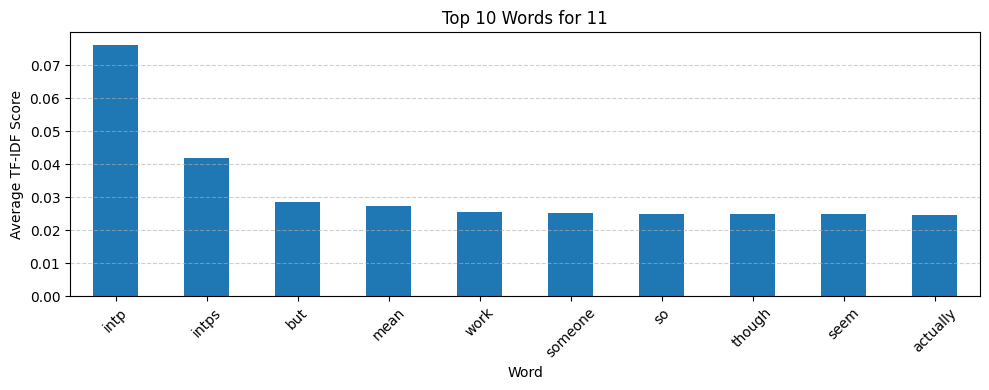

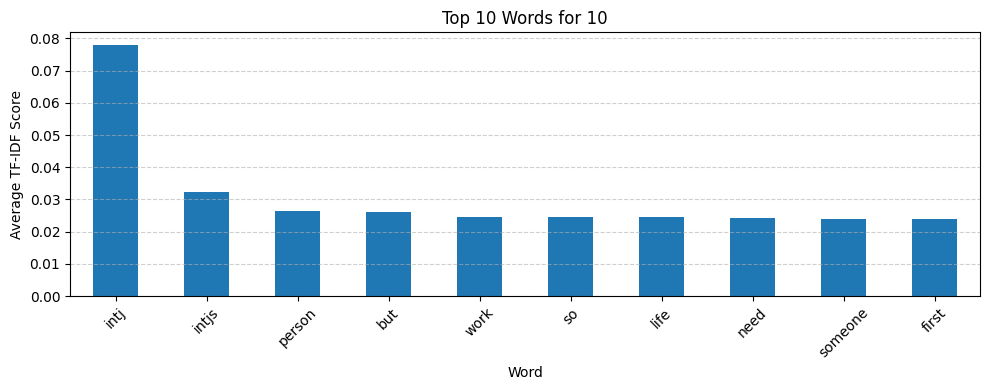

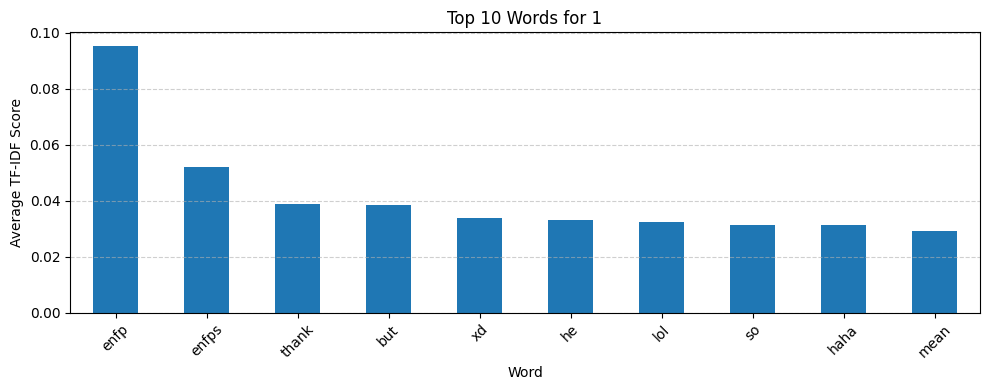

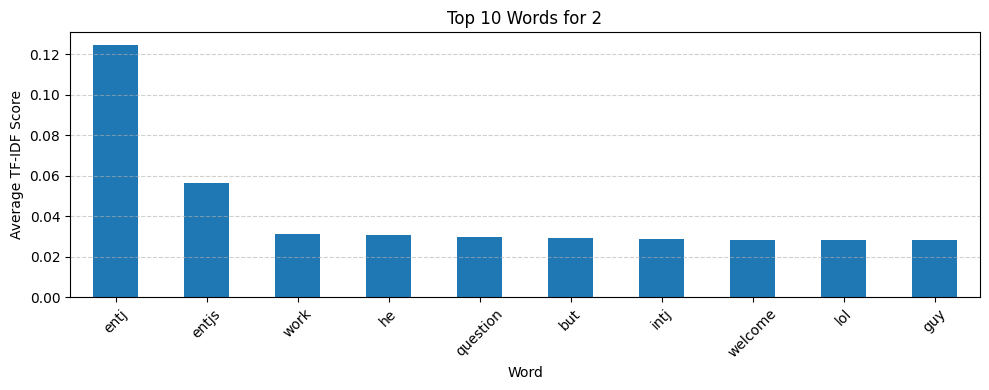

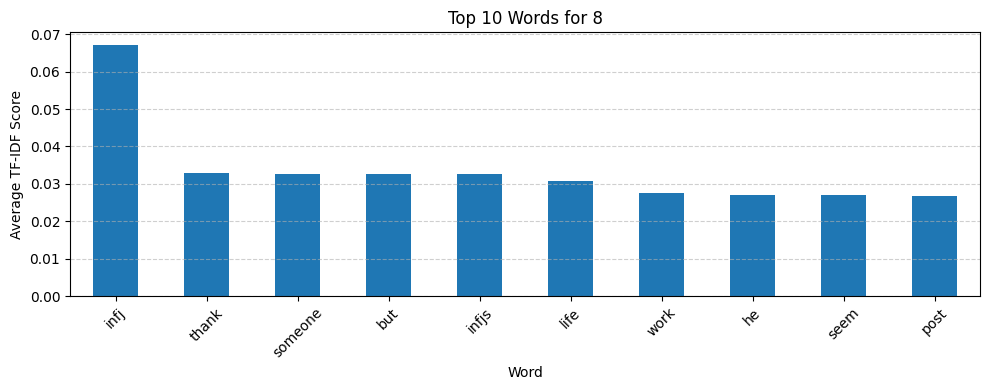

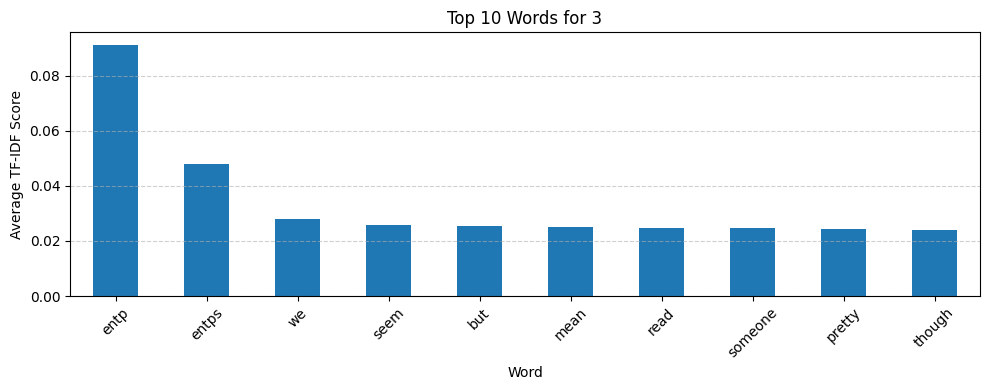

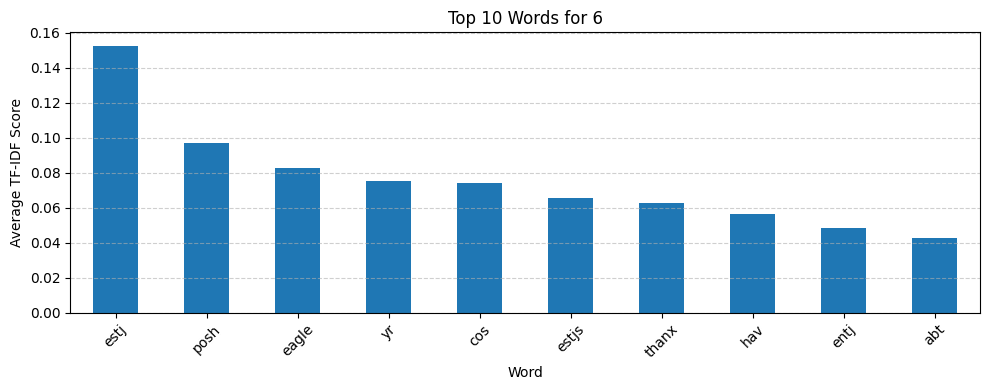

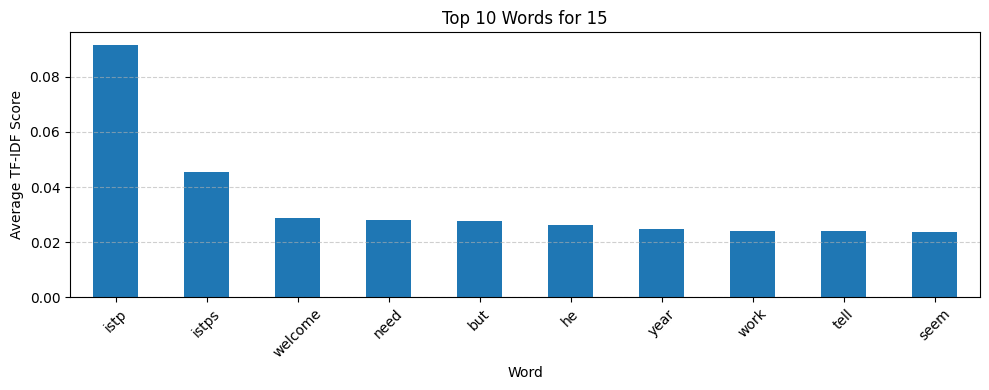

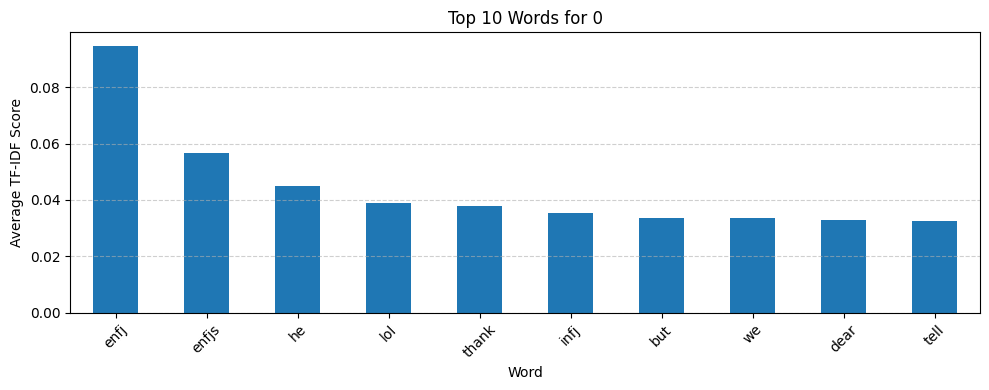

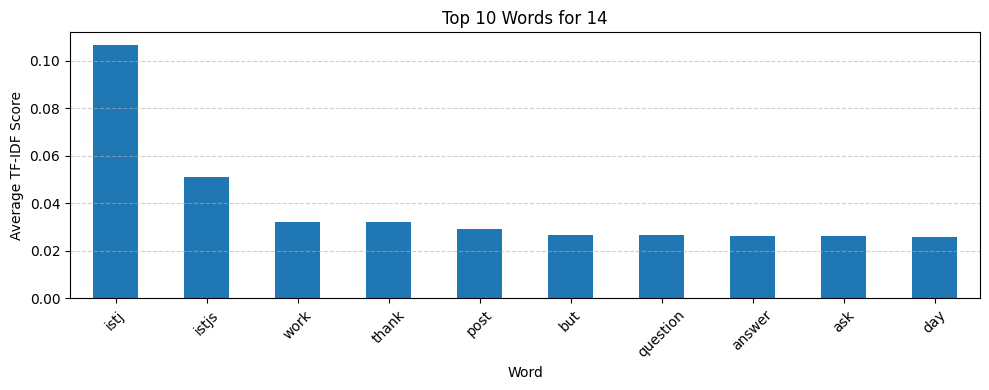

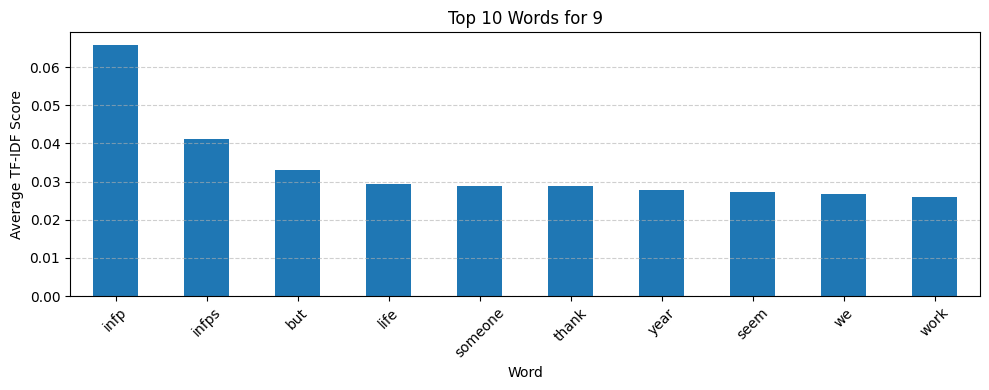

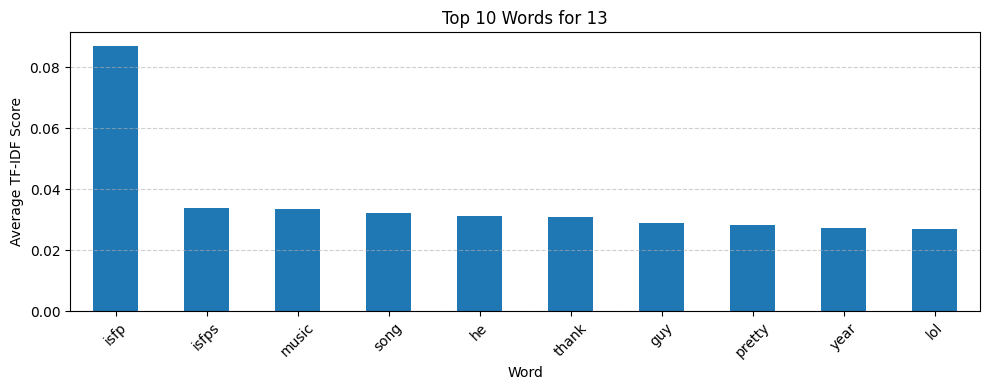

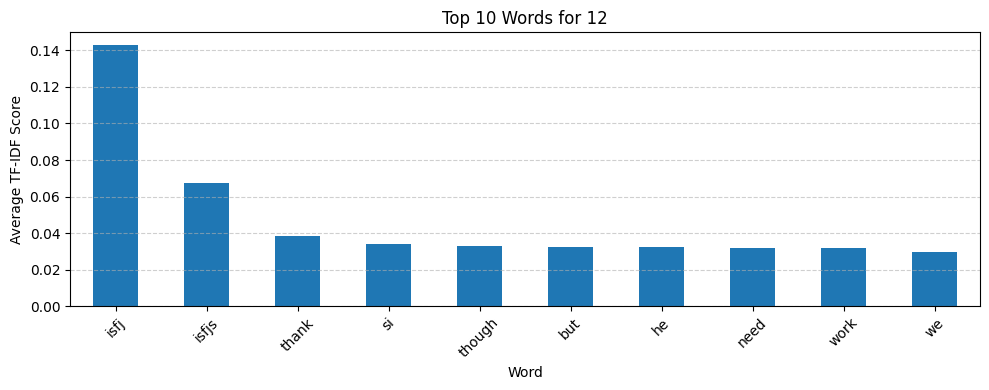

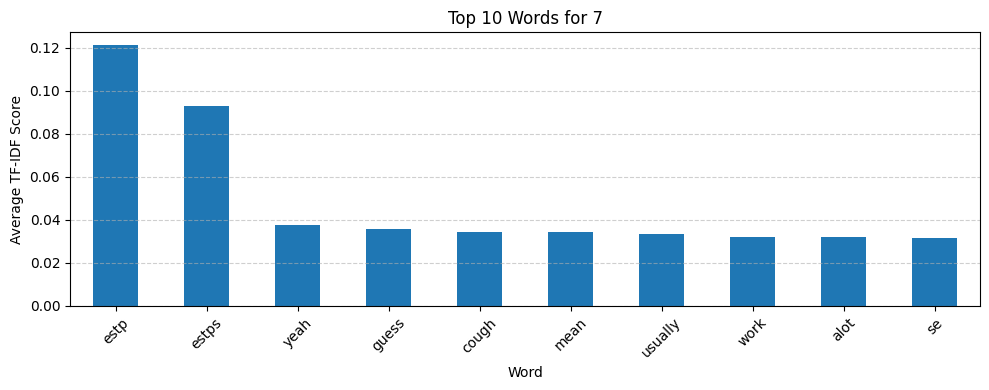

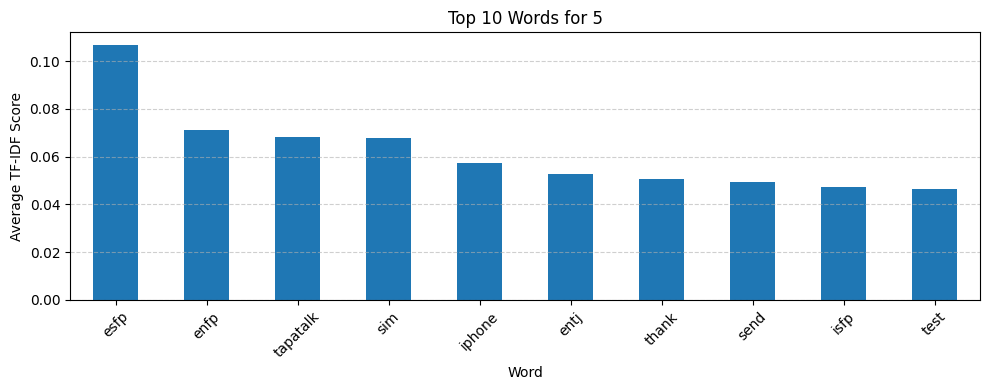

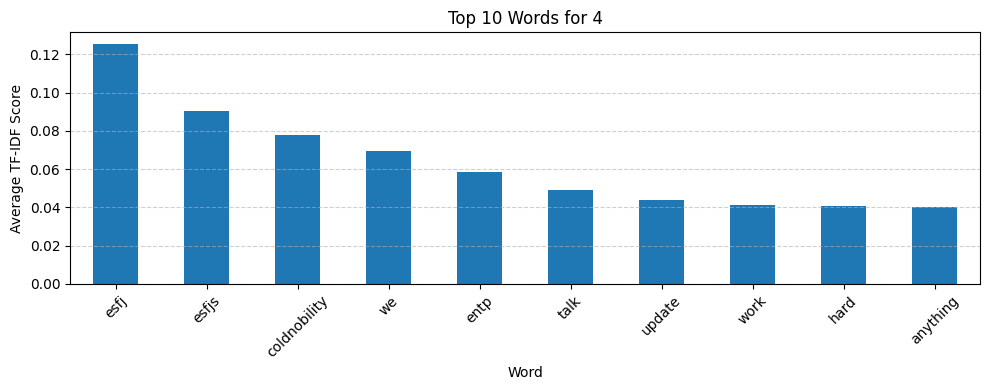

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load data
tfidf_test = pd.read_csv('/content/drive/MyDrive/6. TUGAS AKHIR/0. DATASET/X_test_tfidf.csv')
y_test = pd.read_csv('/content/drive/MyDrive/6. TUGAS AKHIR/0. DATASET/y_test_tfidf.csv')

# Gabungkan TF-IDF dan label
tfidf_test['MBTI'] = y_test['type']

# 2. Loop untuk setiap tipe MBTI
unique_types =tfidf_test['MBTI'].unique()

for mbti in unique_types:
    # Filter data berdasarkan tipe
    group = tfidf_test[tfidf_test['MBTI'] == mbti].drop(columns='MBTI')

    # Hitung rata-rata tf-idf per kata
    mean_tfidf = group.mean().sort_values(ascending=False).head(10)

    # Plot
    plt.figure(figsize=(10, 4))
    mean_tfidf.plot(kind='bar')
    plt.title(f"Top 10 Words for {mbti}")
    plt.ylabel("Average TF-IDF Score")
    plt.xlabel("Word")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()


# KNN

### Word2VEC

In [ ]:
# KNN Augmented with Word2VEC
import joblib

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

knn_classifier = KNeighborsClassifier(n_neighbors=40)
knn_classifier.fit(X_train_vectors, y_train)

y_pred = knn_classifier.predict(X_test_vectors)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Evaluation Metrics:\n", classification_report(y_test, y_pred))

joblib.dump(knn_classifier, ("/content/drive/MyDrive/6. TUGAS AKHIR/1. MODEL/knn_w2v_aug.pkl"))

Accuracy: 0.23631123919308358
Evaluation Metrics:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        41
           1       0.23      0.11      0.15       125
           2       0.50      0.02      0.04        44
           3       0.13      0.05      0.07       135
           4       0.00      0.00      0.00         7
           5       0.00      0.00      0.00         8
           6       0.00      0.00      0.00         7
           7       0.00      0.00      0.00        15
           8       0.19      0.33      0.24       288
           9       0.27      0.54      0.36       370
          10       0.20      0.16      0.18       193
          11       0.26      0.22      0.24       293
          12       0.00      0.00      0.00        45
          13       0.00      0.00      0.00        53
          14       0.00      0.00      0.00        44
          15       0.00      0.00      0.00        67

    accuracy                 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


['/content/drive/MyDrive/6. TUGAS AKHIR/1. MODEL/knn_w2v_aug.pkl']

Data loaded successfully
Test samples: 1735
Sample tokens: this when 
Word2Vec model loaded successfully
Word2Vec vectorization complete. Shape: (1735, 100)
KNN model loaded successfully
KNN + Word2Vec Accuracy: 0.2363
Classification Report - KNN + Word2Vec:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        41
           1       0.23      0.11      0.15       125
           2       0.50      0.02      0.04        44
           3       0.13      0.05      0.07       135
           4       0.00      0.00      0.00         7
           5       0.00      0.00      0.00         8
           6       0.00      0.00      0.00         7
           7       0.00      0.00      0.00        15
           8       0.19      0.33      0.24       288
           9       0.27      0.54      0.36       370
          10       0.20      0.16      0.18       193
          11       0.26      0.22      0.24       293
          12       0.00      0.00    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


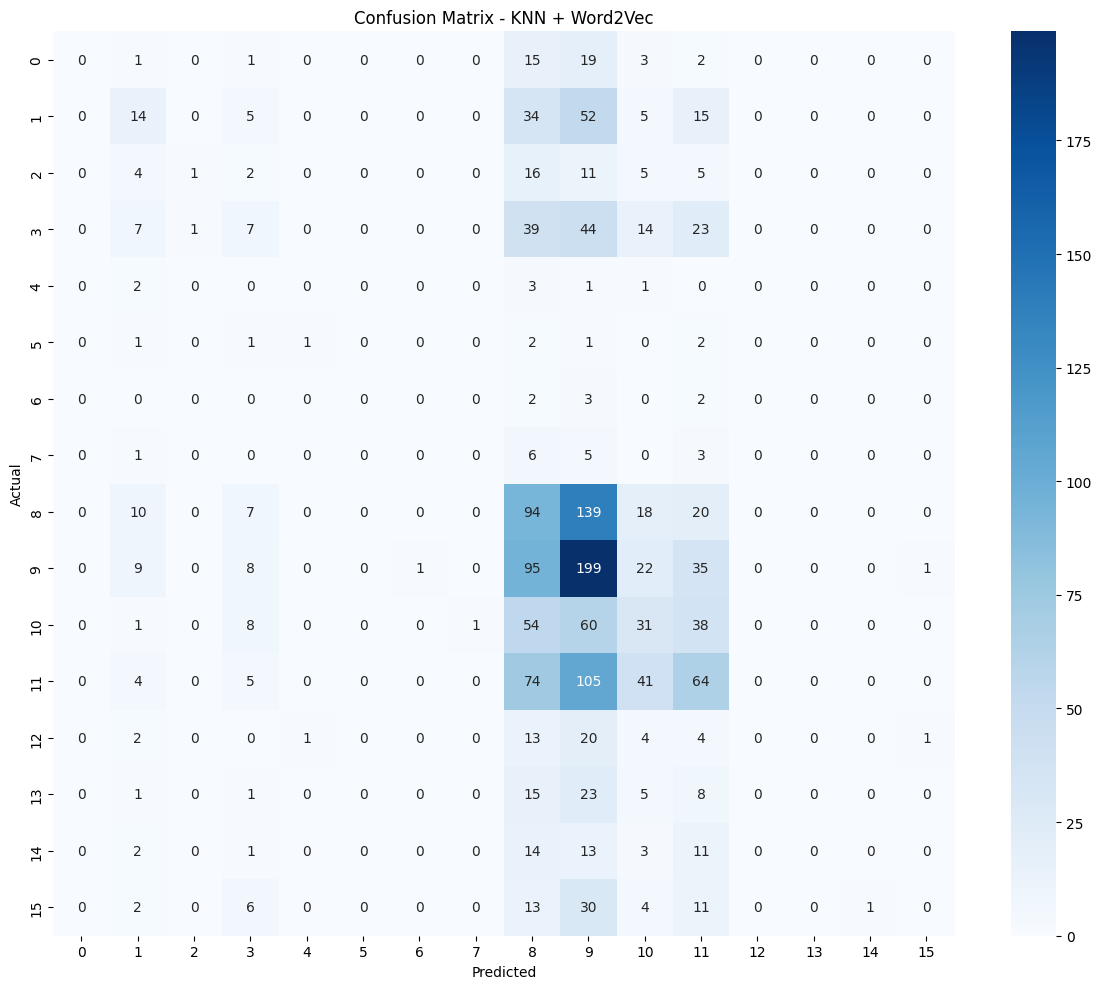

In [ ]:
import joblib
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import ast

test_df = pd.read_csv('/content/drive/MyDrive/6. TUGAS AKHIR/0. DATASET/new_test.csv')
y_test = test_df['type']
labels = list(range(16))

print("Data loaded successfully")
print(f"Test samples: {len(test_df)}")
print(f"Sample tokens: {test_df['posts'].iloc[0][:10]}")

w2v_model = Word2Vec.load("/content/drive/MyDrive/6. TUGAS AKHIR/1. MODEL/word2vec_aug.model")
print("Word2Vec model loaded successfully")

def get_average_w2v(tokens, model, vector_size=100):
    vectors = []
    for token in tokens:
        if token in model.wv:
            vectors.append(model.wv[token])
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(vector_size)

# Transform test data
X_test_vectors = np.array([
    get_average_w2v(tokens, w2v_model, vector_size=w2v_model.vector_size)
    for tokens in test_df['posts']
])

print(f"Word2Vec vectorization complete. Shape: {X_test_vectors.shape}")

knn_classifier = joblib.load("/content/drive/MyDrive/6. TUGAS AKHIR/1. MODEL/knn_w2v_aug.pkl")
print("KNN model loaded successfully")

# Predict and evaluate
y_pred_knn = knn_classifier.predict(X_test_vectors)

accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"KNN + Word2Vec Accuracy: {accuracy_knn:.4f}")
print("Classification Report - KNN + Word2Vec:\n", classification_report(y_test, y_pred_knn))

# Confusion Matrix
cm_knn = confusion_matrix(y_test, y_pred_knn, labels=labels)

plt.figure(figsize=(12, 10))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - KNN + Word2Vec')
plt.tight_layout()
plt.show()

### TF-IDF

In [ ]:
# KNN with TF-IDF
import joblib

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

knn_classifier = KNeighborsClassifier(n_neighbors=40)
knn_classifier.fit(X_train_tfidf, y_train)

y_pred = knn_classifier.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Evaluation Metrics:\n", classification_report(y_test, y_pred))

joblib.dump(knn_classifier, ("/content/drive/MyDrive/6. TUGAS AKHIR/1. MODEL/knn_tfidf_aug.pkl"))

Accuracy: 0.5273775216138329
Evaluation Metrics:
               precision    recall  f1-score   support

           0       0.62      0.24      0.35        41
           1       0.58      0.58      0.58       125
           2       0.72      0.30      0.42        44
           3       0.73      0.28      0.41       135
           4       0.38      0.43      0.40         7
           5       1.00      0.12      0.22         8
           6       0.75      0.43      0.55         7
           7       1.00      0.40      0.57        15
           8       0.41      0.72      0.52       288
           9       0.46      0.78      0.57       370
          10       0.61      0.43      0.51       193
          11       0.80      0.44      0.57       293
          12       0.95      0.40      0.56        45
          13       0.82      0.17      0.28        53
          14       0.86      0.27      0.41        44
          15       0.92      0.33      0.48        67

    accuracy                  

['/content/drive/MyDrive/6. TUGAS AKHIR/1. MODEL/knn_tfidf_aug.pkl']

In [ ]:
# KNN with TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

knn_classifier = KNeighborsClassifier(n_neighbors=60)
knn_classifier.fit(X_train_tfidf, y_train)

y_pred = knn_classifier.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Evaluation Metrics:\n", classification_report(y_test, y_pred))

Accuracy: 0.5423631123919308
Evaluation Metrics:
               precision    recall  f1-score   support

           0       0.61      0.27      0.37        41
           1       0.63      0.61      0.62       125
           2       0.88      0.32      0.47        44
           3       0.75      0.30      0.43       135
           4       0.29      0.29      0.29         7
           5       0.00      0.00      0.00         8
           6       1.00      0.29      0.44         7
           7       1.00      0.27      0.42        15
           8       0.41      0.77      0.54       288
           9       0.48      0.79      0.60       370
          10       0.64      0.41      0.50       193
          11       0.82      0.48      0.61       293
          12       0.93      0.31      0.47        45
          13       0.82      0.17      0.28        53
          14       0.75      0.27      0.40        44
          15       0.88      0.33      0.48        67

    accuracy                  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Data loaded successfully
Test texts shape: (1735,)
Sample text: this when I lie avoid unreasonable response something I completely justifiable I try justify someone...
Models loaded successfully
Transformation successful. Shape: (1735, 30065)
KNN + TF-IDF Accuracy: 0.5274
Classification Report - KNN + TF-IDF:
               precision    recall  f1-score   support

           0       0.62      0.24      0.35        41
           1       0.58      0.58      0.58       125
           2       0.72      0.30      0.42        44
           3       0.73      0.28      0.41       135
           4       0.38      0.43      0.40         7
           5       1.00      0.12      0.22         8
           6       0.75      0.43      0.55         7
           7       1.00      0.40      0.57        15
           8       0.41      0.72      0.52       288
           9       0.46      0.78      0.57       370
          10       0.61      0.43      0.51       193
          11       0.80      0.44      

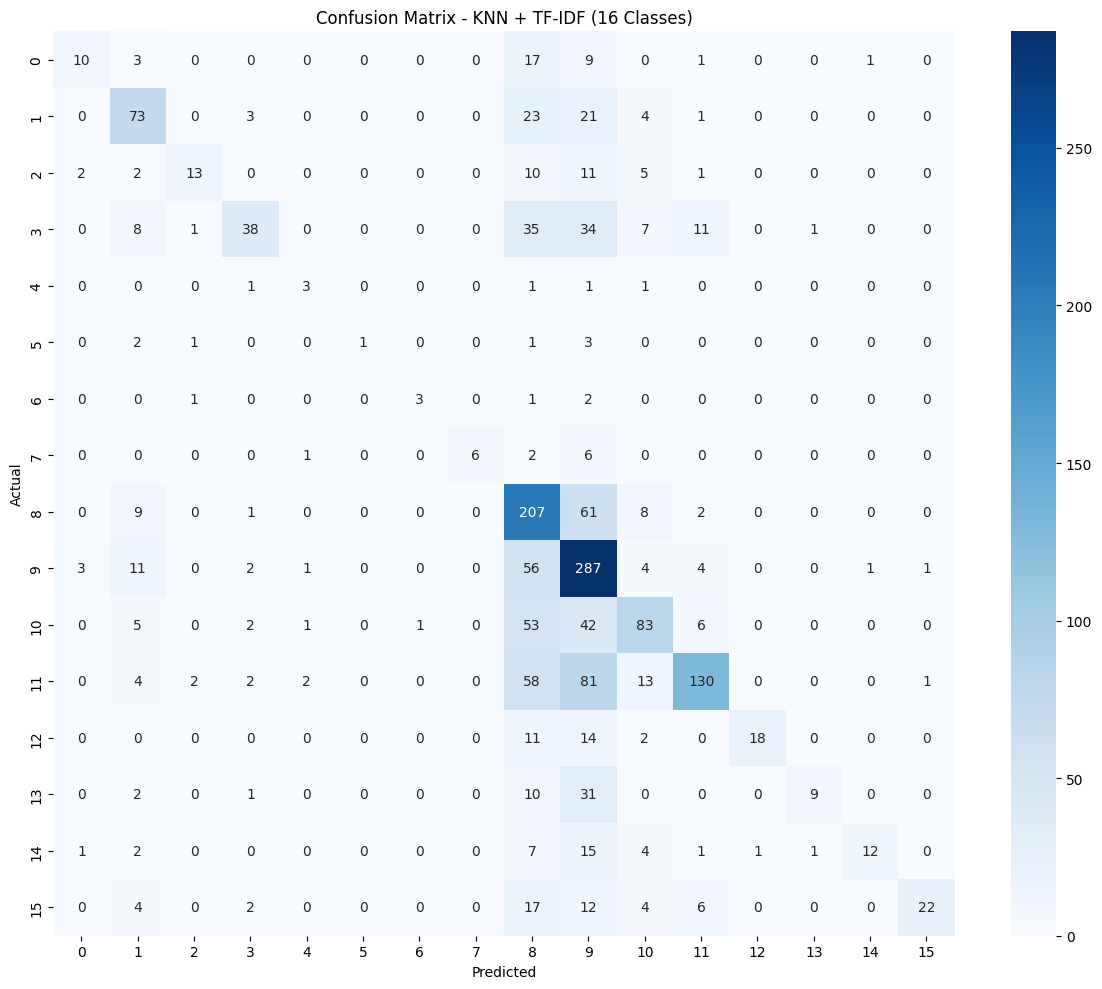

In [ ]:
import joblib
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import ast

# Load test data
test_df = pd.read_csv('/content/drive/MyDrive/6. TUGAS AKHIR/0. DATASET/5_test_token.csv')
test_df['token_posts'] = test_df['token_posts'].apply(ast.literal_eval)
test_texts = test_df['token_posts'].apply(lambda x: ' '.join(x))
y_test = test_df['type']
labels = list(range(16))

print("Data loaded successfully")
print(f"Test texts shape: {test_texts.shape}")
print(f"Sample text: {test_texts.iloc[0][:100]}...")

# Load vectorizer and model dengan error handling
try:
    tfidf_vectorizer = joblib.load("/content/drive/MyDrive/6. TUGAS AKHIR/1. MODEL/tfidf_vectorizer.pkl")
    knn_classifier = joblib.load("/content/drive/MyDrive/6. TUGAS AKHIR/1. MODEL/knn_tfidf_aug.pkl")
    print("Models loaded successfully")
except Exception as e:
    print(f"Error loading models: {e}")
    raise

# Transform test data dengan error handling
try:
    # Pastikan format yang benar
    texts_for_transform = [str(text) for text in test_texts]
    X_test_tfidf = tfidf_vectorizer.transform(texts_for_transform)
    print(f"Transformation successful. Shape: {X_test_tfidf.shape}")
except Exception as e:
    print(f"Transformation error: {e}")
    raise

# Predict
y_pred_knn = knn_classifier.predict(X_test_tfidf)

# Metrics
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"KNN + TF-IDF Accuracy: {accuracy_knn:.4f}")
print("Classification Report - KNN + TF-IDF:\n", classification_report(y_test, y_pred_knn))

# Confusion Matrix
cm_knn = confusion_matrix(y_test, y_pred_knn, labels=labels)

plt.figure(figsize=(12, 10))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - KNN + TF-IDF (16 Classes)')
plt.tight_layout()
plt.show()

# MLP

### Word2VEC

In [ ]:
# MLP with Word2VEC
import joblib
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,100), max_iter=300, activation='relu', solver='adam', random_state=42)
mlp_classifier.fit(X_train_vectors, y_train)

y_pred_mlp = mlp_classifier.predict(X_test_vectors)
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)

print(f"Accuracy: {accuracy_mlp}")
print("Evaluation Metrics:\n", classification_report(y_test, y_pred_mlp))

joblib.dump(mlp_classifier, ("/content/drive/MyDrive/6. TUGAS AKHIR/1. MODEL/mlp_w2v_aug.pkl"))

Accuracy: 0.26051873198847264
Evaluation Metrics:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        41
           1       0.22      0.03      0.06       125
           2       0.00      0.00      0.00        44
           3       0.26      0.09      0.13       135
           4       0.00      0.00      0.00         7
           5       0.00      0.00      0.00         8
           6       0.00      0.00      0.00         7
           7       0.00      0.00      0.00        15
           8       0.24      0.16      0.19       288
           9       0.30      0.62      0.40       370
          10       0.18      0.14      0.16       193
          11       0.27      0.45      0.33       293
          12       0.00      0.00      0.00        45
          13       0.00      0.00      0.00        53
          14       0.00      0.00      0.00        44
          15       0.00      0.00      0.00        67

    accuracy                 

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and bei

['/content/drive/MyDrive/6. TUGAS AKHIR/1. MODEL/mlp_w2v_aug.pkl']

Data loaded successfully
Test samples: 1735
Sample tokens: this when 
Word2Vec model loaded successfully
Word2Vec vectorization complete. Shape: (1735, 100)
MLP model loaded successfully
MLP + Word2Vec Accuracy: 0.2605
Classification Report - MLP + Word2Vec:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        41
           1       0.22      0.03      0.06       125
           2       0.00      0.00      0.00        44
           3       0.26      0.09      0.13       135
           4       0.00      0.00      0.00         7
           5       0.00      0.00      0.00         8
           6       0.00      0.00      0.00         7
           7       0.00      0.00      0.00        15
           8       0.24      0.16      0.19       288
           9       0.30      0.62      0.40       370
          10       0.18      0.14      0.16       193
          11       0.27      0.45      0.33       293
          12       0.00      0.00    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


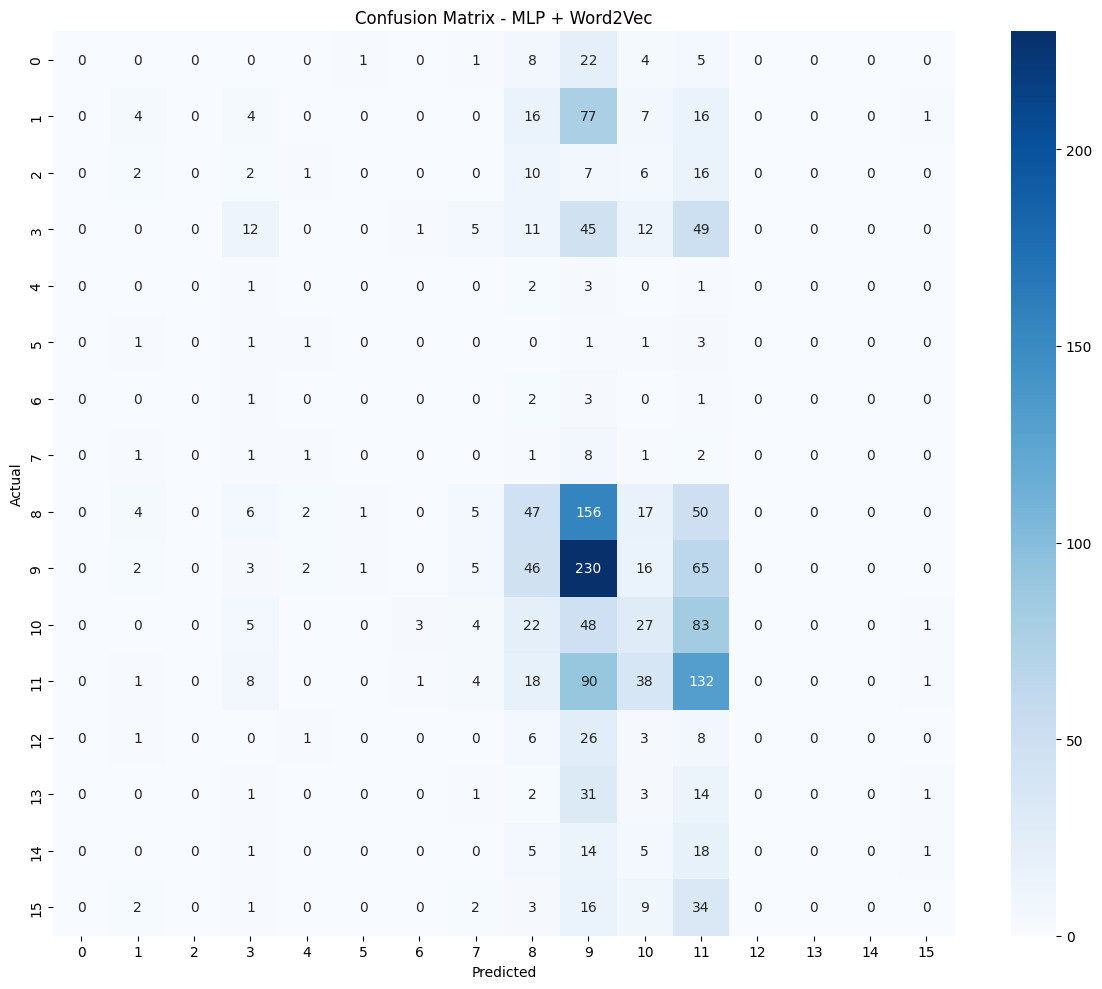

In [ ]:
import joblib
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import ast

test_df = pd.read_csv('/content/drive/MyDrive/6. TUGAS AKHIR/0. DATASET/new_test.csv')
y_test = test_df['type']
labels = list(range(16))

print("Data loaded successfully")
print(f"Test samples: {len(test_df)}")
print(f"Sample tokens: {test_df['posts'].iloc[0][:10]}")

w2v_model = Word2Vec.load("/content/drive/MyDrive/6. TUGAS AKHIR/1. MODEL/word2vec_aug.model")
print("Word2Vec model loaded successfully")

def get_average_w2v(tokens, model, vector_size=100):
    vectors = []
    for token in tokens:
        if token in model.wv:
            vectors.append(model.wv[token])
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(vector_size)

# Transform test data
X_test_vectors = np.array([
    get_average_w2v(tokens, w2v_model, vector_size=w2v_model.vector_size)
    for tokens in test_df['posts']
])

print(f"Word2Vec vectorization complete. Shape: {X_test_vectors.shape}")

mlp_classifier = joblib.load("/content/drive/MyDrive/6. TUGAS AKHIR/1. MODEL/mlp_w2v_aug.pkl")
print("MLP model loaded successfully")

# Predict and evaluate
y_pred_mlp = mlp_classifier.predict(X_test_vectors)

accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
print(f"MLP + Word2Vec Accuracy: {accuracy_mlp:.4f}")
print("Classification Report - MLP + Word2Vec:\n", classification_report(y_test, y_pred_mlp))

# Confusion Matrix
cm_mlp = confusion_matrix(y_test, y_pred_mlp, labels=labels)

plt.figure(figsize=(12, 10))
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - MLP + Word2Vec')
plt.tight_layout()
plt.show()

### TF-IDF

In [ ]:
# MLP with TF-IDF
import joblib
from sklearn.neural_network import MLPClassifier

mlp_classifier = MLPClassifier(hidden_layer_sizes=(100), max_iter=300, random_state=42)
mlp_classifier.fit(X_train_tfidf, y_train)

y_pred = mlp_classifier.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Evaluation Metrics:\n", classification_report(y_test, y_pred))

joblib.dump(mlp_classifier, ("/content/drive/MyDrive/6. TUGAS AKHIR/1. MODEL/mlp_tfidf_aug.pkl"))

Accuracy: 0.6121037463976945
Evaluation Metrics:
               precision    recall  f1-score   support

           0       0.54      0.17      0.26        41
           1       0.65      0.58      0.61       125
           2       0.82      0.41      0.55        44
           3       0.63      0.47      0.54       135
           4       1.00      0.43      0.60         7
           5       1.00      0.12      0.22         8
           6       0.75      0.43      0.55         7
           7       1.00      0.67      0.80        15
           8       0.53      0.63      0.58       288
           9       0.58      0.78      0.66       370
          10       0.61      0.65      0.63       193
          11       0.66      0.74      0.70       293
          12       0.94      0.33      0.49        45
          13       0.62      0.28      0.39        53
          14       0.72      0.30      0.42        44
          15       0.72      0.46      0.56        67

    accuracy                  

['/content/drive/MyDrive/6. TUGAS AKHIR/1. MODEL/mlp_tfidf_aug.pkl']

Data loaded successfully
Test texts shape: (1735,)
Sample text: this when I lie avoid unreasonable response something I completely justifiable I try justify someone...
Models loaded successfully
Transformation successful. Shape: (1735, 30065)
MLP + TF-IDF Accuracy: 0.6121
Classification Report - MLP + TF-IDF:
               precision    recall  f1-score   support

           0       0.54      0.17      0.26        41
           1       0.65      0.58      0.61       125
           2       0.82      0.41      0.55        44
           3       0.63      0.47      0.54       135
           4       1.00      0.43      0.60         7
           5       1.00      0.12      0.22         8
           6       0.75      0.43      0.55         7
           7       1.00      0.67      0.80        15
           8       0.53      0.63      0.58       288
           9       0.58      0.78      0.66       370
          10       0.61      0.65      0.63       193
          11       0.66      0.74      

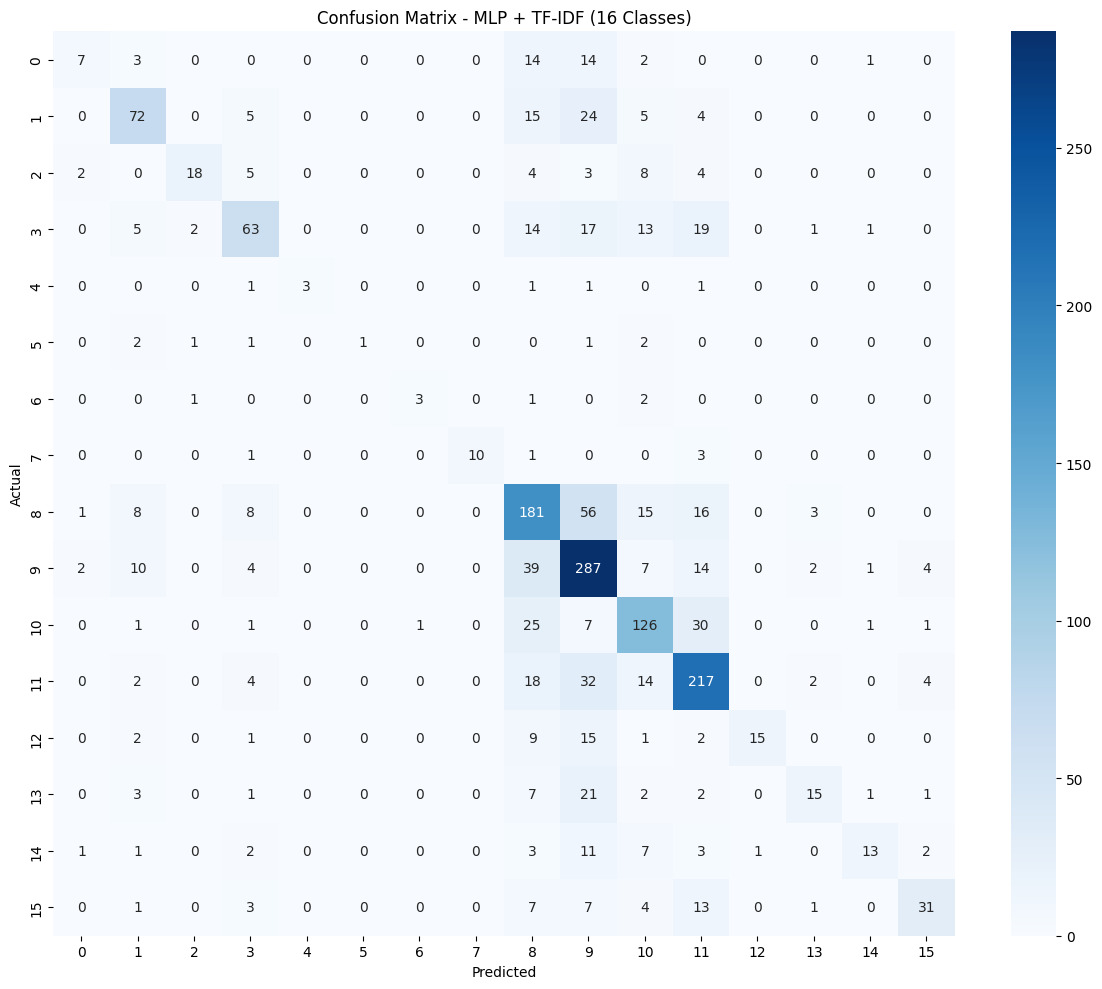

In [ ]:
import joblib
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import ast

# Load test data
test_df = pd.read_csv('/content/drive/MyDrive/6. TUGAS AKHIR/0. DATASET/5_test_token.csv')
test_df['token_posts'] = test_df['token_posts'].apply(ast.literal_eval)
test_texts = test_df['token_posts'].apply(lambda x: ' '.join(x))
y_test = test_df['type']
labels = list(range(16))

print("Data loaded successfully")
print(f"Test texts shape: {test_texts.shape}")
print(f"Sample text: {test_texts.iloc[0][:100]}...")

# Load vectorizer and model dengan error handling
try:
    tfidf_vectorizer = joblib.load("/content/drive/MyDrive/6. TUGAS AKHIR/1. MODEL/tfidf_vectorizer.pkl")
    mlp_classifier = joblib.load("/content/drive/MyDrive/6. TUGAS AKHIR/1. MODEL/mlp_tfidf_aug.pkl")
    print("Models loaded successfully")
except Exception as e:
    print(f"Error loading models: {e}")
    raise

# Transform test data dengan error handling
try:
    # Pastikan format yang benar
    texts_for_transform = [str(text) for text in test_texts]
    X_test_tfidf = tfidf_vectorizer.transform(texts_for_transform)
    print(f"Transformation successful. Shape: {X_test_tfidf.shape}")
except Exception as e:
    print(f"Transformation error: {e}")
    raise

# Predict
y_pred_mlp = mlp_classifier.predict(X_test_tfidf)

# Metrics
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
print(f"MLP + TF-IDF Accuracy: {accuracy_mlp:.4f}")
print("Classification Report - MLP + TF-IDF:\n", classification_report(y_test, y_pred_mlp))

# Confusion Matrix
cm_mlp = confusion_matrix(y_test, y_pred_mlp, labels=labels)

plt.figure(figsize=(12, 10))
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - MLP + TF-IDF (16 Classes)')
plt.tight_layout()
plt.show()

In [ ]:
tfidf_vectorizer = joblib.load("/content/drive/MyDrive/6. TUGAS AKHIR/1. MODEL/tfidf_vectorizer.pkl")
print(tfidf_vectorizer)
print(type(tfidf_vectorizer))

<class 'sklearn.feature_extraction.text.TfidfVectorizer'>
<class 'type'>


In [ ]:
# MLP
from sklearn.neural_network import MLPClassifier

mlp_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('mlp', MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=300, activation='relu', solver='adam', random_state=42)) # Parameter
])

mlp_pipeline.fit(X_train, y_train)

y_pred = mlp_pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
classification = classification_report(y_test, y_pred)
print("Accuracy:", accuracy)
print("Evaluation Metrics:\n", classification)

Accuracy: 0.9397919154016715
Evaluation Metrics:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       376
           1       0.97      0.94      0.96       360
           2       1.00      1.00      1.00       401
           3       0.91      0.94      0.93       344
           4       1.00      1.00      1.00       382
           5       1.00      1.00      1.00       371
           6       1.00      1.00      1.00       351
           7       1.00      1.00      1.00       391
           8       0.81      0.71      0.76       360
           9       0.69      0.75      0.72       345
          10       0.85      0.85      0.85       379
          11       0.84      0.82      0.83       344
          12       0.99      1.00      1.00       350
          13       1.00      0.99      1.00       387
          14       0.99      1.00      1.00       353
          15       0.99      0.99      0.99       369

    accuracy                  

In [ ]:
%pip install streamlit

Note: you may need to restart the kernel to use updated packages.


# Grafik

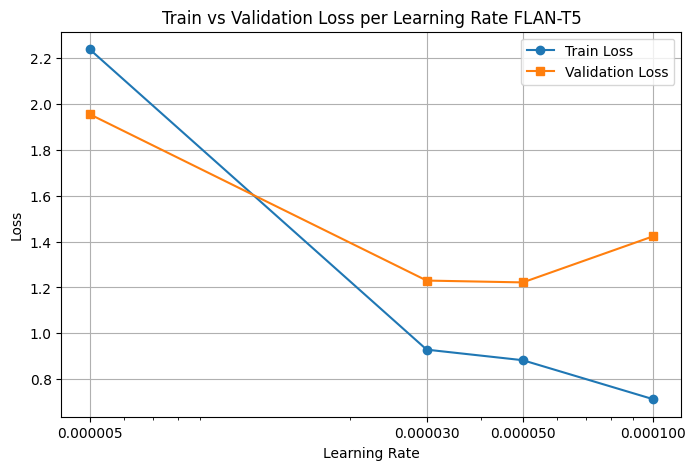

In [ ]:
import matplotlib.pyplot as plt

# Data
lr_values = [5e-6, 3e-5, 5e-5, 1e-4]
train_loss = [2.238, 0.929, 0.883, 0.713]
val_loss = [1.955, 1.230, 1.222, 1.423]

plt.figure(figsize=(8,5))
plt.plot(lr_values, train_loss, marker='o', label='Train Loss')
plt.plot(lr_values, val_loss, marker='s', label='Validation Loss')

plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss per Learning Rate FLAN-T5')
plt.legend()
plt.grid(True)
plt.xticks(lr_values, [f'{lr:.6f}' for lr in lr_values])

plt.show()


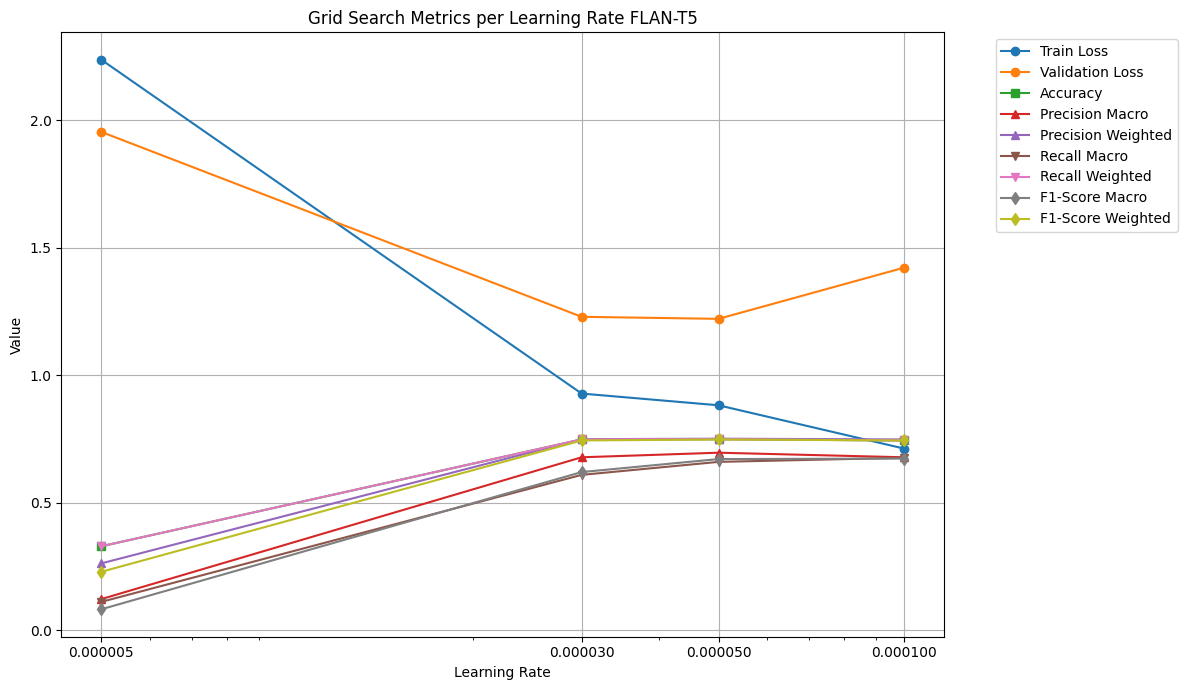

In [ ]:
import matplotlib.pyplot as plt

lr_values = [5e-6, 3e-5, 5e-5, 1e-4]

train_loss = [2.238, 0.929, 0.883, 0.713]
val_loss = [1.955, 1.230, 1.222, 1.423]

accuracy = [0.330, 0.749, 0.750, 0.745]

precision_macro = [0.123, 0.679, 0.697, 0.679]
precision_weighted = [0.263, 0.750, 0.752, 0.749]

recall_macro = [0.112, 0.610, 0.661, 0.677]
recall_weighted = [0.330, 0.749, 0.750, 0.745]

f1_macro = [0.083, 0.621, 0.672, 0.674]
f1_weighted = [0.230, 0.745, 0.749, 0.745]

plt.figure(figsize=(12,7))

# Plot semua metrik
plt.plot(lr_values, train_loss, marker='o', label='Train Loss')
plt.plot(lr_values, val_loss, marker='o', label='Validation Loss')

plt.plot(lr_values, accuracy, marker='s', label='Accuracy')

plt.plot(lr_values, precision_macro, marker='^', label='Precision Macro')
plt.plot(lr_values, precision_weighted, marker='^', label='Precision Weighted')

plt.plot(lr_values, recall_macro, marker='v', label='Recall Macro')
plt.plot(lr_values, recall_weighted, marker='v', label='Recall Weighted')

plt.plot(lr_values, f1_macro, marker='d', label='F1-Score Macro')
plt.plot(lr_values, f1_weighted, marker='d', label='F1-Score Weighted')

plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Value')
plt.title('Grid Search Metrics per Learning Rate FLAN-T5')

# Custom xticks supaya semua LR keliatan jelas
plt.xticks(lr_values, [f'{lr:.6f}' for lr in lr_values])

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # legend di luar plot biar gak penuh
plt.grid(True)
plt.tight_layout()

plt.show()


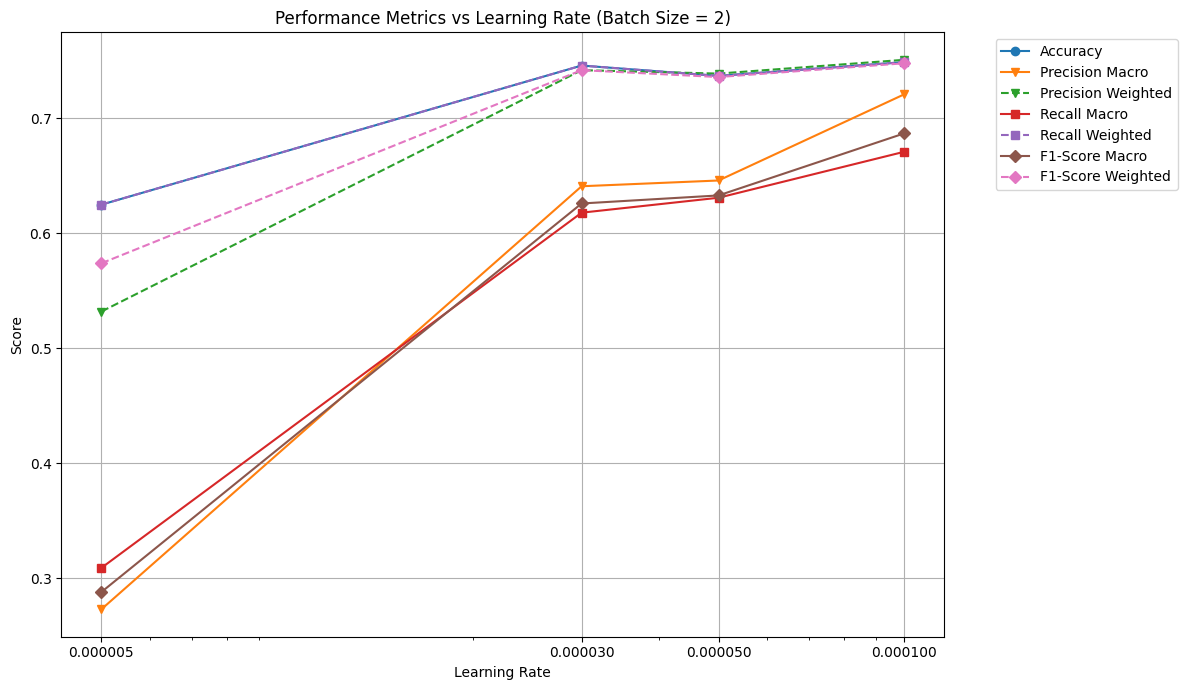

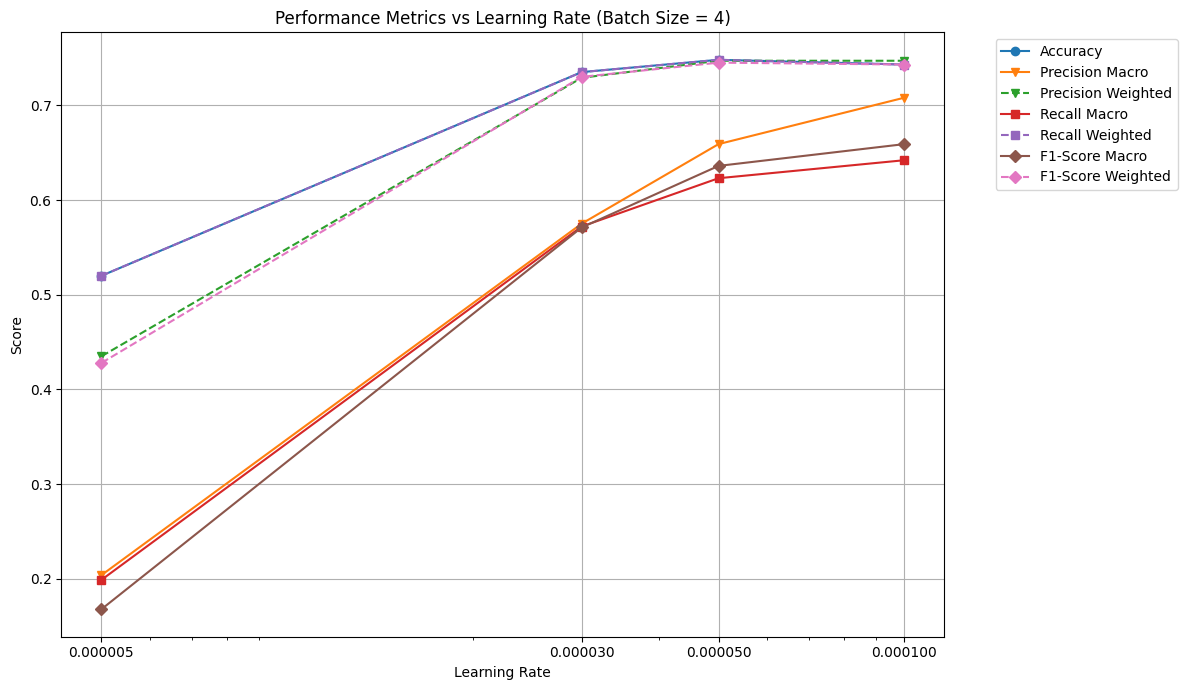

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Data metrik (urut sesuai LR dan BS)
data = {
    'LR': [5e-6, 5e-6, 3e-5, 3e-5, 5e-5, 5e-5, 1e-4, 1e-4],
    'BS': [2, 4, 2, 4, 2, 4, 2, 4],
    'accuracy': [0.625, 0.520, 0.746, 0.735, 0.737, 0.748, 0.749, 0.743],
    'precision_macro': [0.273, 0.204, 0.641, 0.575, 0.646, 0.659, 0.721, 0.708],
    'precision_weighted': [0.532, 0.435, 0.742, 0.729, 0.739, 0.747, 0.751, 0.747],
    'recall_macro': [0.309, 0.199, 0.618, 0.572, 0.631, 0.623, 0.671, 0.642],
    'recall_weighted': [0.625, 0.520, 0.746, 0.735, 0.737, 0.748, 0.749, 0.743],
    'f1_macro': [0.288, 0.168, 0.626, 0.571, 0.633, 0.636, 0.687, 0.659],
    'f1_weighted': [0.574, 0.428, 0.742, 0.730, 0.736, 0.745, 0.748, 0.743]
}

df = pd.DataFrame(data)

def plot_metrics(df, batch_size):
    subset = df[df['BS'] == batch_size]

    plt.figure(figsize=(12,7))
    plt.plot(subset['LR'], subset['accuracy'], marker='o', label='Accuracy')
    plt.plot(subset['LR'], subset['precision_macro'], marker='v', label='Precision Macro')
    plt.plot(subset['LR'], subset['precision_weighted'], marker='v', linestyle='--', label='Precision Weighted')
    plt.plot(subset['LR'], subset['recall_macro'], marker='s', label='Recall Macro')
    plt.plot(subset['LR'], subset['recall_weighted'], marker='s', linestyle='--', label='Recall Weighted')
    plt.plot(subset['LR'], subset['f1_macro'], marker='D', label='F1-Score Macro')
    plt.plot(subset['LR'], subset['f1_weighted'], marker='D', linestyle='--', label='F1-Score Weighted')

    plt.xscale('log')
    plt.xlabel('Learning Rate')
    plt.ylabel('Score')
    plt.title(f'Performance Metrics vs Learning Rate (Batch Size = {batch_size})')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.xticks(subset['LR'], [f'{lr:.6f}' for lr in subset['LR']])
    plt.tight_layout()
    plt.show()

# Plot untuk batch size 2
plot_metrics(df, 2)

# Plot untuk batch size 4
plot_metrics(df, 4)


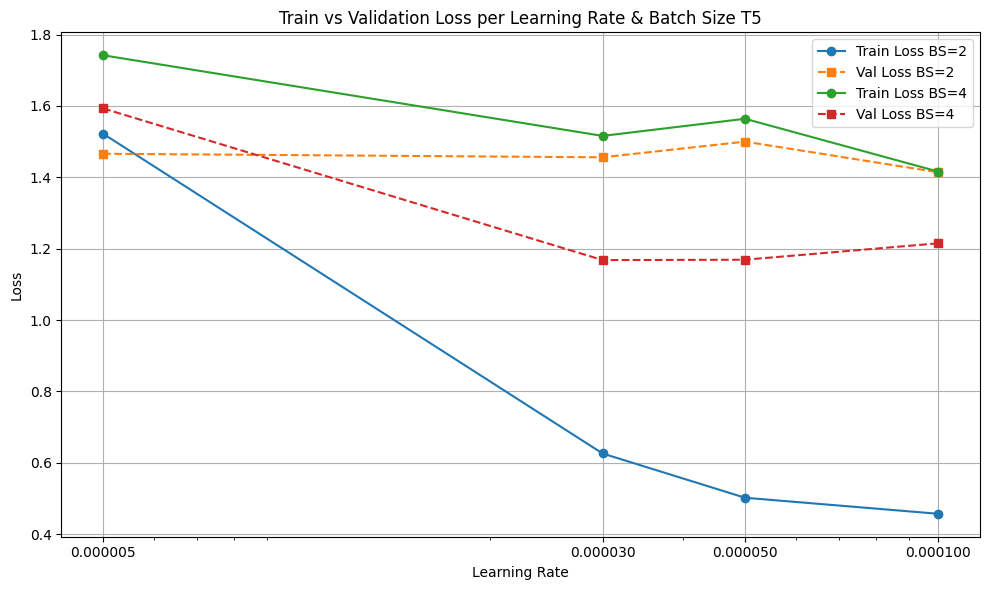

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Data grid search terbaru
data = {
    'LR': [5e-6, 5e-6, 3e-5, 3e-5, 5e-5, 5e-5, 1e-4, 1e-4],
    'BS': [2, 4, 2, 4, 2, 4, 2, 4],
    'train_loss': [1.522, 1.742, 0.626, 1.516, 0.502, 1.564, 0.457, 1.416],
    'val_loss': [1.466, 1.593, 1.456, 1.168, 1.500, 1.169, 1.414, 1.215]
}

df = pd.DataFrame(data)

plt.figure(figsize=(10,6))

for bs in df['BS'].unique():
    subset = df[df['BS'] == bs]
    plt.plot(subset['LR'], subset['train_loss'], marker='o', linestyle='-', label=f'Train Loss BS={bs}')
    plt.plot(subset['LR'], subset['val_loss'], marker='s', linestyle='--', label=f'Val Loss BS={bs}')

plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss per Learning Rate & Batch Size T5')
plt.legend()
plt.grid(True)

plt.xticks(df['LR'].unique(), [f'{lr:.6f}' for lr in df['LR'].unique()])

plt.tight_layout()
plt.show()


# Testing

In [ ]:
import joblib
import numpy as np
import pandas as pd
from collections import Counter
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
import os

# Path to saved models and vectorizers
MODEL_PATHS = {
    'KNN TF-IDF + Augmentasi': r"C:\Users\admin\Downloads\MODEL\knn_tfidf_aug.pkl",
    'KNN Word2VEC + Augmentasi': r"C:\Users\admin\Downloads\MODEL\knn_w2v_aug.pkl",
    'MLP TF-IDF + Augmentasi': r"C:\Users\admin\Downloads\MODEL\mlp_tfidf_aug.pkl",
    'MLP Word2VEC + Augmentasi': r"C:\Users\admin\Downloads\MODEL\mlp_w2v_aug.pkl",

    'KNN TF-IDF': r"C:\Users\admin\Downloads\MODEL\knn_tfidf.pkl",
    'KNN Word2VEC': r"C:\Users\admin\Downloads\MODEL\knn_w2v.pkl",
    'MLP TF-IDF': r"C:\Users\admin\Downloads\MODEL\mlp_tfidf.pkl",
    'MLP Word2VEC': r"C:\Users\admin\Downloads\MODEL\mlp_w2v.pkl",
}

VECTORIZER_PATHS = {
    'aug': r'C:\Users\admin\Downloads\MODEL\tfidf_vectorizer_aug.pkl',
    'raw': r'C:\Users\admin\Downloads\MODEL\tfidf_raw_vectorizer.pkl'
}

WORD2VEC_PATHS = {
    'aug': r'C:\Users\admin\Downloads\MODEL\word2vec_aug.model',
    'raw': r'C:\Users\admin\Downloads\MODEL\word2vec_raw.model'
}

MBTI_LABELS = {
    0: "ENFJ", 1: "ENFP", 2: "ENTJ", 3: "ENTP", 4: "ESFJ", 5: "ESFP", 6: "ESTJ", 7: "ESTP",
    8: "INFJ", 9: "INFP", 10: "INTJ", 11: "INTP", 12: "ISFJ", 13: "ISFP", 14: "ISTJ", 15: "ISTP"
}

# Load models
def load_model(file_path):
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Model file not found: {file_path}")
    return joblib.load(file_path)

def load_word2vec_model(file_path):
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Word2Vec model file not found: {file_path}")
    return Word2Vec.load(file_path)

def load_tfidf_vectorizer(file_path):
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"TF-IDF vectorizer file not found: {file_path}")
    return joblib.load(file_path)

# Preprocess input
def preprocess_input(input_text, vectorizer=None, word2vec_model=None):
    if vectorizer:
        return vectorizer.transform([input_text])
    elif word2vec_model:
        words = input_text.lower().split()
        vector = np.zeros(word2vec_model.vector_size)
        word_count = 0
        for word in words:
            if word in word2vec_model.wv:
                vector += word2vec_model.wv[word]
                word_count += 1
        if word_count > 0:
            vector /= word_count
        return np.array([vector])
    else:
        return input_text

# Confidence score evaluation
def evaluate_knn_or_mlp(model, X_test, model_type="KNN"):
    try:
        if model is None:
            return None, 0.0
        y_pred = model.predict(X_test)

        if model_type == "KNN":
            distances, indices = model.kneighbors(X_test)
            max_distance = np.max(distances[0]) if len(distances[0]) > 0 else 1.0
            confidence_score = 1 - (np.min(distances[0]) / (max_distance + 1e-10))
            confidence_score = max(0.0, min(1.0, confidence_score))  # Clamp to [0,1]
        else:  # MLP
            y_prob = model.predict_proba(X_test)
            confidence_score = float(np.max(y_prob))

        return y_pred, confidence_score
    except Exception as e:
        return None, 0.0

# Get model and preprocessor based on choice
def get_model_and_preprocessor(model_choice):
    model_path = MODEL_PATHS.get(model_choice)
    model = load_model(model_path)

    is_word2vec = 'Word2VEC' in model_choice
    is_augmented = 'Augmentasi' in model_choice

    if is_word2vec:
        word2vec_model_path = WORD2VEC_PATHS['aug' if is_augmented else 'raw']
        preprocessor = load_word2vec_model(word2vec_model_path)
    else:
        tfidf_vectorizer_path = VECTORIZER_PATHS['aug' if is_augmented else 'raw']
        preprocessor = load_tfidf_vectorizer(tfidf_vectorizer_path)

    return model, preprocessor, is_word2vec

# Evaluate models and save to CSV
def evaluate_models(input_data):
    model_choices = [
        'KNN TF-IDF + Augmentasi',
        'KNN Word2VEC + Augmentasi',
        'MLP TF-IDF + Augmentasi',
        'MLP Word2VEC + Augmentasi',
        'KNN TF-IDF',
        'KNN Word2VEC',
        'MLP TF-IDF',
        'MLP Word2VEC'
    ]

    all_results = []

    for model_choice in model_choices:
        model, preprocessor, is_word2vec = get_model_and_preprocessor(model_choice)

        for index, row in input_data.iterrows():
            input_text = row['posts']  # assuming 'posts' column contains the data to analyze
            X_test = preprocess_input(input_text, vectorizer=preprocessor if not is_word2vec else None, word2vec_model=preprocessor if is_word2vec else None)

            if X_test is None:
                continue

            prediction, confidence_score = evaluate_knn_or_mlp(model, X_test, model_type="KNN" if 'KNN' in model_choice else "MLP")

            if prediction is not None:
                result = {
                    "Model": model_choice,
                    "Posts": input_text,
                    "Type": MBTI_LABELS.get(row['type'], "Unknown"),  # Decode the 'type' to MBTI label
                    "Predict": MBTI_LABELS.get(prediction[0], "Unknown"),  # Decode the prediction to MBTI label
                    "Confidence Score": confidence_score
                }
                all_results.append(result)

    return all_results

# Load test data from CSV
test_data_path = r"C:\Users\admin\Downloads\test.csv"
input_data = pd.read_csv(test_data_path)

# Get results and save to CSV files
results = evaluate_models(input_data)
df = pd.DataFrame(results)

# Save each model result to a separate CSV file
for model_choice in df['Model'].unique():
    model_df = df[df['Model'] == model_choice]
    model_df.to_csv(f"{model_choice}_results.csv", index=False)
    print(f"Saved results for {model_choice} to CSV.")


Saved results for KNN TF-IDF + Augmentasi to CSV.
Saved results for KNN Word2VEC + Augmentasi to CSV.
Saved results for MLP TF-IDF + Augmentasi to CSV.
Saved results for MLP Word2VEC + Augmentasi to CSV.
Saved results for KNN TF-IDF to CSV.
Saved results for KNN Word2VEC to CSV.
Saved results for MLP TF-IDF to CSV.
Saved results for MLP Word2VEC to CSV.


In [ ]:
import joblib
import numpy as np
import pandas as pd
from collections import Counter
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
import os

# Path to saved models and vectorizers
MODEL_PATHS = {
    'KNN TF-IDF + Augmentasi': r"C:\Users\admin\Downloads\MODEL\knn_tfidf_aug.pkl",
    'KNN Word2VEC + Augmentasi': r"C:\Users\admin\Downloads\MODEL\knn_w2v_aug.pkl",
    'MLP TF-IDF + Augmentasi': r"C:\Users\admin\Downloads\MODEL\mlp_tfidf_aug.pkl",
    'MLP Word2VEC + Augmentasi': r"C:\Users\admin\Downloads\MODEL\mlp_w2v_aug.pkl",

    'KNN TF-IDF': r"C:\Users\admin\Downloads\MODEL\knn_tfidf.pkl",
    'KNN Word2VEC': r"C:\Users\admin\Downloads\MODEL\knn_w2v.pkl",
    'MLP TF-IDF': r"C:\Users\admin\Downloads\MODEL\mlp_tfidf.pkl",
    'MLP Word2VEC': r"C:\Users\admin\Downloads\MODEL\mlp_w2v.pkl",
}

VECTORIZER_PATHS = {
    'aug': r'C:\Users\admin\Downloads\MODEL\tfidf_vectorizer_aug.pkl',
    'raw': r'C:\Users\admin\Downloads\MODEL\tfidf_raw_vectorizer.pkl'
}

WORD2VEC_PATHS = {
    'aug': r'C:\Users\admin\Downloads\MODEL\word2vec_aug.model',
    'raw': r'C:\Users\admin\Downloads\MODEL\word2vec_raw.model'
}

MBTI_LABELS = {
    0: "ENFJ", 1: "ENFP", 2: "ENTJ", 3: "ENTP", 4: "ESFJ", 5: "ESFP", 6: "ESTJ", 7: "ESTP",
    8: "INFJ", 9: "INFP", 10: "INTJ", 11: "INTP", 12: "ISFJ", 13: "ISFP", 14: "ISTJ", 15: "ISTP"
}

# Load models
def load_model(file_path):
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Model file not found: {file_path}")
    return joblib.load(file_path)

def load_word2vec_model(file_path):
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Word2Vec model file not found: {file_path}")
    return Word2Vec.load(file_path)

def load_tfidf_vectorizer(file_path):
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"TF-IDF vectorizer file not found: {file_path}")
    return joblib.load(file_path)

# Preprocess input
def preprocess_input(input_text, vectorizer=None, word2vec_model=None):
    if vectorizer:
        return vectorizer.transform([input_text])
    elif word2vec_model:
        words = input_text.lower().split()
        vector = np.zeros(word2vec_model.vector_size)
        word_count = 0
        for word in words:
            if word in word2vec_model.wv:
                vector += word2vec_model.wv[word]
                word_count += 1
        if word_count > 0:
            vector /= word_count
        return np.array([vector])
    else:
        return input_text

# Confidence score evaluation
def evaluate_knn_or_mlp(model, X_test, model_type="KNN"):
    try:
        if model is None:
            return None, 0.0
        y_pred = model.predict(X_test)

        if model_type == "KNN":
            distances, indices = model.kneighbors(X_test)
            max_distance = np.max(distances[0]) if len(distances[0]) > 0 else 1.0
            confidence_score = 1 - (np.min(distances[0]) / (max_distance + 1e-10))
            confidence_score = max(0.0, min(1.0, confidence_score))  # Clamp to [0,1]
        else:  # MLP
            y_prob = model.predict_proba(X_test)
            confidence_score = float(np.max(y_prob))

        return y_pred, confidence_score
    except Exception as e:
        return None, 0.0

# Get model and preprocessor based on choice
def get_model_and_preprocessor(model_choice):
    model_path = MODEL_PATHS.get(model_choice)
    model = load_model(model_path)

    is_word2vec = 'Word2VEC' in model_choice
    is_augmented = 'Augmentasi' in model_choice

    if is_word2vec:
        word2vec_model_path = WORD2VEC_PATHS['aug' if is_augmented else 'raw']
        preprocessor = load_word2vec_model(word2vec_model_path)
    else:
        tfidf_vectorizer_path = VECTORIZER_PATHS['aug' if is_augmented else 'raw']
        preprocessor = load_tfidf_vectorizer(tfidf_vectorizer_path)

    return model, preprocessor, is_word2vec

# Evaluate models and save to CSV
def evaluate_models(input_data):
    model_choices = [
        'KNN TF-IDF + Augmentasi',
        'KNN Word2VEC + Augmentasi',
        'MLP TF-IDF + Augmentasi',
        'MLP Word2VEC + Augmentasi',
        'KNN TF-IDF',
        'KNN Word2VEC',
        'MLP TF-IDF',
        'MLP Word2VEC'
    ]

    all_results = []
    model_metrics = {}

    for model_choice in model_choices:
        model, preprocessor, is_word2vec = get_model_and_preprocessor(model_choice)

        correct_predictions = 0
        total_samples = len(input_data)
        valid_predictions = 0
        total_confidence = 0.0

        class_performance = {label: {'accuracy': 0, 'coverage': 0, 'count': 0} for label in MBTI_LABELS.values()}

        for index, row in input_data.iterrows():
            input_text = row['posts']  # assuming 'posts' column contains the data to analyze
            X_test = preprocess_input(input_text, vectorizer=preprocessor if not is_word2vec else None, word2vec_model=preprocessor if is_word2vec else None)

            if X_test is None:
                continue

            prediction, confidence_score = evaluate_knn_or_mlp(model, X_test, model_type="KNN" if 'KNN' in model_choice else "MLP")

            if prediction is not None:
                true_type = MBTI_LABELS.get(row['type'], "Unknown")
                predicted_type = MBTI_LABELS.get(prediction[0], "Unknown")

                result = {
                    "Model": model_choice,
                    "Posts": input_text,
                    "True_Type": true_type,
                    "Predicted_Type": predicted_type,
                    "Confidence Score": confidence_score
                }
                all_results.append(result)

                # Track accuracy and confidence
                if predicted_type == true_type:
                    correct_predictions += 1

                if predicted_type != "UNKNOWN":
                    valid_predictions += 1
                    total_confidence += confidence_score

                    # Update per-class performance
                    class_performance[true_type]['accuracy'] += (predicted_type == true_type)
                    class_performance[true_type]['coverage'] += 1
                    class_performance[true_type]['count'] += 1

        # Calculate overall metrics
        overall_accuracy = correct_predictions / total_samples
        valid_prediction_rate = valid_predictions / total_samples
        accuracy_on_valid_predictions = (valid_predictions > 0) and (correct_predictions / valid_predictions) or 0
        average_confidence = total_confidence / valid_predictions if valid_predictions > 0 else 0

        model_metrics[model_choice] = {
            'overall_accuracy': overall_accuracy,
            'valid_prediction_rate': valid_prediction_rate,
            'accuracy_on_valid_predictions': accuracy_on_valid_predictions,
            'average_confidence': average_confidence,
            'total_samples': total_samples,
            'correct_predictions': correct_predictions,
            'valid_predictions': valid_predictions,
            'class_metrics': class_performance
        }

    return all_results, model_metrics

# Load test data from CSV
test_data_path = r"C:\Users\admin\Downloads\combined_test.csv"
input_data = pd.read_csv(test_data_path)

# Get results and save to CSV files
results, model_metrics = evaluate_models(input_data)

# Create DataFrame for results
df = pd.DataFrame(results)

# Save each model result to a separate CSV file
for model_choice in df['Model'].unique():
    model_df = df[df['Model'] == model_choice]
    model_df.to_csv(f"{model_choice}_results.csv", index=False)
    print(f"Saved results for {model_choice} to CSV.")

# Display Evaluation Metrics Summary
print("📊 EVALUATION METRICS SUMMARY")
print("="*60)

for model_name, metrics in model_metrics.items():
    print(f"\n🤖 {model_name} Results:")
    print(f"  📍 Overall Accuracy: {metrics['overall_accuracy']:.4f} ({metrics['correct_predictions']}/{metrics['total_samples']})")
    print(f"  ✅ Valid Prediction Rate: {metrics['valid_prediction_rate']:.4f}")
    print(f"  🎯 Accuracy on Valid Predictions: {metrics['accuracy_on_valid_predictions']:.4f}")
    print(f"  🔮 Average Confidence: {metrics['average_confidence']:.4f}")

    print(f"  \n📋 Per-Class Performance:")
    for mbti_type, class_metric in metrics['class_metrics'].items():
        print(f"    {mbti_type}: Acc={class_metric['accuracy']:.3f}, Coverage={class_metric['coverage']:.3f} ({class_metric['count']} samples)")

# Save comparison metrics to CSV
comparison_data = []
for model_name, metric in model_metrics.items():
    comparison_data.append({
        'Model': model_name,
        'Overall_Accuracy': metric['overall_accuracy'],
        'Valid_Prediction_Rate': metric['valid_prediction_rate'],
        'Accuracy_on_Valid_Predictions': metric['accuracy_on_valid_predictions'],
        'Average_Confidence': metric['average_confidence'],
        'Total_Samples': metric['total_samples'],
        'Correct_Predictions': metric['correct_predictions']
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df.to_csv("model_comparison_metrics.csv", index=False)
print(f"\n✅ Comparison metrics saved to model_comparison_metrics.csv")

# Show comparison
print("\n" + "="*60)
print("🏆 MODEL COMPARISON")
print("="*60)
print(comparison_df.to_string(index=False))

print(f"\n🎉 Evaluation completed successfully!")
print(f"📁 All results saved to CSV files.")


Saved results for KNN TF-IDF + Augmentasi to CSV.
Saved results for KNN Word2VEC + Augmentasi to CSV.
Saved results for MLP TF-IDF + Augmentasi to CSV.
Saved results for MLP Word2VEC + Augmentasi to CSV.
Saved results for KNN TF-IDF to CSV.
Saved results for KNN Word2VEC to CSV.
Saved results for MLP TF-IDF to CSV.
Saved results for MLP Word2VEC to CSV.
📊 EVALUATION METRICS SUMMARY

🤖 KNN TF-IDF + Augmentasi Results:
  📍 Overall Accuracy: 0.5847 (1111/1900)
  ✅ Valid Prediction Rate: 1.0000
  🎯 Accuracy on Valid Predictions: 0.5847
  🔮 Average Confidence: 0.6547
  
📋 Per-Class Performance:
    ENFJ: Acc=12.000, Coverage=41.000 (41 samples)
    ENFP: Acc=75.000, Coverage=125.000 (125 samples)
    ENTJ: Acc=18.000, Coverage=44.000 (44 samples)
    ENTP: Acc=40.000, Coverage=135.000 (135 samples)
    ESFJ: Acc=48.000, Coverage=54.000 (54 samples)
    ESFP: Acc=44.000, Coverage=55.000 (55 samples)
    ESTJ: Acc=38.000, Coverage=46.000 (46 samples)
    ESTP: Acc=35.000, Coverage=47.000 (47 

In [ ]:
import joblib
import numpy as np
import pandas as pd
from collections import Counter
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
import os

# Path to saved models and vectorizers
MODEL_PATHS = {
    'KNN TF-IDF + Augmentasi': r"C:\Users\admin\Downloads\MODEL\knn_tfidf_aug.pkl",
    'KNN Word2VEC + Augmentasi': r"C:\Users\admin\Downloads\MODEL\knn_w2v_aug.pkl",
    'MLP TF-IDF + Augmentasi': r"C:\Users\admin\Downloads\MODEL\mlp_tfidf_aug.pkl",
    'MLP Word2VEC + Augmentasi': r"C:\Users\admin\Downloads\MODEL\mlp_w2v_aug.pkl",

    'KNN TF-IDF': r"C:\Users\admin\Downloads\MODEL\knn_tfidf.pkl",
    'KNN Word2VEC': r"C:\Users\admin\Downloads\MODEL\knn_w2v.pkl",
    'MLP TF-IDF': r"C:\Users\admin\Downloads\MODEL\mlp_tfidf.pkl",
    'MLP Word2VEC': r"C:\Users\admin\Downloads\MODEL\mlp_w2v.pkl",
}

VECTORIZER_PATHS = {
    'aug': r'C:\Users\admin\Downloads\MODEL\tfidf_vectorizer_aug.pkl',
    'raw': r'C:\Users\admin\Downloads\MODEL\tfidf_raw_vectorizer.pkl'
}

WORD2VEC_PATHS = {
    'aug': r'C:\Users\admin\Downloads\MODEL\word2vec_aug.model',
    'raw': r'C:\Users\admin\Downloads\MODEL\word2vec_raw.model'
}

MBTI_LABELS = {
    0: "ENFJ", 1: "ENFP", 2: "ENTJ", 3: "ENTP", 4: "ESFJ", 5: "ESFP", 6: "ESTJ", 7: "ESTP",
    8: "INFJ", 9: "INFP", 10: "INTJ", 11: "INTP", 12: "ISFJ", 13: "ISFP", 14: "ISTJ", 15: "ISTP"
}

# Load models
def load_model(file_path):
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Model file not found: {file_path}")
    return joblib.load(file_path)

def load_word2vec_model(file_path):
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Word2Vec model file not found: {file_path}")
    return Word2Vec.load(file_path)

def load_tfidf_vectorizer(file_path):
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"TF-IDF vectorizer file not found: {file_path}")
    return joblib.load(file_path)

# Preprocess input
def preprocess_input(input_text, vectorizer=None, word2vec_model=None):
    if vectorizer:
        return vectorizer.transform([input_text])
    elif word2vec_model:
        words = input_text.lower().split()
        vector = np.zeros(word2vec_model.vector_size)
        word_count = 0
        for word in words:
            if word in word2vec_model.wv:
                vector += word2vec_model.wv[word]
                word_count += 1
        if word_count > 0:
            vector /= word_count
        return np.array([vector])
    else:
        return input_text

# Confidence score evaluation
def evaluate_knn_or_mlp(model, X_test, model_type="KNN"):
    try:
        if model is None:
            return None, 0.0
        y_pred = model.predict(X_test)

        if model_type == "KNN":
            distances, indices = model.kneighbors(X_test)
            max_distance = np.max(distances[0]) if len(distances[0]) > 0 else 1.0
            confidence_score = 1 - (np.min(distances[0]) / (max_distance + 1e-10))
            confidence_score = max(0.0, min(1.0, confidence_score))  # Clamp to [0,1]
        else:  # MLP
            y_prob = model.predict_proba(X_test)
            confidence_score = float(np.max(y_prob))

        return y_pred, confidence_score
    except Exception as e:
        return None, 0.0

# Get model and preprocessor based on choice
def get_model_and_preprocessor(model_choice):
    model_path = MODEL_PATHS.get(model_choice)
    model = load_model(model_path)

    is_word2vec = 'Word2VEC' in model_choice
    is_augmented = 'Augmentasi' in model_choice

    if is_word2vec:
        word2vec_model_path = WORD2VEC_PATHS['aug' if is_augmented else 'raw']
        preprocessor = load_word2vec_model(word2vec_model_path)
    else:
        tfidf_vectorizer_path = VECTORIZER_PATHS['aug' if is_augmented else 'raw']
        preprocessor = load_tfidf_vectorizer(tfidf_vectorizer_path)

    return model, preprocessor, is_word2vec

# Evaluate models and save to CSV
def evaluate_models(input_data):
    model_choices = [
        'KNN TF-IDF + Augmentasi',
        'KNN Word2VEC + Augmentasi',
        'MLP TF-IDF + Augmentasi',
        'MLP Word2VEC + Augmentasi',
        'KNN TF-IDF',
        'KNN Word2VEC',
        'MLP TF-IDF',
        'MLP Word2VEC'
    ]

    all_results = []
    model_metrics = {}

    for model_choice in model_choices:
        model, preprocessor, is_word2vec = get_model_and_preprocessor(model_choice)

        correct_predictions = 0
        total_samples = len(input_data)
        valid_predictions = 0
        total_confidence = 0.0

        class_performance = {label: {'accuracy': 0, 'coverage': 0, 'count': 0} for label in MBTI_LABELS.values()}

        for index, row in input_data.iterrows():
            input_text = row['posts']  # assuming 'posts' column contains the data to analyze
            X_test = preprocess_input(input_text, vectorizer=preprocessor if not is_word2vec else None, word2vec_model=preprocessor if is_word2vec else None)

            if X_test is None:
                continue

            prediction, confidence_score = evaluate_knn_or_mlp(model, X_test, model_type="KNN" if 'KNN' in model_choice else "MLP")

            if prediction is not None:
                true_type = MBTI_LABELS.get(row['type'], "Unknown")
                predicted_type = MBTI_LABELS.get(prediction[0], "Unknown")

                result = {
                    "Model": model_choice,
                    "Posts": input_text,
                    "True_Type": true_type,
                    "Predicted_Type": predicted_type,
                    "Confidence Score": confidence_score
                }
                all_results.append(result)

                # Track accuracy and confidence
                if predicted_type == true_type:
                    correct_predictions += 1

                if predicted_type != "UNKNOWN":
                    valid_predictions += 1
                    total_confidence += confidence_score

                    # Update per-class performance
                    class_performance[true_type]['accuracy'] += (predicted_type == true_type)
                    class_performance[true_type]['coverage'] += 1
                    class_performance[true_type]['count'] += 1

        # Calculate overall metrics
        overall_accuracy = correct_predictions / total_samples
        valid_prediction_rate = valid_predictions / total_samples
        accuracy_on_valid_predictions = (valid_predictions > 0) and (correct_predictions / valid_predictions) or 0
        average_confidence = total_confidence / valid_predictions if valid_predictions > 0 else 0

        model_metrics[model_choice] = {
            'overall_accuracy': overall_accuracy,
            'valid_prediction_rate': valid_prediction_rate,
            'accuracy_on_valid_predictions': accuracy_on_valid_predictions,
            'average_confidence': average_confidence,
            'total_samples': total_samples,
            'correct_predictions': correct_predictions,
            'valid_predictions': valid_predictions,
            'class_metrics': class_performance
        }

    return all_results, model_metrics

# Load test data from CSV
test_data_path = r"C:\Users\admin\Downloads\new_test.csv"
input_data = pd.read_csv(test_data_path)

# Get results and save to CSV files
results, model_metrics = evaluate_models(input_data)

# Create DataFrame for results
df = pd.DataFrame(results)

# Save each model result to a separate CSV file
for model_choice in df['Model'].unique():
    model_df = df[df['Model'] == model_choice]
    model_df.to_csv(f"{model_choice}_results.csv", index=False)
    print(f"Saved results for {model_choice} to CSV.")

# Display Evaluation Metrics Summary
print("📊 EVALUATION METRICS SUMMARY")
print("="*60)

for model_name, metrics in model_metrics.items():
    print(f"\n🤖 {model_name} Results:")
    print(f"  📍 Overall Accuracy: {metrics['overall_accuracy']:.4f} ({metrics['correct_predictions']}/{metrics['total_samples']})")
    print(f"  ✅ Valid Prediction Rate: {metrics['valid_prediction_rate']:.4f}")
    print(f"  🎯 Accuracy on Valid Predictions: {metrics['accuracy_on_valid_predictions']:.4f}")
    print(f"  🔮 Average Confidence: {metrics['average_confidence']:.4f}")

    print(f"  \n📋 Per-Class Performance:")
    for mbti_type, class_metric in metrics['class_metrics'].items():
        print(f"    {mbti_type}: Acc={class_metric['accuracy']:.3f}, Coverage={class_metric['coverage']:.3f} ({class_metric['count']} samples)")

# Save comparison metrics to CSV
comparison_data = []
for model_name, metric in model_metrics.items():
    comparison_data.append({
        'Model': model_name,
        'Overall_Accuracy': metric['overall_accuracy'],
        'Valid_Prediction_Rate': metric['valid_prediction_rate'],
        'Accuracy_on_Valid_Predictions': metric['accuracy_on_valid_predictions'],
        'Average_Confidence': metric['average_confidence'],
        'Total_Samples': metric['total_samples'],
        'Correct_Predictions': metric['correct_predictions']
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df.to_csv("model_comparison_metrics.csv", index=False)
print(f"\n✅ Comparison metrics saved to model_comparison_metrics.csv")

# Show comparison
print("\n" + "="*60)
print("🏆 MODEL COMPARISON")
print("="*60)
print(comparison_df.to_string(index=False))

print(f"\n🎉 Evaluation completed successfully!")
print(f"📁 All results saved to CSV files.")


Saved results for KNN TF-IDF + Augmentasi to CSV.
Saved results for KNN Word2VEC + Augmentasi to CSV.
Saved results for MLP TF-IDF + Augmentasi to CSV.
Saved results for MLP Word2VEC + Augmentasi to CSV.
Saved results for KNN TF-IDF to CSV.
Saved results for KNN Word2VEC to CSV.
Saved results for MLP TF-IDF to CSV.
Saved results for MLP Word2VEC to CSV.
📊 EVALUATION METRICS SUMMARY

🤖 KNN TF-IDF + Augmentasi Results:
  📍 Overall Accuracy: 0.5504 (955/1735)
  ✅ Valid Prediction Rate: 1.0000
  🎯 Accuracy on Valid Predictions: 0.5504
  🔮 Average Confidence: 0.6439
  
📋 Per-Class Performance:
    ENFJ: Acc=12.000, Coverage=41.000 (41 samples)
    ENFP: Acc=75.000, Coverage=125.000 (125 samples)
    ENTJ: Acc=18.000, Coverage=44.000 (44 samples)
    ENTP: Acc=40.000, Coverage=135.000 (135 samples)
    ESFJ: Acc=3.000, Coverage=7.000 (7 samples)
    ESFP: Acc=0.000, Coverage=8.000 (8 samples)
    ESTJ: Acc=1.000, Coverage=7.000 (7 samples)
    ESTP: Acc=5.000, Coverage=15.000 (15 samples)
  